In [1]:
import specim_test.specim.imfuncs  as im
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.modeling import models
from astropy.coordinates import SkyCoord, Angle
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('../../plot_style.txt')

from specim_test.specim.specfuncs import spec1d, spec2d, echelle2d
from scipy import stats

In [2]:
im_file_loc = ['../Target_image_file/PSJ0147+4630_F814W_drc_sci.fits',
               '../Target_image_file/B0445+123/B0445_nirc2_n_Kp_6x6.fits',
               '../Target_image_file/B0631+519/B0631_nirc2_n_Kp_6x6.fits',
               '../Target_image_file/J0659+1629/idxo08020_drc.fits',
               '../Target_image_file/J0818-2613/idxo14020_drc.fits', 
               '../Target_image_file/0924_nirc2n_sharp_Kp.fits',
               '../Target_image_file/J1433+6007/idgc07010_drc.fits',
               '../Target_image_file/J1817+2729/idxo16020_drc.fits']

In [3]:
target_info = []
key = ['TARGNAME', 'RA', 'DEC', 'TELESCOP', 'INSTRUME', 'FILTER', 'EXPTIME', 'PR_INV_L', 'PROPOSID']

for i, p in enumerate(im_file_loc):
    sp = fits.open(p)
    hd = sp[0].header
    info = []
    for k in key:
        try: 
            info.append(hd[k])#hd[k] is None:
            #info.append('None')
        except:
            info.append('None')
        #else:
            #info.append(hd[k])
    target_info.append(info)  
    
    for k, inf in zip(key, info):
        print('%s : %s' %(k, inf), sep=' ',end=' ', flush=False)
    print('\n')

TARGNAME : PSJ0147+4630 RA : None DEC : None TELESCOP : HST INSTRUME : WFC3 FILTER : F814W EXPTIME : 1348.0 PR_INV_L : Treu PROPOSID : 15320 

TARGNAME : None RA : 72.091625 DEC : 12.46539166666667 TELESCOP : None INSTRUME : None FILTER : None EXPTIME : 4800.0 PR_INV_L : None PROPOSID : None 

TARGNAME : None RA : 98.80130833333331 DEC : 51.95050000000001 TELESCOP : None INSTRUME : None FILTER : None EXPTIME : 11280.0 PR_INV_L : None PROPOSID : None 

TARGNAME : J0659+1629 RA : None DEC : None TELESCOP : HST INSTRUME : WFC3 FILTER : F814W EXPTIME : 1428.0 PR_INV_L : Treu PROPOSID : 15652 

TARGNAME : J0818-2613 RA : None DEC : None TELESCOP : HST INSTRUME : WFC3 FILTER : F814W EXPTIME : 1428.0 PR_INV_L : Treu PROPOSID : 15652 

TARGNAME : None RA : None DEC : None TELESCOP : Keck II INSTRUME : NIRC2 FILTER : Kp + clear EXPTIME : 4200.0 PR_INV_L : None PROPOSID : None 

TARGNAME : SDSSJ1433+6007 RA : None DEC : None TELESCOP : HST INSTRUME : WFC3 FILTER : F475X EXPTIME : 1504.0 PR_INV_L

In [4]:
RA_DEC = [['01:47:10.1718', '+46:30:42.071'], ['04:48:22.0541', '+12:27:55.757'],
          ['06:35:12.3498', '51:57:01.306'], ['06:59:04.0269', '+16:29:08.994'],
          ['08:18:28.24', '-26:13:24.8'], ['09:24:55.8189', '+2:19:24.5'], ['14:33:22.80', '+60:7:15.6'],
          ['18:17:30.68', '+27:29:43.5']]

PA = [7.3, 67, 315, 65.3, 90, 10, 88, 315]    #-23, 225 

In [5]:
coordinates = []
for co in RA_DEC:
    cord = SkyCoord(co[0], co[1], unit=(u.hourangle, u.deg))
    coordinates.append([cord.ra.deg, cord.dec.deg])
    #dec = Angle(co[1], unit=u.deg)
    print(co[0], ':', cord.ra.deg,'\t', co[1], ':', cord.dec.deg)
    #print(dec, ':', dec.deg)

01:47:10.1718 : 26.792382499999995 	 +46:30:42.071 : 46.51168638888889
04:48:22.0541 : 72.09189208333332 	 +12:27:55.757 : 12.465488055555555
06:35:12.3498 : 98.80145749999998 	 51:57:01.306 : 51.950362777777784
06:59:04.0269 : 104.76677874999999 	 +16:29:08.994 : 16.485831666666666
08:18:28.24 : 124.61766666666666 	 -26:13:24.8 : -26.223555555555553
09:24:55.8189 : 141.23257875 	 +2:19:24.5 : 2.323472222222222
14:33:22.80 : 218.345 	 +60:7:15.6 : 60.121
18:17:30.68 : 274.37783333333334 	 +27:29:43.5 : 27.495416666666667


In [6]:
im_hext = [0, 0, 0, 1, 1, 0, 1, 1]
im_cent = ['coord', None, None, 'coord', 'coord', 'coord', 'coord', 'coord']
imcent_offest = [[0.0, 0.0002], None,  None,  [0,0], [0.00015, 0.00025], [0,0], [0.0002, -0.0001],
                 [0.0005,-0.0008]]
slit_offset = [[0.05146, -0.0225], [0.00025, -0.00025], [0.00045, -0.00027], [0.0, 0.00003],
               [0.0003, 0.00013], [0.00144, -0.00146], [0.0001, -0.00015 ], [0.0005, -0.0008]]
im_size = [8.0, 4.0, 4.0, 9.0, 8.0, 5.0, 7, 8]
im_fmax = [ 80, 18, 18, 40, 60, 20, 50, 60]
# slit_size = [[1.0, 5.0], [0.85, 3.0], [0.85, 3.4],  [1.0, 8.0], [1.0, 6.0], [1.0, 3.0],
#              [1.0, 6.0], [1.0, 6.0]]
slit_size = [[1.0, 20.0], [0.85, 15.0], [0.85, 15.0],  [1.0, 15.0], [1.0, 17.0], [1.0, 20.0],
             [1.0, 17.0], [1.0, 20.0]]
lens_name = np.array(['J0147+4630', 'B0445+123', 'B0631+519', 'J0659+1629', 'J0818-2613', 'J0924+0219',
                      'J1433+6007', 'J1817+2729'])

In [7]:
file_list = ['../spectra_extraction/J0147_ESI_spectra/J0147_coadd2d_sp_order_9.fits',
            '../spectra_extraction/B0445_LRIS_spectra/B0445_r0031_cleaned.fits',
            '../spectra_extraction/B0631_LRIS_spectra/B0631_r0041_cleaned.fits',
             '../spectra_extraction/J0659_LRIS_spectra/J0659_coadd2d_sp.fits',
            '../spectra_extraction/J0818_ESI_spectra/J0818_coadd2d_sp_order_9.fits',
            '../spectra_extraction/J0924_ESI_spectra/J0924_coadd2d_sp_order_4.fits',
            '../spectra_extraction/J1433_ESI_spectra/J1433_coadd2d_sp_order_6.fits',
            '../spectra_extraction/J1817_ESI_spectra/J1817_coadd2d_sp_order_6.fits']

sp_hext = [0, 0, 1, 0, 0, 0, 0, 0]
disp_axis = ['x', 'y', 'y', 'x', 'x', 'x', 'x', 'x']
x_trim = [None, [55, 160], [40, 120], None,  None, None, None, None]
sp_cent = [None, (3825, 53), None,  None, (1770, 58), None, (2000, 79), (2000, 73)]
sp_im_size = [(70, 70), (70, 70), (70, 70), (60, 60), (70, 70), (70, 70), (70, 70), (70, 70)]
sp_fmax=[10, 4.0, 4.5,  10, 6, 12, 5, 4]
pix_range = [[1500, 1800], [1800, 2400], [1800, 2400],  [1800, 2400], [1600, 2300], [2400, 2800],
             [2100, 2500], [2700, 3100]]


   Cutout data in section [xrange,yrange]:  [2013:2083,24:94]
   Cutout image center (x, y): (2048, 59)
   Cutout image size (x y): 70x70



Old value of dispaxis: x

Dispersion axis:              y
N_pixels along dispersion axis: 4096


   Cutout data in section [xrange,yrange]:  [3790:3860,18:88]
   Cutout image center (x, y): (3825, 53)
   Cutout image size (x y): 70x70


Found 1 NaNs in the two-dimensional spectrum
after fixing number of NaNs is 0

Old value of dispaxis: x

Dispersion axis:              y
N_pixels along dispersion axis: 4096


   Cutout data in section [xrange,yrange]:  [2013:2083,6:76]
   Cutout image center (x, y): (2048, 41)
   Cutout image size (x y): 70x70


   Cutout data in section [xrange,yrange]:  [2018:2078,1:61]
   Cutout image center (x, y): (2048, 31)
   Cutout image size (x y): 60x60


   Cutout data in section [xrange,yrange]:  [1735:1805,23:93]
   Cutout image center (x, y): (1770, 58)
   Cutout image size (x y): 70x70


   Cutout data in section [

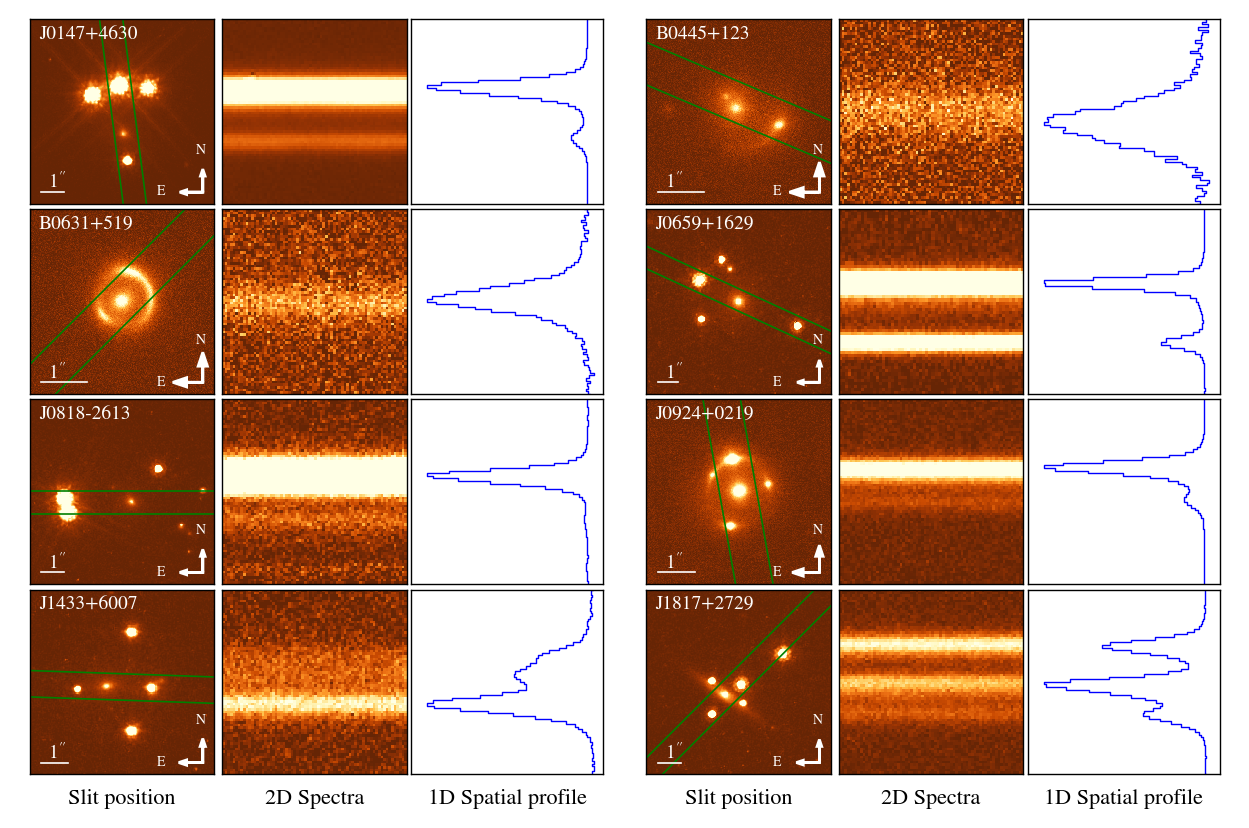

In [14]:
fg = plt.figure(figsize=(7.7, 5.0))
rows = 4
columns = 7
gs = gridspec.GridSpec(rows, columns, figure=fg, width_ratios=[1, 1, 1, 0.2, 1, 1, 1])
file_num = 8
r = -1
for i in range(file_num):
    if i%2==0:
        r += 1
        c = 0
    else:
        c = 4
        
    ax1 = fg.add_subplot(gs[r, c])
    
    myim = im.Image(im_file_loc[i], hext=im_hext[i], verbose=False, wcsverb=False)
    #myim.display()
    if im_cent[i] is None:
        myim.display(imcent=None, imsize=im_size[i], axlabel=False, verbose=False, fig=fg, ax=ax1,
                     fmax=im_fmax[i], fixnans=True)
    else:
        myim.display(imcent=(coordinates[i][0]+imcent_offest[i][0], coordinates[i][1]+imcent_offest[i][1]),
                     imsize=im_size[i], axlabel=False, verbose=False, fig=fg, ax=ax1,
                     fmax=im_fmax[i], fixnans=True)
        
    myim.mark_fov(ra=coordinates[i][0]+slit_offset[i][0], dec=coordinates[i][1]+slit_offset[i][1],
                  size=slit_size[i], pa=PA[i], lw=0.6)
    ax1.set_xticks([])
    ax1.set_yticks([])
    txt_off = 8.0/im_size[i]
    ax1.plot([im_size[i]/2-(0.5/txt_off), im_size[i]/2-(0.5/txt_off)-1.0], 
             [-im_size[i]/2+(0.5/txt_off), -im_size[i]/2+(0.5/txt_off)],
         '-', data=None, color='w', lw=0.6)
    ax1.arrow(-im_size[i]/2+(0.5/txt_off), -im_size[i]/2+(0.5/txt_off), 0.7/txt_off, 0, color='w',
               head_width= 0.2, width= 0.000001)#0.0000001/txt_off)0.001/txt_off
    ax1.arrow(-im_size[i]/2+(0.5/txt_off), -im_size[i]/2+(0.5/txt_off), 0, 0.7/txt_off, color='w',
              head_width= 0.2, width=0.000001)#0.0000001/txt_off)/txt_off
    ax1.text(-im_size[i]/2 + 2.5/txt_off, -im_size[i]/2+0.4/txt_off, 'E', fontsize=5, color='w')
    ax1.text(-im_size[i]/2 + 0.8/txt_off, -im_size[i]/2+2.2/txt_off, 'N', fontsize=5, color='w')
    ax1.text(im_size[i]/2-.8/txt_off, -im_size[i]/2+0.7/txt_off, r'$1^{\prime \prime }$',
             fontsize=7, color='w')
    ax1.annotate(lens_name[i], (0.05, 0.9), xycoords='axes fraction',
                 fontsize=7, color='w') #bbox=dict(boxstyle='square', fc='white'))
    ax1.set_xlim(0.5*im_size[i], -0.5*im_size[i])
    ax1.set_ylim(-0.5*im_size[i], 0.5*im_size[i])
    
    ax2 = fg.add_subplot(gs[r, c+1])
    spec = spec2d.Spec2d(file_list[i], hext=sp_hext[i], verbose=False, xtrim=x_trim[i], invar=file_list[i]) 
    if spec.dispaxis!=disp_axis[i]:
        spec.set_dispaxis(disp_axis[i])
        spec['org_data'] = im.WcsHDU(spec.data.T, wcsverb=False, verbose=False)
        spec.display(dmode='org_data', axlabel=False, mode='xy', imcent=sp_cent[i],
                     imsize=sp_im_size[i], fmax=sp_fmax[i], fig=fg, ax=ax2, verbose=False)
    else:
        if i==3:
            spec['org_data'] = im.WcsHDU(spec.data, wcsverb=False, verbose=False)
        else:
            spec['org_data'] = im.WcsHDU(np.flip(spec.data, axis=0), wcsverb=False, verbose=False)
        spec.data = np.flip(spec.data, axis=0)
        spec.display(dmode='org_data', axlabel=False, mode='xy', imcent=sp_cent[i], imsize=sp_im_size[i],
                  fmax=sp_fmax[i], fig=fg, ax=ax2)

    ax2.set_yticks([])
    ax2.set_xticks([])
    
    ax3 = fg.add_subplot(gs[r, c+2])
    pf = spec.spatial_profile(pixrange=pix_range[i], title=None, doplot=False, verbose=False)
    if sp_cent[i] is None:
        if spec.dispaxis=='y':
            wav_offset = spec.data.shape[1]//2 - 35
        else:
            if i==3:
                wav_offset = spec.data.shape[0]//2 - 30
            else:
                wav_offset = spec.data.shape[0]//2 - 35
    else:
        wav_offset = sp_cent[i][1] - 35
    #print(wav_offset)
    ax3.plot(pf['flux']/np.max(pf['flux']), pf['wav']-wav_offset, color='b', linestyle='solid',
             drawstyle = 'steps', lw=0.5)
    #ax3.plot(np.arange(0,50)**2, np.arange(0, 50))
    #print(np.min(pf['flux']))
    #ax3.set_xlim(1.05*np.max(pf['flux']), np.min(pf['flux'])-np.max(pf['flux'])/20)
    
    ax3.set_xlim(1.1, -0.1)
    if i==3:
        ax3.set_ylim(60, 0)
        ax3.yaxis.set_ticks_position('right')
        #ax3.yaxis.set_ticks(np.arange(5, 60, 20))
    else:
        ax3.set_ylim(0, 70)
        ax3.yaxis.set_ticks_position('right')
        ax3.yaxis.set_ticks(np.arange(5, 70, 20))
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    if i%2==0:
        ax4 = fg.add_subplot(gs[r, 3])
        ax4.remove()
        
    plt.subplots_adjust(wspace=0.004, hspace=0.03)
    
    if r==rows-1:
        ax1.set_xlabel('Slit position', fontsize=8,labelpad=5)
        ax2.set_xlabel('2D Spectra', fontsize=8, labelpad=5)
        ax3.set_xlabel('1D Spatial profile', fontsize=8, labelpad=5)
        
plt.savefig('paper_plots/fig1_try.pdf', format='pdf', dpi=500, bbox_inches='tight')


   Cutout data in section [xrange,yrange]:  [2013:2083,24:94]
   Cutout image center (x, y): (2048, 59)
   Cutout image size (x y): 70x70



Old value of dispaxis: x

Dispersion axis:              y
N_pixels along dispersion axis: 4096


   Cutout data in section [xrange,yrange]:  [3790:3860,18:88]
   Cutout image center (x, y): (3825, 53)
   Cutout image size (x y): 70x70


Found 1 NaNs in the two-dimensional spectrum
after fixing number of NaNs is 0

Old value of dispaxis: x

Dispersion axis:              y
N_pixels along dispersion axis: 4096


   Cutout data in section [xrange,yrange]:  [2013:2083,6:76]
   Cutout image center (x, y): (2048, 41)
   Cutout image size (x y): 70x70


   Cutout data in section [xrange,yrange]:  [2018:2078,1:61]
   Cutout image center (x, y): (2048, 31)
   Cutout image size (x y): 60x60


   Cutout data in section [xrange,yrange]:  [1735:1805,23:93]
   Cutout image center (x, y): (1770, 58)
   Cutout image size (x y): 70x70


   Cutout data in section [

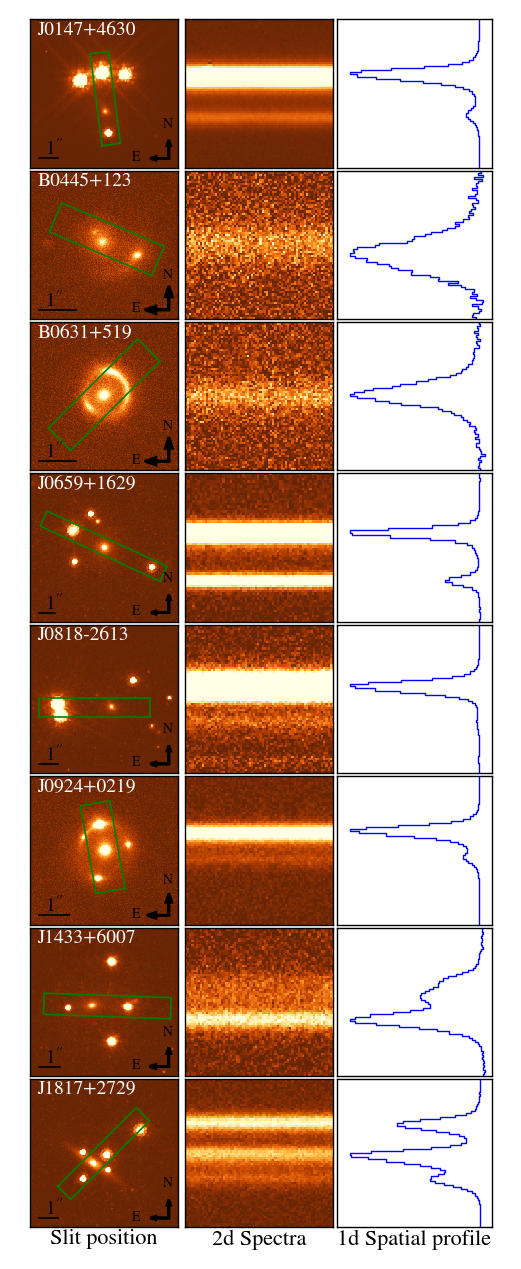

In [108]:
fg = plt.figure(figsize=(3.5, 8))
rows = 8
columns = 3
gs = gridspec.GridSpec(rows, columns, figure=fg)

for i in range(rows):
    ax1 = fg.add_subplot(gs[i, 0])
    myim = im.Image(im_file_loc[i], hext=im_hext[i], verbose=False, wcsverb=False)
    #myim.display()
    if im_cent[i] is None:
        myim.display(imcent=None, imsize=im_size[i], axlabel=False, verbose=False, fig=fg, ax=ax1,
                     fmax=im_fmax[i], fixnans=True)
    else:
        myim.display(imcent=(coordinates[i][0]+imcent_offest[i][0], coordinates[i][1]+imcent_offest[i][1]),
                     imsize=im_size[i], axlabel=False, verbose=False, fig=fg, ax=ax1,
                     fmax=im_fmax[i], fixnans=True)
        
    myim.mark_fov(ra=coordinates[i][0]+slit_offset[i][0], dec=coordinates[i][1]+slit_offset[i][1],
                  size=slit_size[i], pa=PA[i], lw=0.6)
    ax1.set_xticks([])
    ax1.set_yticks([])
    txt_off = 8.0/im_size[i]
    ax1.plot([im_size[i]/2-(0.5/txt_off), im_size[i]/2-(0.5/txt_off)-1.0], 
             [-im_size[i]/2+(0.5/txt_off), -im_size[i]/2+(0.5/txt_off)],
         '-', data=None, color='k', lw=0.6)
    ax1.arrow(-im_size[i]/2+(0.5/txt_off), -im_size[i]/2+(0.5/txt_off), 0.7/txt_off, 0, color='k',
               head_width= 0.2, width= 0.000001)#0.0000001/txt_off)0.001/txt_off
    ax1.arrow(-im_size[i]/2+(0.5/txt_off), -im_size[i]/2+(0.5/txt_off), 0, 0.7/txt_off, color='k',
              head_width= 0.2, width=0.000001)#0.0000001/txt_off)/txt_off
    ax1.text(-im_size[i]/2 + 2.5/txt_off, -im_size[i]/2+0.4/txt_off, 'E', fontsize=5, color='k')
    ax1.text(-im_size[i]/2 + 0.8/txt_off, -im_size[i]/2+2.2/txt_off, 'N', fontsize=5, color='k')
    ax1.text(im_size[i]/2-.8/txt_off, -im_size[i]/2+0.7/txt_off, r'$1^{\prime \prime }$',
             fontsize=7, color='k')
    ax1.annotate(lens_name[i], (0.05, 0.9), xycoords='axes fraction',
                 fontsize=7, color='w') #bbox=dict(boxstyle='square', fc='white'))

    ax2 = fg.add_subplot(gs[i, 1])
    spec = spec2d.Spec2d(file_list[i], hext=sp_hext[i], verbose=False, xtrim=x_trim[i]) 
    if spec.dispaxis!=disp_axis[i]:
        spec.set_dispaxis(disp_axis[i])
        spec['org_data'] = im.WcsHDU(spec.data.T, wcsverb=False, verbose=False)
        spec.display(dmode='org_data', axlabel=False, mode='xy', imcent=sp_cent[i],
                     imsize=sp_im_size[i], fmax=sp_fmax[i], fig=fg, ax=ax2, verbose=False)
    else:
        if i==3:
            spec['org_data'] = im.WcsHDU(spec.data, wcsverb=False, verbose=False)
        else:
            spec['org_data'] = im.WcsHDU(np.flip(spec.data, axis=0), wcsverb=False, verbose=False)
        spec.data = np.flip(spec.data, axis=0)
        spec.display(dmode='org_data', axlabel=False, mode='xy', imcent=sp_cent[i], imsize=sp_im_size[i],
                  fmax=sp_fmax[i], fig=fg, ax=ax2)

    ax2.set_yticks([])
    ax2.set_xticks([])

    ax3 = fg.add_subplot(gs[i, 2])
    pf = spec.spatial_profile(pixrange=pix_range[i], title=None, doplot=False, verbose=False)
    if sp_cent[i] is None:
        if spec.dispaxis=='y':
            wav_offset = spec.data.shape[1]//2 - 35
        else:
            if i==3:
                wav_offset = spec.data.shape[0]//2 - 30
            else:
                wav_offset = spec.data.shape[0]//2 - 35
    else:
        wav_offset = sp_cent[i][1] - 35
    #print(wav_offset)
    ax3.plot(pf['flux']/np.max(pf['flux']), pf['wav']-wav_offset, color='b', linestyle='solid',
             drawstyle = 'steps', lw=0.5)
    #ax3.plot(np.arange(0,50)**2, np.arange(0, 50))
    #print(np.min(pf['flux']))
    #ax3.set_xlim(1.05*np.max(pf['flux']), np.min(pf['flux'])-np.max(pf['flux'])/20)
    
    ax3.set_xlim(1.1, -0.1)
    if i==3:
        ax3.set_ylim(60, 0)
        ax3.yaxis.set_ticks_position('right')
        #ax3.yaxis.set_ticks(np.arange(5, 60, 20))
    else:
        ax3.set_ylim(0, 70)
        ax3.yaxis.set_ticks_position('right')
        ax3.yaxis.set_ticks(np.arange(5, 70, 20))
    ax3.set_xticks([])
    ax3.set_yticks([])
    #ax3.tick_params(axis='both', labelsize=5, length=0.8, pad=0.05)
    
    if i==rows-1:
        ax1.set_xlabel('Slit position', fontsize=8)
        ax2.set_xlabel('2d Spectra', fontsize=8)
        ax3.set_xlabel('1d Spatial profile', fontsize=8)

    #fg.tight_layout()
    plt.subplots_adjust(wspace=0.004, hspace=0.02)
#plt.savefig('paper_plots/fig1.pdf', format='pdf', dpi=500, bbox_inches='tight')

### Below are some tests with individual image files to determine parameters to provide to the final plot


Loading file ../Target_image_file/J0659+1629/idxo08020_drc.fits
-----------------------------------------------
Pixel scale (x, y): (  0.040,   0.040) arcsec/pix
Instrument FOV (arcsec):   163.6 x   173.9
Image position angle (E of N): -137.61



(4.5, -4.5)

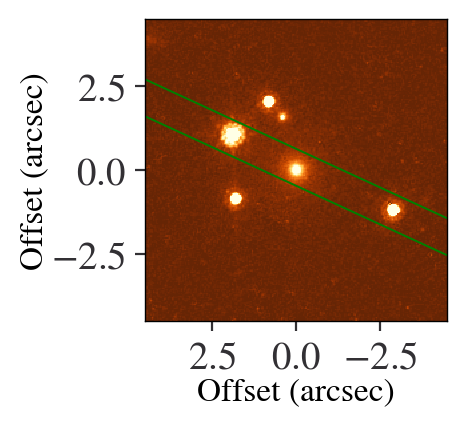

In [35]:
plt.figure(figsize=(2, 2))
myim = im.Image(im_file_loc[3], hext=1)
#myim.display(fixnans=True)
myim.display(imcent=(coordinates[3][0], coordinates[3][1]), fixnans=True, imsize=9, fmax=40)
myim.mark_fov(ra=coordinates[3][0], dec=coordinates[3][1]+0.00003,  size=[1.0, 18.0], pa=PA[3], lw=0.7)
#myim.plot_circle(ra=coordinates[1][0], dec=coordinates[1][1], radius=1.0)
plt.xlim(4.5, -4.5)


Loading file ../Target_image_file/B0445+123/B0445_nirc2_n_Kp_6x6.fits
-----------------------------------------------
Pixel scale (x, y): (  0.010,   0.010) arcsec/pix
Instrument FOV (arcsec):     6.0 x     6.0
Image position angle (E of N):   -0.00
in display, going to set_subim False
in set_subim, going to poststamp_radec False
in poststamp_radec, going to cutout_radec False
in cutout_radec False

Calculating display limits
--------------------------
 Clipped mean: 0.027179
 Clipped rms:  0.066024
 fmin (mean -   1 sigma):  -0.038845
 fmax (mean +  18 sigma):  1.215617


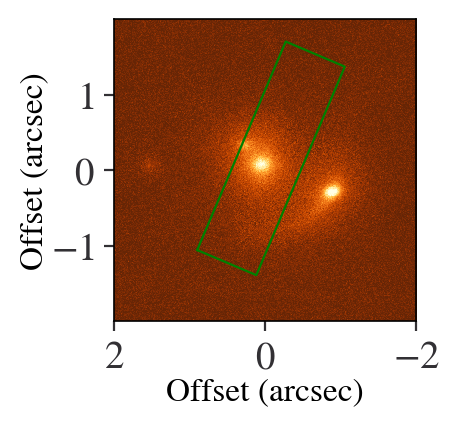

In [36]:
plt.figure(figsize=(2, 2))
for i, fl in enumerate(im_file_loc[:1]):
    myim = im.Image(fl)
    #myim.display()
    myim.display(imcent=None, imsize=4.0, fmax=18, fixnans=True)
    myim.mark_fov(ra=coordinates[i][0]+0.00025, dec=coordinates[i][1]-0.00025,  size=[0.85, 3.0], pa=PA[i],
                 lw=0.8)


Loading file ../Target_image_file/B0631+519/B0631_nirc2_n_Kp_6x6.fits
-----------------------------------------------
Pixel scale (x, y): (  0.010,   0.010) arcsec/pix
Instrument FOV (arcsec):     6.0 x     6.0
Image position angle (E of N):   -0.00
in display, going to set_subim False
in set_subim, going to poststamp_radec False
in poststamp_radec, going to cutout_radec False
in cutout_radec False

Calculating display limits
--------------------------
 Clipped mean: 0.009697
 Clipped rms:  0.041596
 fmin (mean -   1 sigma):  -0.031898
 fmax (mean +  18 sigma):  0.758424


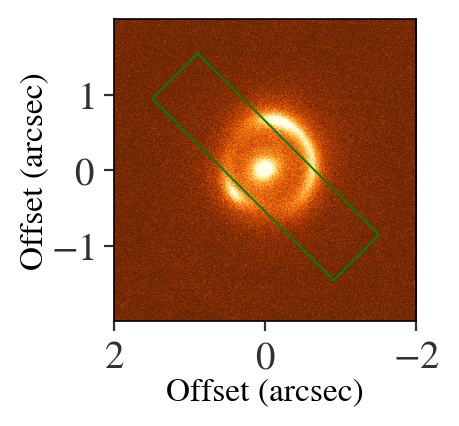

In [59]:
plt.figure(figsize=(2, 2))
myim = im.Image(im_file_loc[1])
#myim.display()
myim.display(imcent=None, imsize=4, fmax=18)
myim.mark_fov(ra=coordinates[1][0]+0.00045, dec=coordinates[1][1]-0.00027,  size=[.85, 3.4], pa=PA[1], lw=0.7)
#myim.plot_circle(ra=coordinates[1][0], dec=coordinates[1][1], radius=1.0)


Loading file ../Target_image_file/PSJ0147+4630_F814W_drc_sci.fits
-----------------------------------------------
Pixel scale (x, y): (  0.040,   0.040) arcsec/pix
Instrument FOV (arcsec):   181.0 x   171.1
Image position angle (E of N):   -0.00
------------------
 Requested center (RA, dec):  26.7923825    +46.511686
 Requested center (RA, dec):  01 47 10.172 +46 30 42.07
 Requested center (x, y):      3291.27  2117.38
 Requested image size (arcsec):   8.00   8.00
 Requested size in input pixels: 200 200
 ------------------
 Image PA is effectively zero, so doing pixel-based cutout
   Cutout data in section [xrange,yrange]:  [3191:3391,2017:2217]
   Cutout image center (x, y): (3291, 2117)
   Cutout image size (x y): 200x200

Calculating display limits
--------------------------
 Clipped mean: 0.014564
 Clipped rms:  0.013802
 fmin (mean -   1 sigma):  0.000762
 fmax (mean +  80 sigma):  1.118689


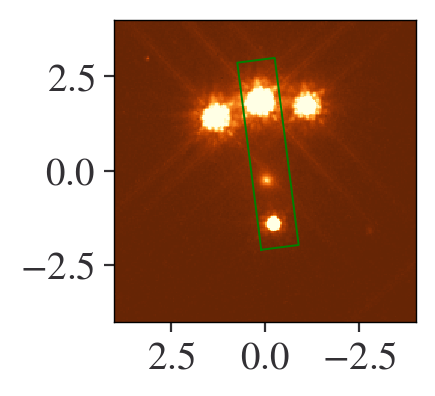

In [320]:
plt.figure(figsize=(2, 2))
#myim = im.Image('../Target_image_file/J0147_cutout.fits')
myim = im.Image(im_file_loc[2])
myim.display(imcent=(coordinates[2][0], coordinates[2][1]), imsize=8, fmax=80, 
             axlabel=False, verbose=True)#(coordinates[2][0], coordinates[2][1])
myim.mark_fov(ra=coordinates[2][0]+0.05146, dec=coordinates[2][1]-0.0223,  size=[1.0, 5.0], pa=PA[2],
            lw=0.7)
#plt.xticks([])
#plt.yticks([])
#print((coordinates[2][0], coordinates[2][1]))


Loading file ../Target_image_file/PSJ0147+4630_F814W_drc_sci.fits
-----------------------------------------------
Pixel scale (x, y): (  0.040,   0.040) arcsec/pix
Instrument FOV (arcsec):   181.0 x   171.1
Image position angle (E of N):   -0.00
in display, going to set_subim True
in set_subim, going to poststamp_radec True
in poststamp_radec, going to cutout_radec True
in cutout_radec True
------------------
 Requested center (RA, dec):  26.7923825    +46.511886
 Requested center (RA, dec):  01 47 10.172 +46 30 42.79
 Requested center (x, y):      3291.27  2135.38
 Requested image size (arcsec):   8.00   8.00
 Requested size in input pixels: 200 200
 ------------------
 Image PA is effectively zero, so doing pixel-based cutout
   Cutout data in section [xrange,yrange]:  [3191:3391,2035:2235]
   Cutout image center (x, y): (3291, 2135)
   Cutout image size (x y): 200x200

Calculating display limits
--------------------------
 Clipped mean: 0.015541
 Clipped rms:  0.013514
 fmin (mean 

([], [])

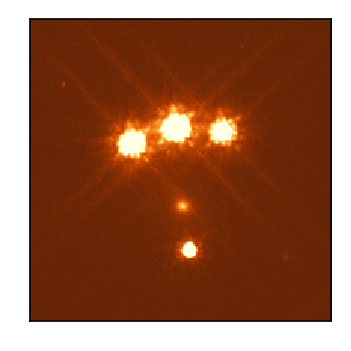

In [88]:
plt.figure(figsize=(2, 2))
myim = im.Image(im_file_loc[2])
#myim.display()
myim.display(imcent=(coordinates[2][0], coordinates[2][1]+0.0002), imsize=8, fmax=80,
             axlabel=False, verbose=True)#imsize=150,
myim.mark_fov(ra=coordinates[2][0]-0.01, dec=coordinates[2][1]-0.02,  size=[1.0, 5.0], pa=PA[2],
             lw=0.7)
plt.xticks([])
plt.yticks([])
#plt.plot([2.5, 1.5], [-2.0, -2.0], '-', data=None, color='g', lw=0.7)
#plt.arrow(-2.9, 2, 0.7, 0, color='g', head_width= 0.1, width=0.003)
#plt.arrow(-2.9, 2, 0, 0.7, color='g', head_width= 0.1, width=0.003)
#plt.text(-1.9, 2.1, 'E', fontsize=6, color='g')
#plt.text(-2.5, 2.7, 'N', fontsize=6, color='g')
#plt.text(2.5, -2.3, '1 arcsec', fontsize=6, color='g')
#plt.savefig('paper_plots/fig1.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [41]:
myim.dispim.

(202, 202)


Loading file ../Target_image_file/J0818-2613/idxo14020_drc.fits
-----------------------------------------------
Pixel scale (x, y): (  0.040,   0.040) arcsec/pix
Instrument FOV (arcsec):   163.6 x   173.9
Image position angle (E of N): -109.30
in display, going to set_subim False
in set_subim, going to poststamp_radec False
in poststamp_radec, going to cutout_radec False
in cutout_radec False

Calculating display limits
--------------------------
 Clipped mean: 0.005314
 Clipped rms:  0.007395
 fmin (mean -   1 sigma):  -0.002081
 fmax (mean +  60 sigma):  0.449011


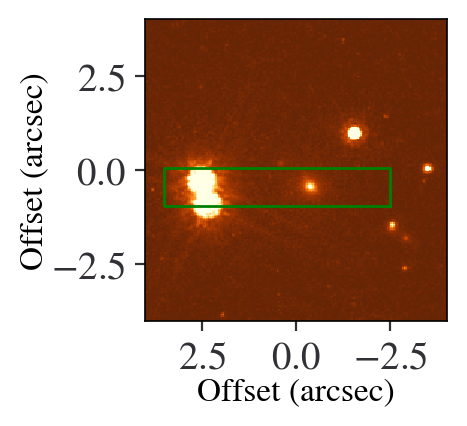

In [95]:
plt.figure(figsize=(2, 2))
myim = im.Image(im_file_loc[3], hext=1)#im_file_loc[3]
#myim.display(verbose=True, debug=True, fixnans=True)
myim.display(imcent=(coordinates[3][0]+0.00015, coordinates[3][1]+0.00025), imsize=8,
             fmax=60, fixnans=True)
myim.mark_fov(ra=coordinates[3][0]+0.0003, dec=coordinates[3][1]+0.00013,  size=[1.0, 6.0], pa=PA[3])


Loading file ../Target_image_file/0924_nirc2n_sharp_Kp.fits
-----------------------------------------------
Pixel scale (x, y): (  0.010,   0.010) arcsec/pix
Instrument FOV (arcsec):    15.2 x    15.2
Image position angle (E of N):   -0.00



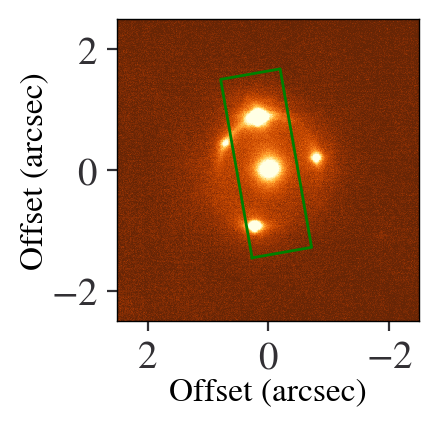

In [226]:
plt.figure(figsize=(2, 2))
myim = im.Image(im_file_loc[4])
#myim.display()
myim.display(imcent=(coordinates[4][0], coordinates[4][1]),  imsize=5, fmax=20)
myim.mark_fov(ra=coordinates[4][0]+0.00144, dec=coordinates[4][1]-0.00146,  size=[1.0, 3.0], pa=PA[4])


Loading file ../Target_image_file/J1433+6007/idgc07010_drc.fits
-----------------------------------------------
Pixel scale (x, y): (  0.040,   0.040) arcsec/pix
Instrument FOV (arcsec):   163.6 x   173.9
Image position angle (E of N):  -42.34



Text(2.7, -2.8, '$1^{\\prime \\prime }$')

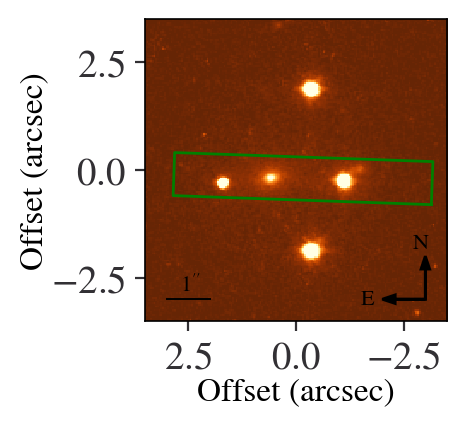

In [77]:
plt.figure(figsize=(2, 2))
myim = im.Image(im_file_loc[5], hext=1)
#myim.display(fixnans=True)
myim.display(imcent=(coordinates[5][0]+0.0002, coordinates[5][1]-0.0001),  imsize=7, fmax=50, fixnans=True)
myim.mark_fov(ra=coordinates[5][0]+0.0001, dec=coordinates[5][1]-0.00015,  size=[1.0, 6.0], pa=PA[5])
plt.plot([im_size[5]/2-0.5, im_size[5]/2-1.5], [-im_size[5]/2+0.5, -im_size[5]/2+0.5],
         '-', data=None, color='k', lw=0.7)
plt.arrow(-im_size[5]/2+0.5, -im_size[5]/2+0.5, 0.7, 0, color='k', head_width= 0.2, width=0.003)
plt.arrow(-im_size[5]/2+0.5, -im_size[5]/2+0.5, 0, 0.7, color='k', head_width= 0.2, width=0.003)
plt.text(-im_size[5]/2 + 2.0, -im_size[5]/2+0.4, 'E', fontsize=8, color='k')
plt.text(-im_size[5]/2 + 0.8, -im_size[5]/2+1.7, 'N', fontsize=8, color='k')
plt.text(im_size[5]/2-.8, -im_size[5]/2+0.7, r'$1^{\prime \prime }$', fontsize=8, color='k')


Loading file ../Target_image_file/J1817+2729/idxo16020_drc.fits
-----------------------------------------------
Pixel scale (x, y): (  0.040,   0.040) arcsec/pix
Instrument FOV (arcsec):   163.5 x   173.9
Image position angle (E of N):  +48.00
------------------
 Requested center (RA, dec): 274.3783333    +27.494617
 Requested center (RA, dec):  18 17 30.800 +27 29 40.62
 Requested center (x, y):      2049.90  1141.51
 Requested image size (arcsec):   8.00   8.00
 Requested size in input pixels: 202 202

Calculating display limits
--------------------------
 Clipped mean: 0.002349
 Clipped rms:  0.005637
 fmin (mean -   1 sigma):  -0.003287
 fmax (mean +  60 sigma):  0.340545


Text(3.2, -3.3, '$1^{\\prime \\prime }$')

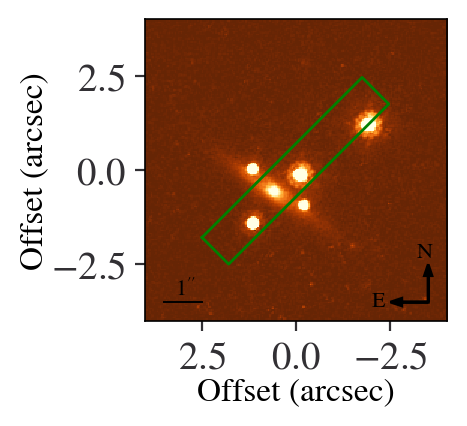

In [75]:
plt.figure(figsize=(2, 2))
myim = im.Image(im_file_loc[6], hext=1)
#myim.display(fixnans=True)
myim.display(imcent=(coordinates[6][0]+0.0005, coordinates[6][1]-0.0008),  imsize=8, fmax=60,
             fixnans=True, verbose=True)
myim.mark_fov(ra=coordinates[6][0]+0.0005, dec=coordinates[6][1]-0.0008,  size=[1.0, 6.0], pa=PA[6])
plt.plot([im_size[6]/2-0.5, im_size[6]/2-1.5], [-im_size[6]/2+0.5, -im_size[6]/2+0.5],
         '-', data=None, color='k', lw=0.7)
plt.arrow(-im_size[6]/2+0.5, -im_size[6]/2+0.5, 0.7, 0, color='k', head_width= 0.2, width=0.003)
plt.arrow(-im_size[6]/2+0.5, -im_size[6]/2+0.5, 0, 0.7, color='k', head_width= 0.2, width=0.003)
plt.text(-im_size[6]/2 + 2.0, -im_size[6]/2+0.4, 'E', fontsize=8, color='k')
plt.text(-im_size[6]/2 + 0.8, -im_size[6]/2+1.7, 'N', fontsize=8, color='k')
plt.text(im_size[6]/2-.8, -im_size[6]/2+0.7, r'$1^{\prime \prime }$', fontsize=8, color='k')

   Cutout data in section [xrange,yrange]:  [1970:2030,0:60]
   Cutout image center (x, y): (2000, 30)
   Cutout image size (x y): 60x60



([], [])

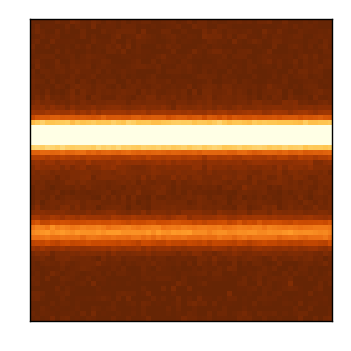

In [69]:
spec3 = spec2d.Spec2d(file_list[3], hext=sp_hext[3], verbose=False, xtrim=x_trim[3]) 
plt.figure(figsize=(2.2, 2.0))
spec3.display(axlabel=False, mode='xy', imcent=(2000, spec3.data.shape[0]//2), imsize=60, fmax=40)
plt.xticks([])
plt.yticks([])
#plt.savefig('paper_plots/fig2.pdf', format='pdf', dpi=200, bbox_inches='tight')

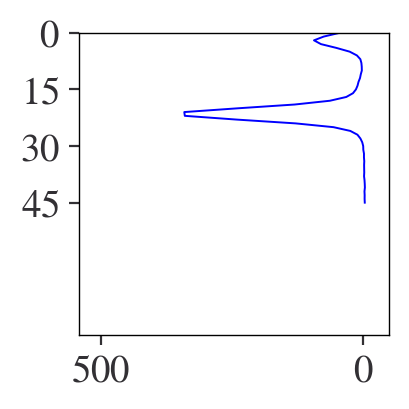

In [99]:
fg = plt.figure(figsize=(2, 2))
ax = fg.gca()
pf = spec3.spatial_profile(pixrange=[1500, 1800], fig=fg, title=None, doplot=False, verbose=False)
ax.plot(pf['flux'], pf['wav']-15, color='b' )
ax.set_xlim(np.max(pf['flux']+200), -50)
ax.set_ylim(80, 0)
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_ticks(np.arange(0, 60, 15))
plt.show()
#plt.savefig('paper_plots/fig3.pdf', format='pdf', dpi=200, bbox_inches='tight')


Loading file ../spectra_extraction/B0445_LRIS_spectra/B0445_r0031_cleaned.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/B0445_LRIS_spectra/B0445_r0031_cleaned.fits (HDU=0)
The input dataset was trimmed
 xrange: 55:161.  yrange: 0:4096
Final data dimensions (x y): 106 x 4096

Dispersion axis:              x
N_pixels along dispersion axis: 106


Old value of dispaxis: x

Dispersion axis:              y
N_pixels along dispersion axis: 4096


   Cutout data in section [xrange,yrange]:  [2008:2088,13:93]
   Cutout image center (x, y): (2048, 53)
   Cutout image size (x y): 80x80



RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

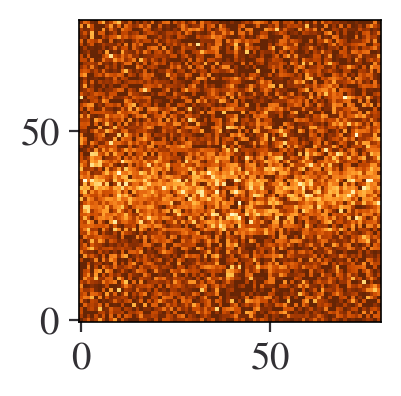

In [8]:
for i in range(len(file_list)):
    #if var_file_list[i] is None:
    fg = plt.figure(figsize=(2, 2))
    spec = spec2d.Spec2d(file_list[i], hext=sp_hext[i], verbose=True, xtrim=x_trim[i]) 
    if spec.dispaxis!=disp_axis[i]:
        spec.set_dispaxis(disp_axis[i])
        spec['org_data'] = im.WcsHDU(spec.data.T, wcsverb=False)
        spec.display(dmode='org_data', axlabel=False, mode='xy', imcent=im_cent[i],
                     imsize=(80, 80), fmax=sp_fmax[i], fig=fg)
    else:
        spec.display(axlabel=False, mode='xy',  imcent=im_cent[i], imsize=(80, 80),
                  fmax=sp_fmax[i], fig=fg)#,  fig=fg, ax=ax2
    plt.colorbar(cax=spec.dispim.ax1)
    plt.show()

In [ ]:
#plt.plot([2.5, 1.5], [-2.0, -2.0], '-', data=None, color='g', lw=0.7)
#plt.arrow(-2.9, 2, 0.7, 0, color='g', head_width= 0.1, width=0.003)
#plt.arrow(-2.9, 2, 0, 0.7, color='g', head_width= 0.1, width=0.003)
#plt.text(-1.9, 2.1, 'E', fontsize=6, color='g')
#plt.text(-2.5, 2.7, 'N', fontsize=6, color='g')
#plt.text(2.5, -2.3, '1 arcsec', fontsize=6, color='g')

## Another plot

In [2]:
file_list = ['../spectra_extraction/J0147_ESI_spectra/J0147_coadd2d_sp_order_9.fits',
            '../spectra_extraction/B0445_LRIS_spectra/B0445_r0030_cleaned.fits',
            '../spectra_extraction/B0631_LRIS_spectra/B0631_r0041_cleaned.fits',
            '../spectra_extraction/J0659_LRIS_spectra/J0659_coadd2d_sp.fits',
            '../spectra_extraction/J0818_ESI_spectra/J0818_coadd2d_sp_order_9.fits',
            '../spectra_extraction/J0924_ESI_spectra/J0924_coadd2d_sp_order_4.fits',
            '../spectra_extraction/J1433_ESI_spectra/J1433_coadd2d_sp_order_6.fits',
            '../spectra_extraction/J1817_ESI_spectra/J1817_coadd2d_sp_order_6.fits']

In [3]:
var_file_list = ['../spectra_extraction/J0147_ESI_spectra/J0147_coadd2d_var_order_9.fits',
            '../spectra_extraction/B0445_LRIS_spectra/B0445_r0030_cleaned.fits',
            '../spectra_extraction/B0631_LRIS_spectra/B0631_r0041_cleaned.fits',
            '../spectra_extraction/J0659_LRIS_spectra/J0659_coadd2d_var.fits',
            '../spectra_extraction/J0818_ESI_spectra/J0818_coadd2d_var_order_9.fits',
            '../spectra_extraction/J0924_ESI_spectra/J0924_coadd2d_var_order_4.fits',
            '../spectra_extraction/J1433_ESI_spectra/J1433_coadd2d_var_order_6.fits',
            '../spectra_extraction/J1817_ESI_spectra/J1817_coadd2d_var_order_6.fits']

## First create the models


Loading file ../spectra_extraction/J0147_ESI_spectra/J0147_coadd2d_sp_order_9.fits
-----------------------------------------------

Loading file ../spectra_extraction/J0147_ESI_spectra/J0147_coadd2d_var_order_9.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/J0147_ESI_spectra/J0147_coadd2d_sp_order_9.fits (HDU=0)
Final data dimensions (x y): 4096 x 117

Dispersion axis:              x
N_pixels along dispersion axis: 4096

Profile max value (before normalization) 3193.193295


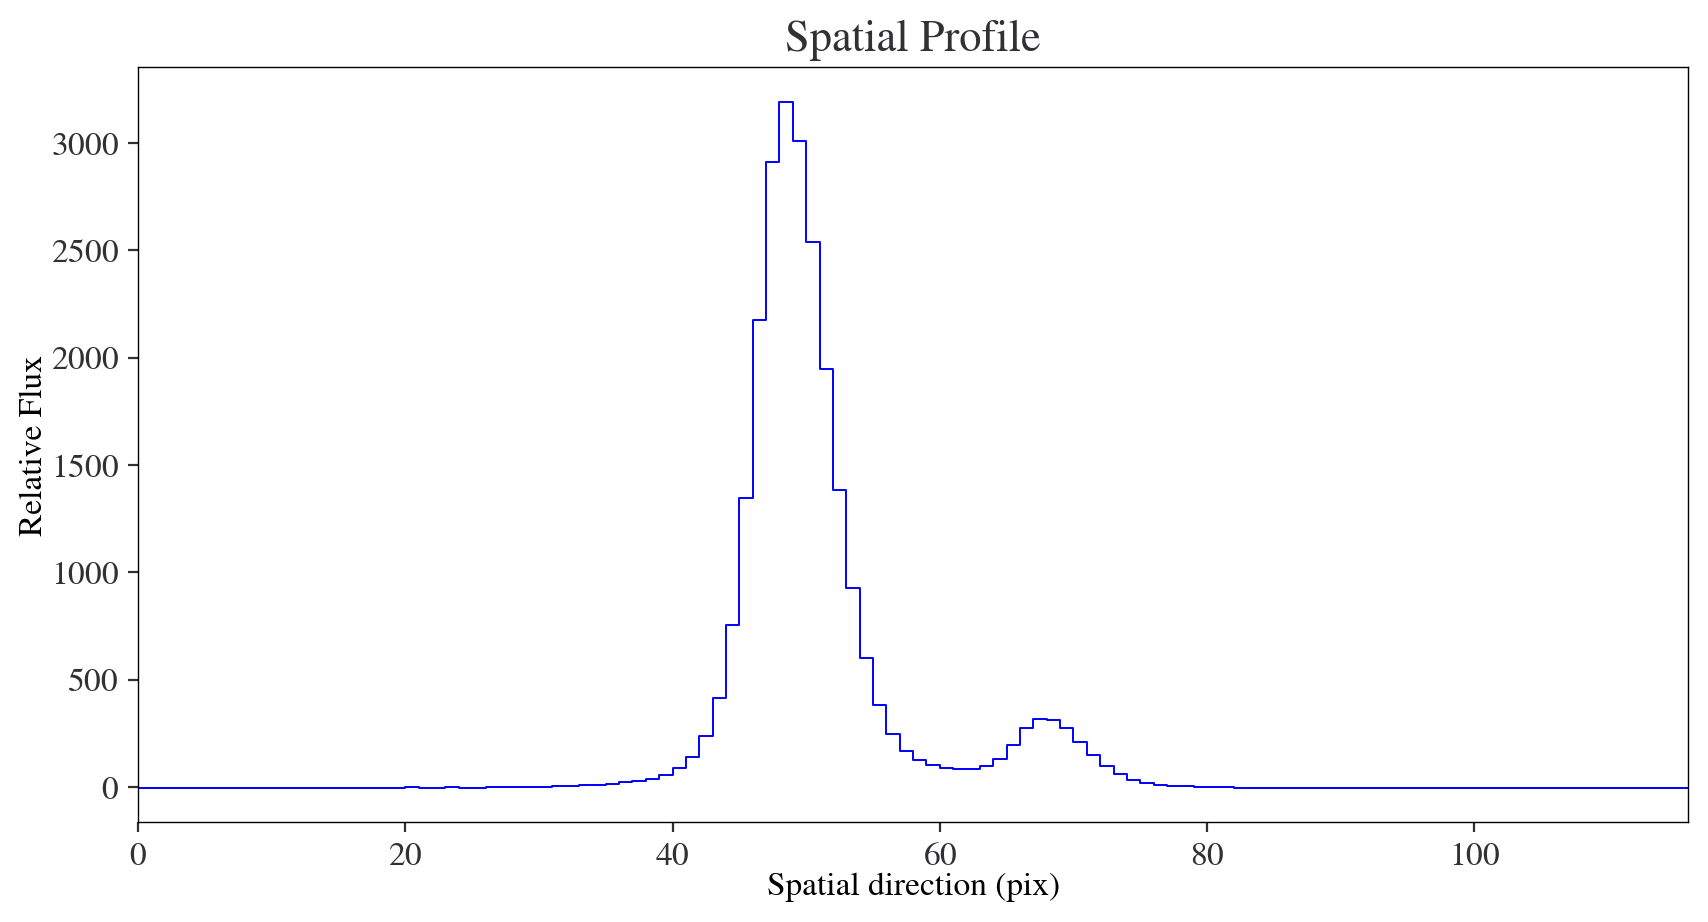


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 3

Now enter constants of the background polynomial upto degree 0
c0 : -3

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 3200, 49, 3, 4

amplitude=3200.000000, x_0=49.000000, gamma=3.000000, alpha=4.000000

Parameters of Moffat profile 2 : 80, 61, 2, 3

amplitude=80.000000, x_0=61.000000, gamma=2.000000, alpha=3.000000

Parameters of Moffat profile 3 : 300, 69, 3, 4

amplitude=300.000000, x_0=69.000000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=-81.99287709)>

    [1]: <Moffat1D(amplitude

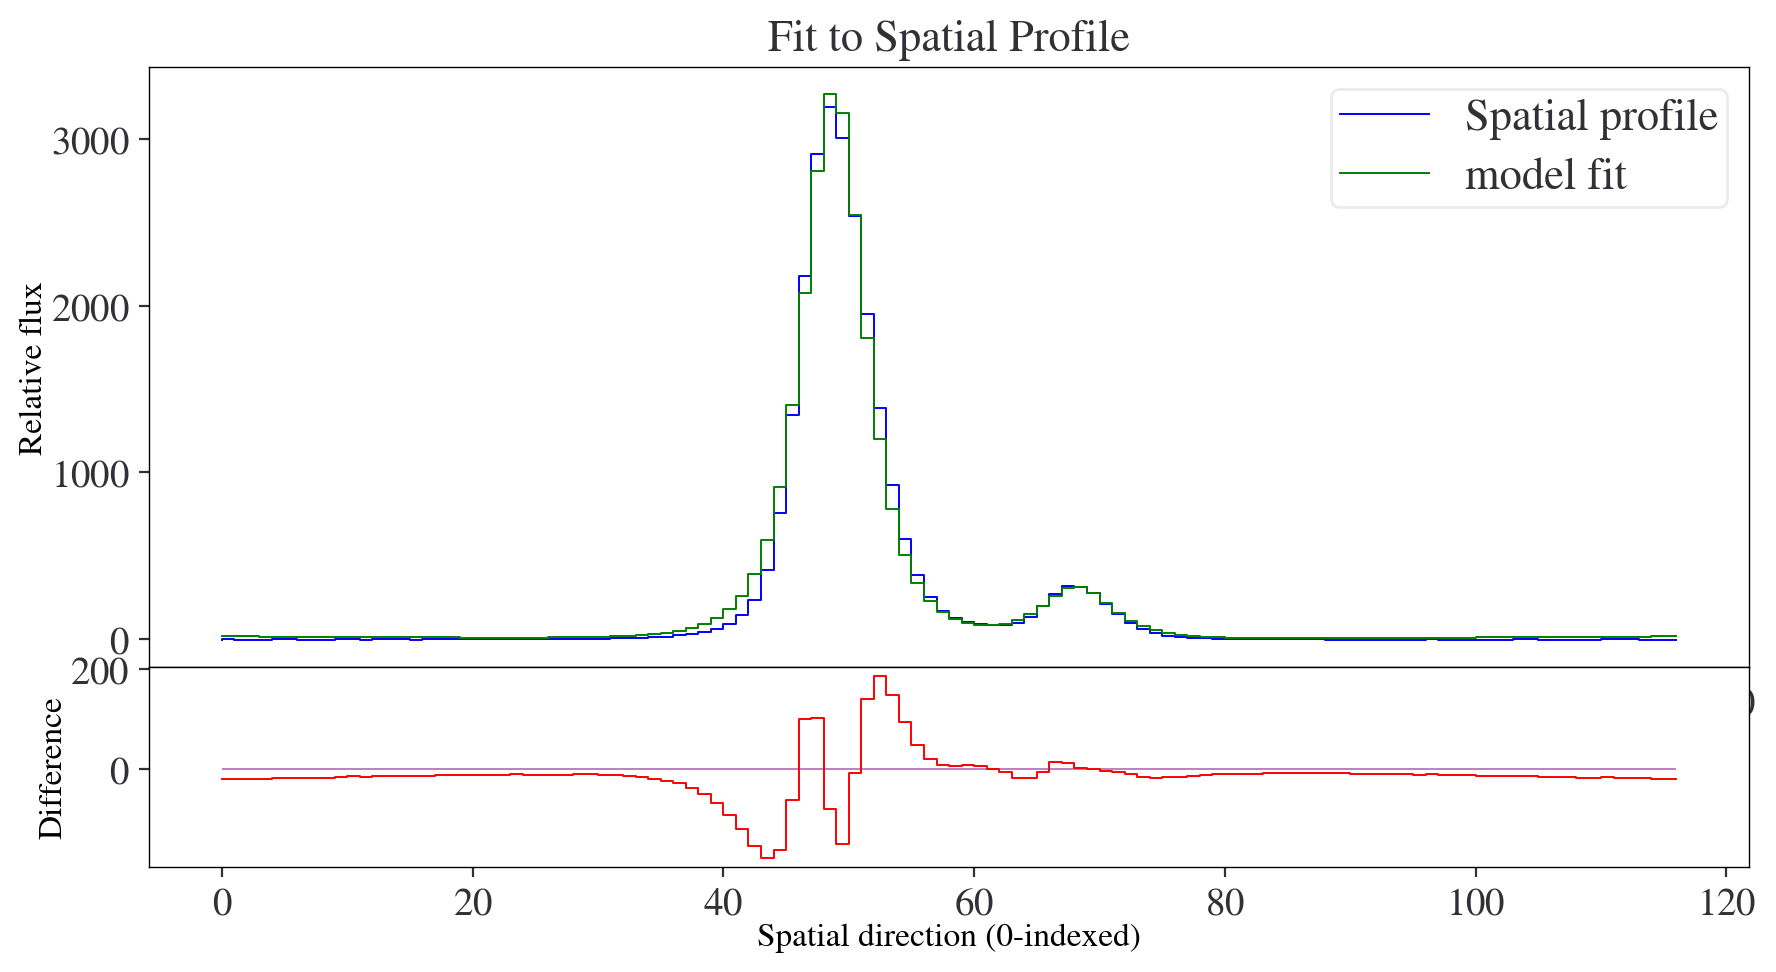

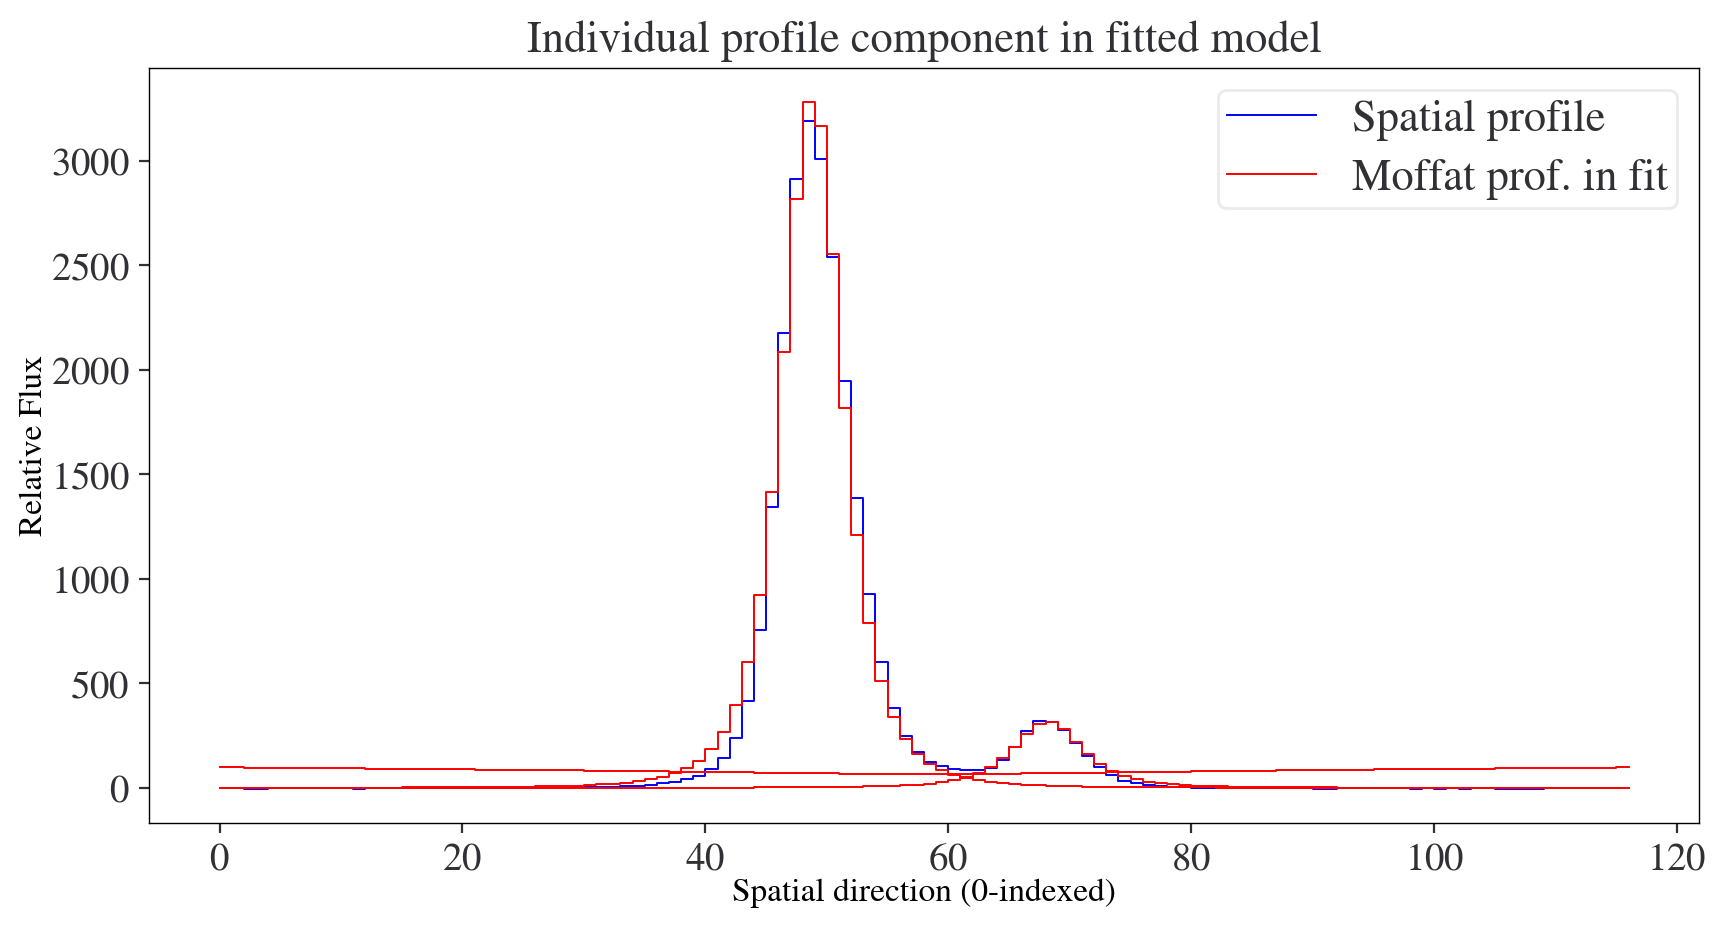


Do you want to start over ? : type yes/no
no


<CompoundModel(c0_0=-81.99287709, amplitude_1=3312.79771988, x_0_1=49.31442979, gamma_1=4.43038937, alpha_1=1.91521257, amplitude_2=65.80796188, x_0_2=58.8713516, gamma_2=13.26416733, alpha_2=-0.13145107, amplitude_3=317.73244248, x_0_3=68.68774168, gamma_3=4.53115223, alpha_3=1.59953406)>

In [4]:
# J0147
spec1 = spec2d.Spec2d(inspec=file_list[0], invar=var_file_list[0])
spec1.spatial_profile(pixrange=[1500, 1801])
plt.show()
spec1.initial_model()


Initial model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=-81.99287709)>

    [1]: <Moffat1D(amplitude=3312.79771988, x_0=49.31442979, gamma=4.43038937, alpha=1.91521257)>

    [2]: <Moffat1D(amplitude=65.80796188, x_0=58.8713516, gamma=13.26416733, alpha=-0.13145107)>

    [3]: <Moffat1D(amplitude=317.73244248, x_0=68.68774168, gamma=4.53115223, alpha=1.59953406)>
Parameters:
           c0_0           amplitude_1     ...      gamma_3           alpha_3     
    ------------------ ------------------ ... ----------------- -----------------
    -81.99287709150455 3312.7977198798703 ... 4.531152233482639 1.599534058387042

-------------------------------------------


Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=-2.22953825)>

    [1]: <Moffat1D(amp

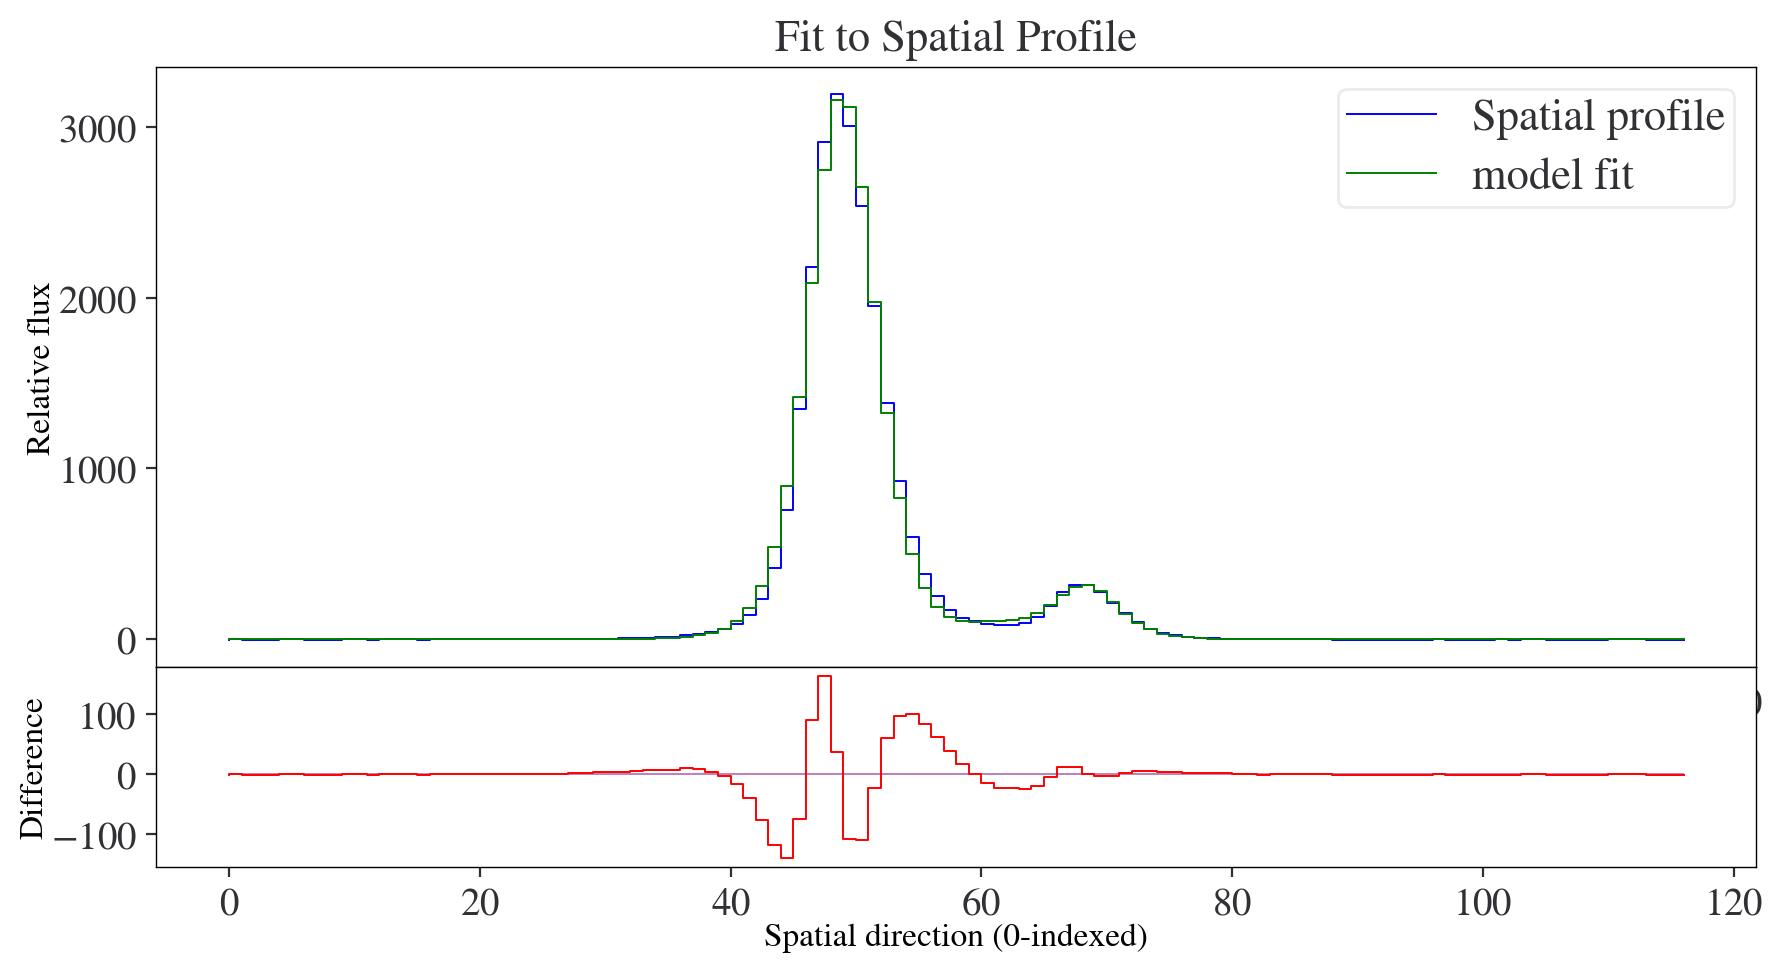

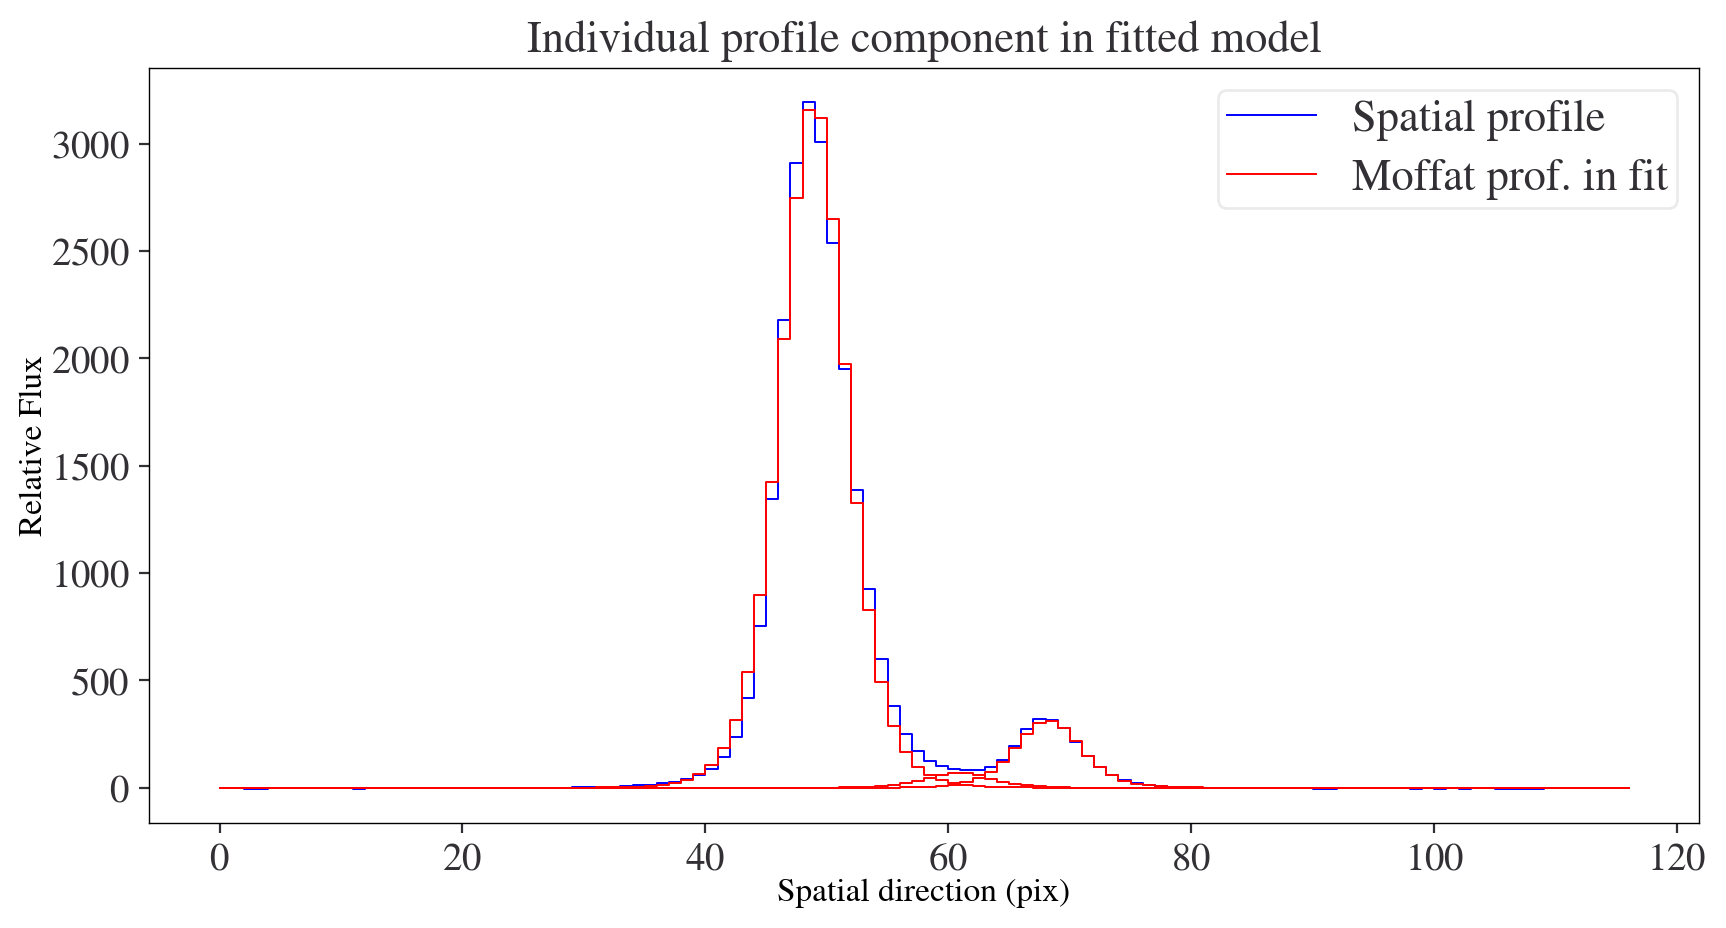

In [5]:
def tie_pos1_moffat_9(model):
    return model.x_0_1 + (1.95 / pixscale[0]) #(0.886 / pixscale)

def tie_pos2_moffat_9(model):
    return model.x_0_1 + (3.15 / pixscale[0])

def tie_gamma_moffat(model):
    return model.gamma_3

def tie_alpha_moffat(model):
    return model.alpha_3

func_dict = {'9_1' : tie_pos1_moffat_9, '9_2' : tie_pos2_moffat_9}

pixscale = [0.163]
ord_list = [9]

spec1.mod0[2].x_0.tied = func_dict['%d_%d' %(ord_list[0], 1)] #tie_pos1_moffat
spec1.mod0[3].x_0.tied = func_dict['%d_%d' %(ord_list[0], 2)] #tie_pos2_moffat
spec1.mod0[1].gamma.tied = tie_gamma_moffat
spec1.mod0[1].alpha.tied = tie_alpha_moffat
spec1.mod0[2].gamma.tied = tie_gamma_moffat
spec1.mod0[2].alpha.tied = tie_alpha_moffat
spec1.refined_model(spec1.mod0)

In [6]:
## get noise data in median pixel
d = spec1.data[:, 1500:1801]
v = spec1.vardata[:, 1500:1801]
l = d.shape[1]
median_array = []
median_indx = []
J0147_var = []

In [7]:
for i in range(d.shape[0]):
    s = np.argsort(d[i])[l//2]
    #print(s)
    median_array.append(d[i][s])
    median_indx.append(s)
    J0147_var.append(v[i][s])

In [8]:
np.sum(spec1.profile['flux'] - np.array(median_array))

0.0

In [9]:
np.sum(np.array(J0147_var)<0)

0

In [23]:
## measure MAD
#J0147_mad=np.median(np.abs(d-np.repeat(np.median(d, axis=1), d.shape[1]).reshape(d.shape[0], d.shape[1])),
#                      axis=1)
J0147_mad = stats.median_abs_deviation(d, axis=1)
J0147_mad

array([ 4.13132974,  3.99108873,  4.3382277 ,  3.6453855 ,  3.8924685 ,
        3.47434436,  4.05395307,  4.17018003,  4.18936556,  3.96442361,
        4.07639216,  3.8957863 ,  3.96510673,  4.22924176,  3.5015606 ,
        3.69792011,  3.93623921,  3.93879243,  4.76696836,  4.05052297,
        3.20923185,  3.62556354,  4.07073213,  3.85893009,  3.76053958,
        3.23527022,  3.01419301,  3.03917272,  2.94995264,  3.44246971,
        3.0533493 ,  3.24925448,  3.25890465,  3.3487519 ,  3.14799857,
        3.4026153 ,  3.30015334,  4.00168984,  3.92512174,  4.29112603,
        4.90801511,  5.15106016,  6.38125671,  8.55905327, 11.67582271,
       14.89857685, 23.54530752, 35.0452814 , 44.15283643, 43.70491417,
       57.38260427, 64.5619188 , 65.61126272, 43.3381072 , 28.74952157,
       18.98494576, 11.00964648,  9.02920106,  6.7760263 ,  5.72673233,
        4.93476013,  4.99347346,  4.50908939,  4.86264748,  5.38993108,
        5.7955726 ,  6.13079872,  8.38472335,  9.6510726 , 11.30


Loading file ../spectra_extraction/B0445_LRIS_spectra/B0445_r0030_cleaned.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/B0445_LRIS_spectra/B0445_r0030_cleaned.fits (HDU=0)
The input dataset was trimmed
 xrange: 60:141.  yrange: 0:4096
Final data dimensions (x y): 81 x 4096

Dispersion axis:              x
N_pixels along dispersion axis: 81


Old value of dispaxis: x

Dispersion axis:              y
N_pixels along dispersion axis: 4096


Dispersion : 0.800000
Found 130 NaNs in the two-dimensional spectrum
after fixing number of NaNs is 0

sky subtracted and cosmic ray rejected data has been resampled along with vardata in place of the coordinateds whcih rectify the tilted wave image
Profile max value (before normalization) 24.634674


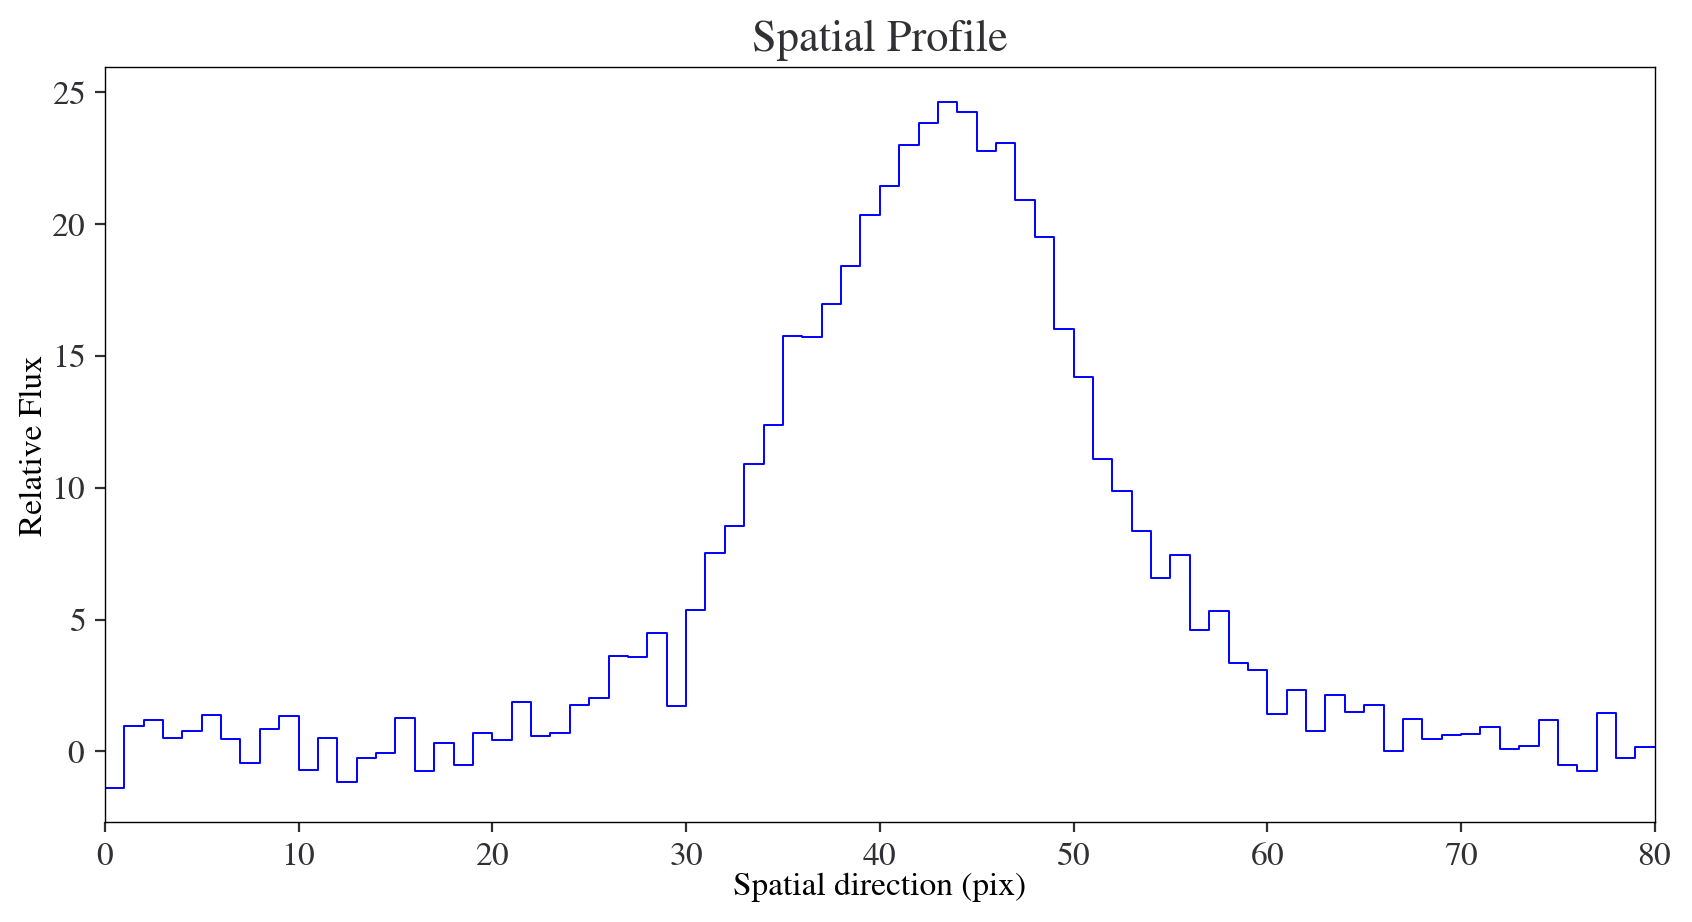


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 1

Now enter constants of the background polynomial upto degree 0
c0 : -1

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 23, 44, 3, 4

amplitude=23.000000, x_0=44.000000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Polynomial1D(0, c0=0.22913546)>

    [1]: <Moffat1D(amplitude=23.98521179, x_0=43.70751363, gamma=23.96619204, alpha=5.92365744)>
Parameters:
            c0_0           amplitude_1     ...      gamma_1            alpha_1     
    ------------------- ------------------ ... ------------------ -----------------
 

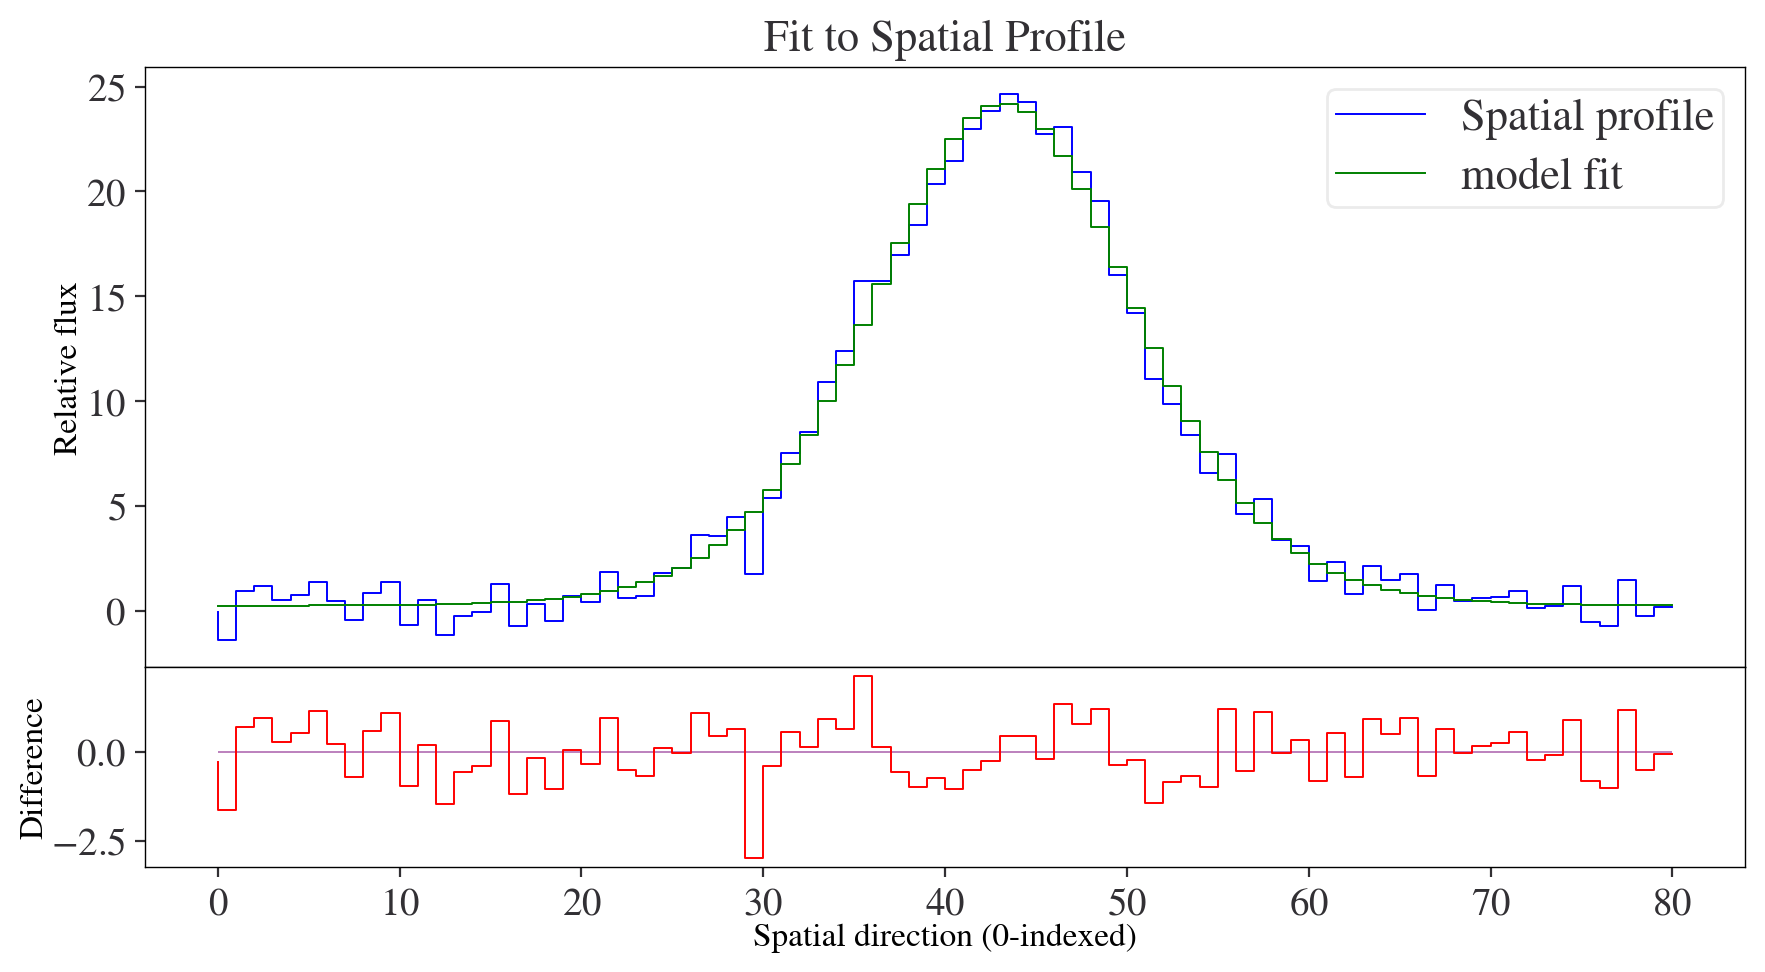

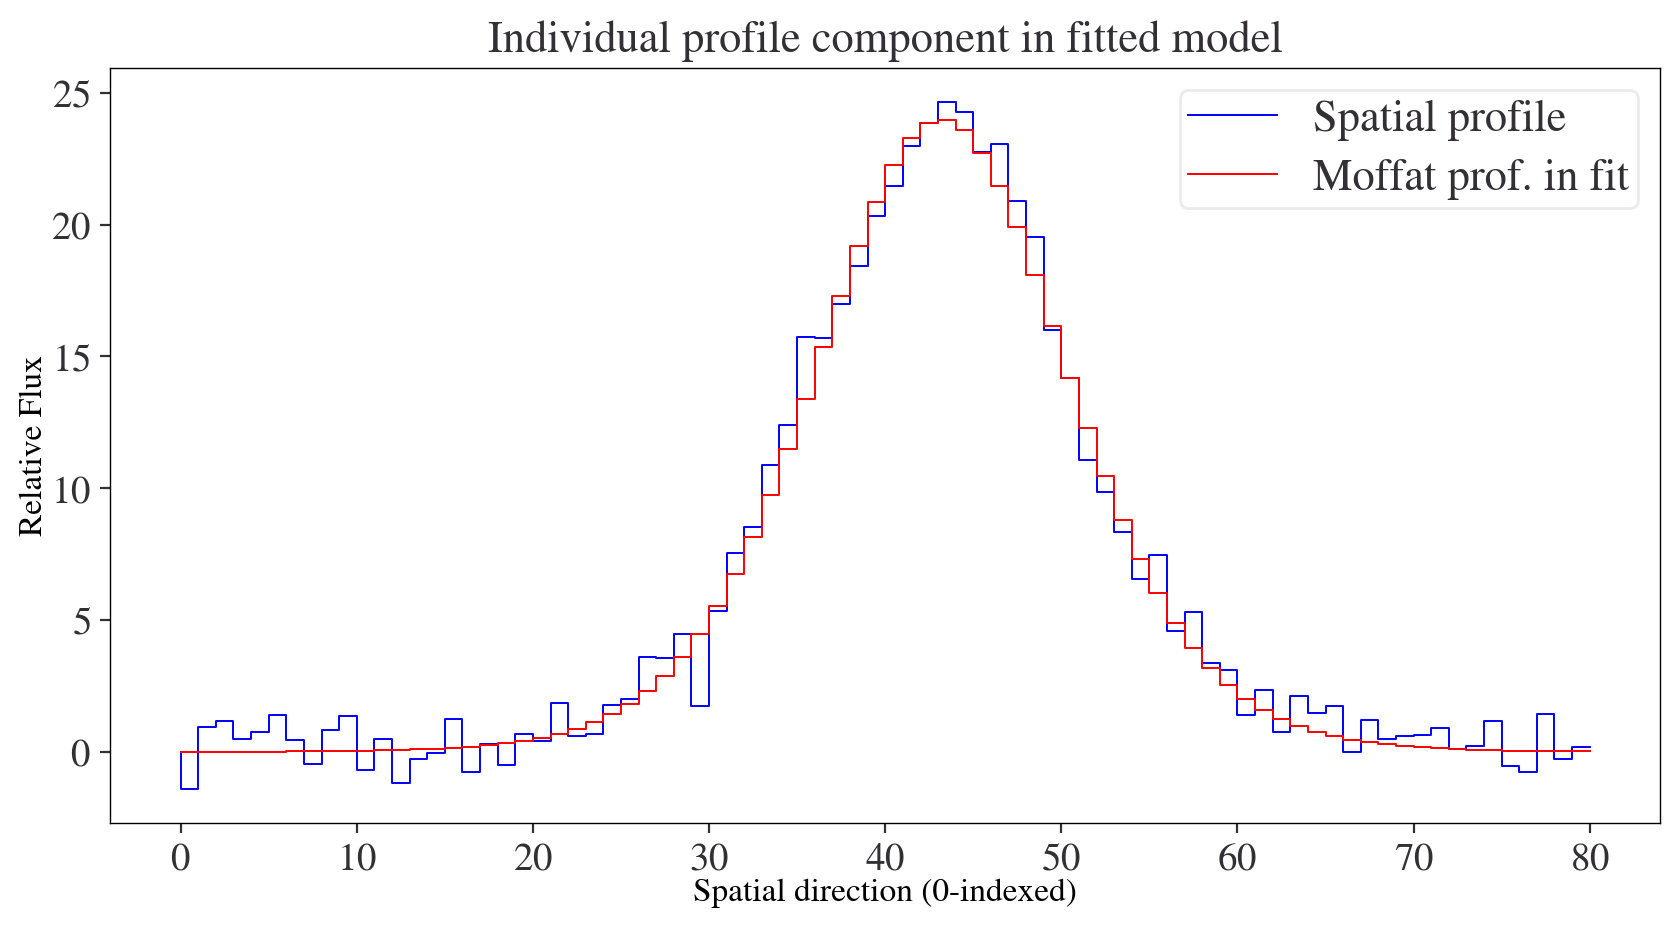


Do you want to start over ? : type yes/no
no


In [24]:
# B0445
spec2 = spec2d.Spec2d(file_list[1], hext=0, varext=1, xtrim=[60, 140])

spec2.set_dispaxis('y')
#plt.show()
spec2.do_waverect(doplot=False, resamp_ord=1, wavext=3)
spec2.spatial_profile(pixrange=[1700, 2401])
plt.show()
mod2 = spec2.initial_model()

In [25]:
## get noise data in median pixel
d, v = spec2.data.T[:, 1700:2401], spec2.vardata.T[:, 1700:2401]
l = d.shape[1]
median_array = []
median_indx = []
B0445_var = []

In [26]:
for i in range(d.shape[0]):
    s = np.argsort(d[i])[l//2]
    #print(s)
    median_array.append(d[i][s])
    median_indx.append(s)
    B0445_var.append(v[i][s])

In [27]:
print(np.sum(spec2.profile['flux'] - np.array(median_array)))
print(np.sum(np.array(B0445_var)<0))

0.0
0


In [32]:
B0445_mad = stats.median_abs_deviation(d, axis=1)
B0445_mad

array([8.365883 , 7.759614 , 8.472098 , 8.529782 , 9.329617 , 8.217162 ,
       8.979167 , 8.631828 , 8.419251 , 8.238856 , 7.659576 , 8.820343 ,
       8.329473 , 8.382813 , 8.74837  , 7.638748 , 8.012077 , 8.5233965,
       8.614558 , 8.5605135, 9.24229  , 9.144523 , 8.585785 , 9.201782 ,
       8.886248 , 8.637117 , 8.61599  , 8.125274 , 8.208334 , 8.479756 ,
       8.254184 , 9.107758 , 8.4154   , 9.543692 , 8.672771 , 8.718976 ,
       8.394967 , 8.324222 , 9.048689 , 8.898211 , 8.534375 , 8.702577 ,
       8.877512 , 9.086124 , 9.453651 , 8.659666 , 9.317728 , 9.550657 ,
       8.775269 , 8.589418 , 9.026665 , 9.243494 , 8.831789 , 8.768102 ,
       9.189691 , 8.732876 , 8.581765 , 8.923794 , 7.902341 , 9.013429 ,
       8.592554 , 8.601681 , 8.603153 , 7.9105377, 8.339724 , 8.547413 ,
       9.18406  , 8.968504 , 8.552456 , 8.353351 , 9.049038 , 8.129494 ,
       7.815907 , 9.192174 , 8.140767 , 8.140066 , 7.87178  , 8.368382 ,
       8.514355 , 7.9901843, 8.917143 ], dtype=floa


Loading file ../spectra_extraction/B0631_LRIS_spectra/B0631_r0041_cleaned.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/B0631_LRIS_spectra/B0631_r0041_cleaned.fits (HDU=1)
The input dataset was trimmed
 xrange: 25:136.  yrange: 0:4096
Final data dimensions (x y): 111 x 4096

Dispersion axis:              x
N_pixels along dispersion axis: 111

Found 1 NaNs in the two-dimensional spectrum
after fixing number of NaNs is 0

Old value of dispaxis: x

Dispersion axis:              y
N_pixels along dispersion axis: 4096


Dispersion : 0.800000
Found 110 NaNs in the two-dimensional spectrum
after fixing number of NaNs is 0

sky subtracted and cosmic ray rejected data has been resampled along with vardata in place of the coordinateds whcih rectify the tilted wave image
Profile max value (before normalization) 43.599339


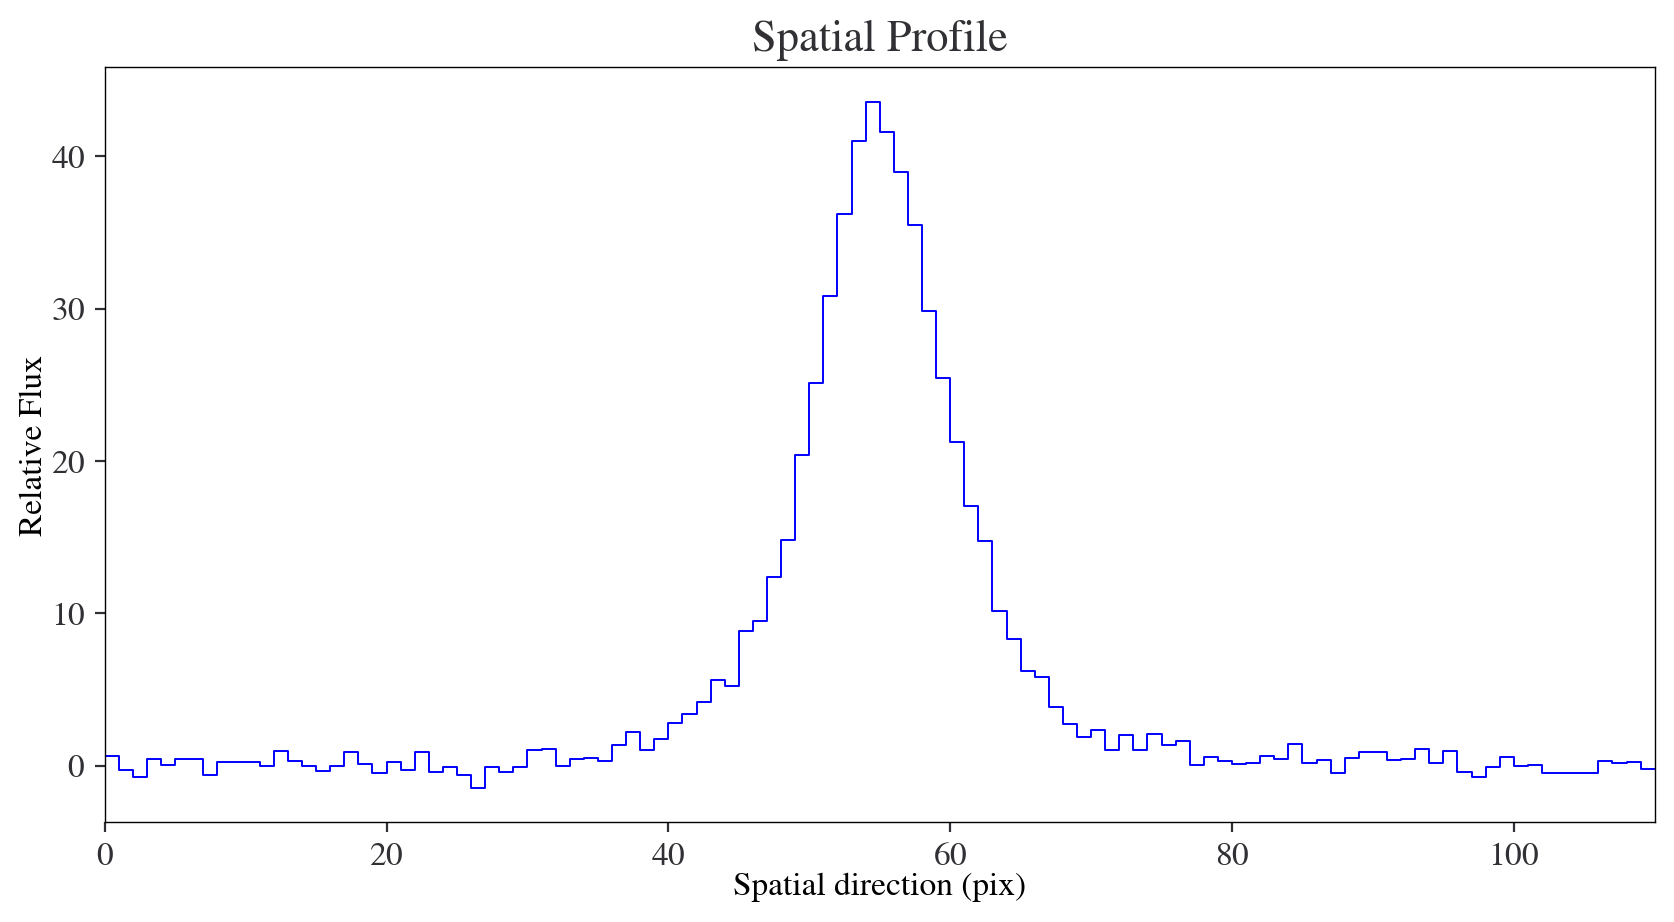


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 1

Now enter constants of the background polynomial upto degree 0
c0 : -0.5

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 43, 54, 3, 4

amplitude=43.000000, x_0=54.000000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Polynomial1D(0, c0=-0.00367264)>

    [1]: <Moffat1D(amplitude=42.7247343, x_0=55.5190918, gamma=8.18277613, alpha=1.96257892)>
Parameters:
             c0_0             amplitude_1    ...      alpha_1      
    ---------------------- ----------------- ... ------------------
    -0.0036726411136525027 42.724

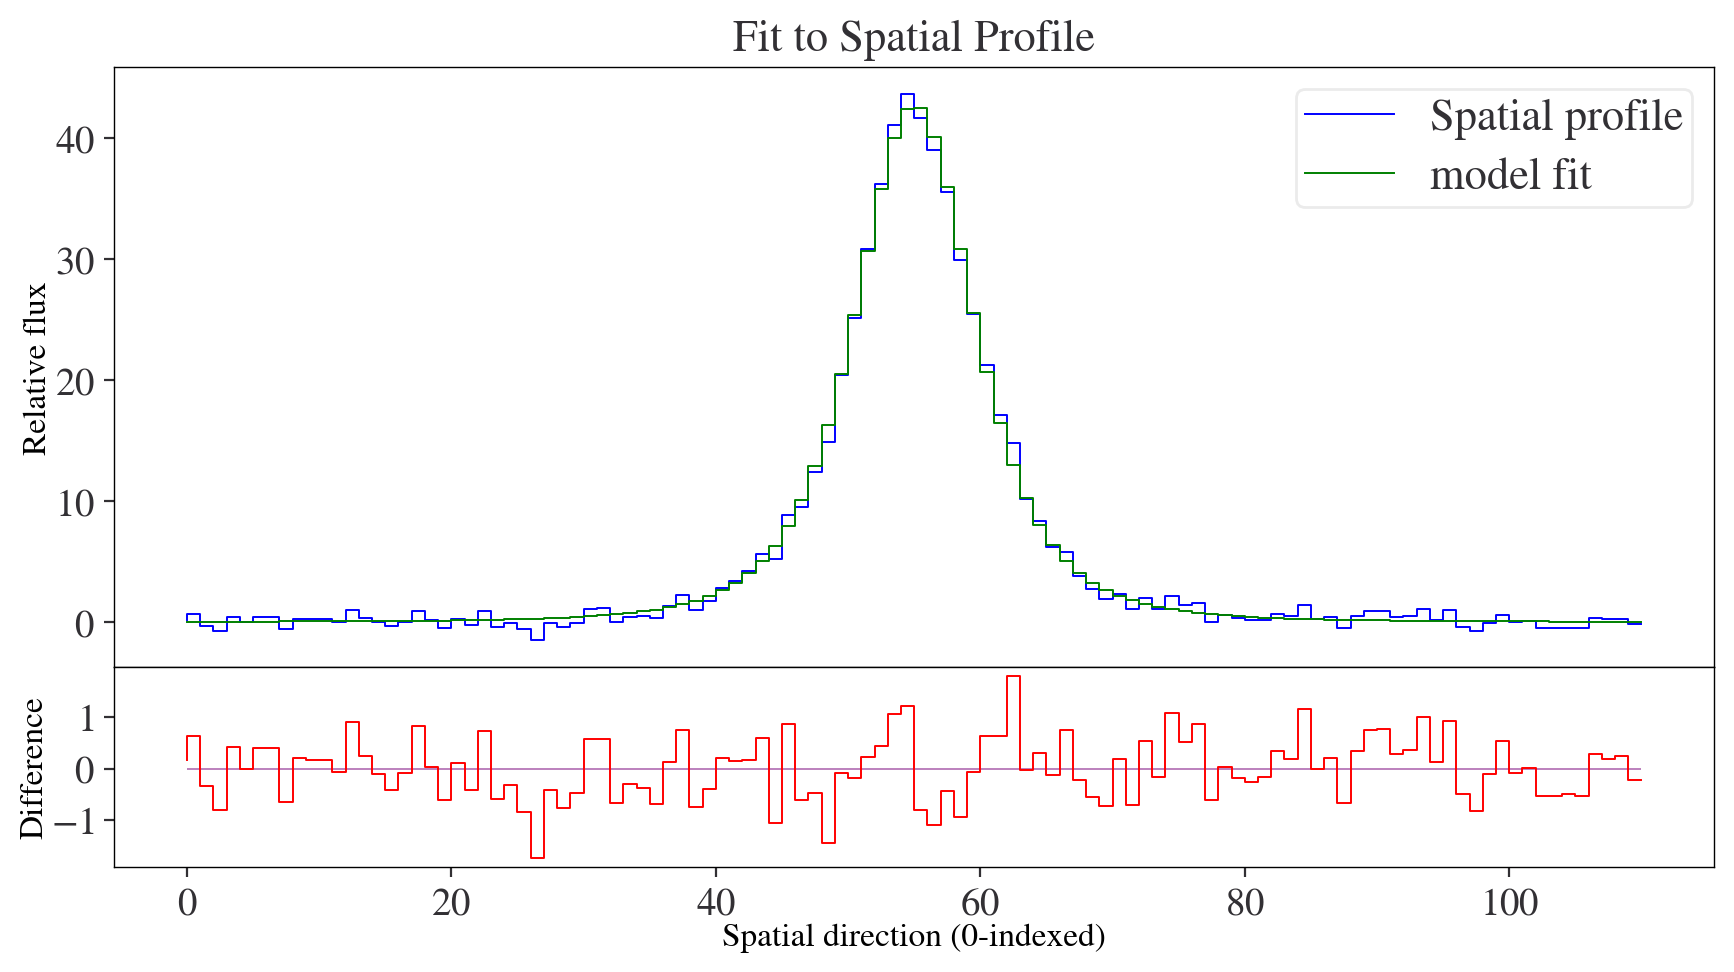

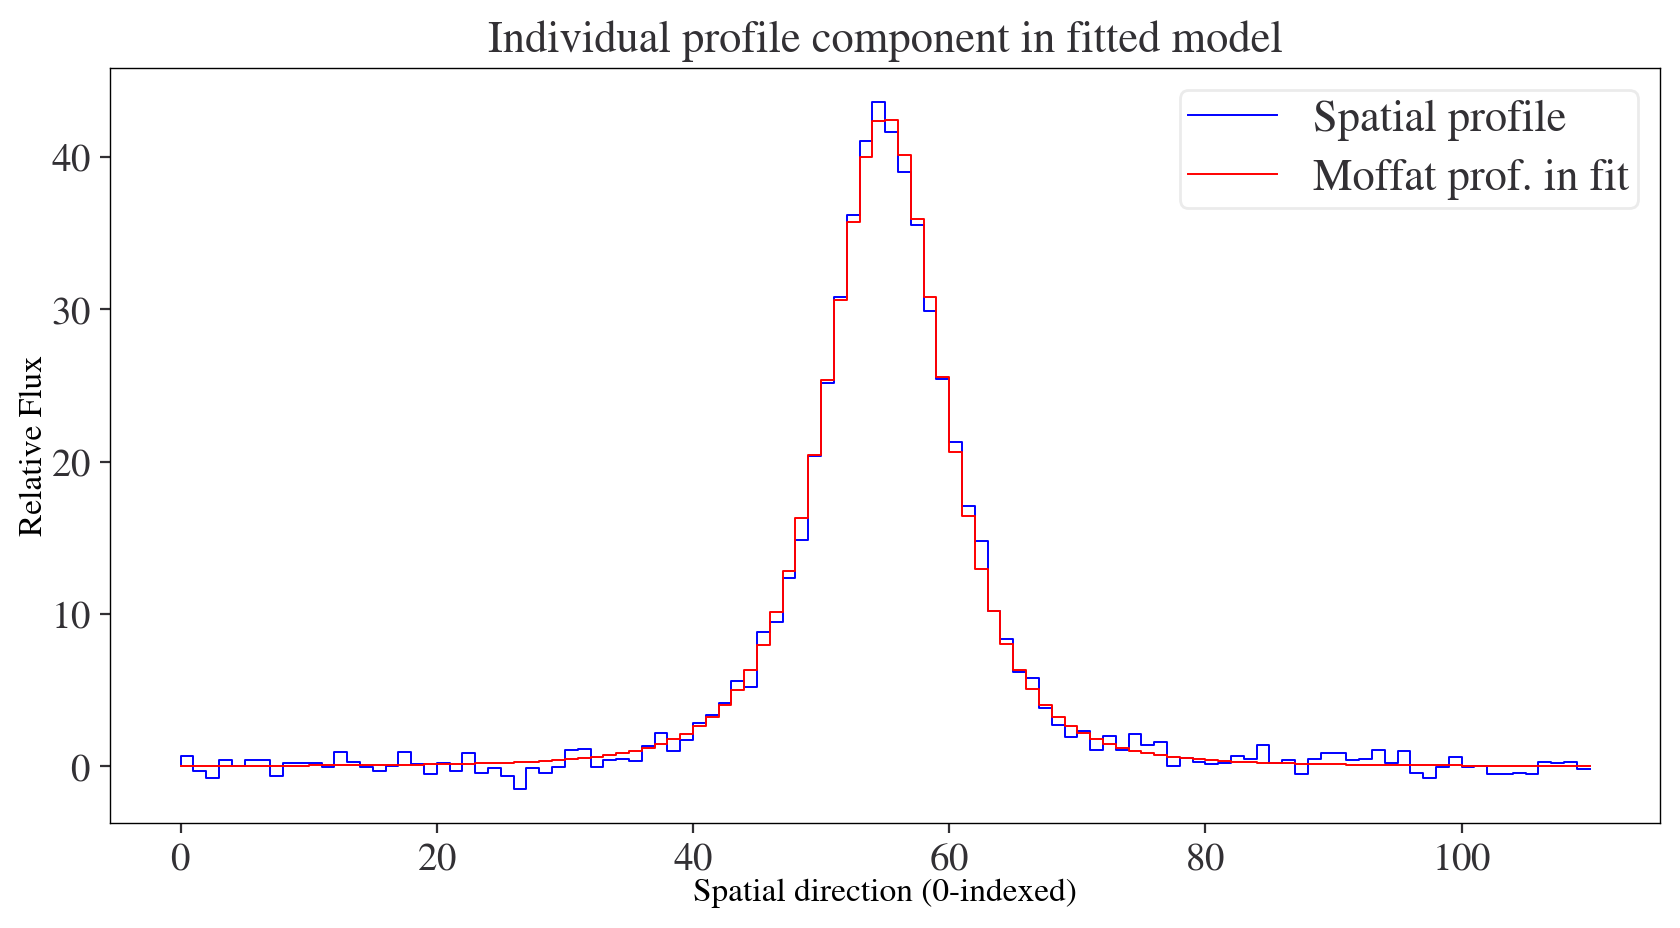


Do you want to start over ? : type yes/no
no


In [33]:
# B0631
spec3 = spec2d.Spec2d(file_list[2], hext=1, varext=2, xtrim=[25, 135])

spec3.set_dispaxis('y')
#plt.show()
spec3.do_waverect(doplot=False, resamp_ord=1, wavext=4)
spec3.spatial_profile(pixrange=[1700, 2401])
plt.show()
mod3 = spec3.initial_model()

In [34]:
## get noise data in median pixel
d, v = spec3.data.T[:, 1700:2401], spec3.vardata.T[:, 1700:2401]
l = d.shape[1]
median_array = []
median_indx = []
B0631_var = []

In [35]:
for i in range(d.shape[0]):
    s = np.argsort(d[i])[l//2]
    #print(s)
    median_array.append(d[i][s])
    median_indx.append(s)
    B0631_var.append(v[i][s])

In [36]:
print(np.sum(spec3.profile['flux'] - np.array(median_array)))
print(np.sum(np.array(B0631_var)<0))

0.0
0


In [39]:
B0631_mad = stats.median_abs_deviation(d, axis=1)
B0631_mad

array([6.8844724, 7.001909 , 6.232765 , 7.358078 , 6.649566 , 7.0730276,
       6.805113 , 6.8262386, 7.0512156, 6.5922904, 6.6895394, 7.142002 ,
       6.6008954, 7.2935953, 7.294523 , 6.971959 , 7.6975236, 7.1021037,
       7.4489665, 6.8022404, 7.001238 , 6.4410477, 6.5860863, 7.549908 ,
       6.6771116, 7.578055 , 6.9336925, 6.867735 , 6.3367267, 6.8716702,
       6.6211495, 6.9713535, 6.9803877, 7.739326 , 7.1871443, 6.9256268,
       6.784217 , 6.5753765, 7.468359 , 7.6908813, 7.344496 , 7.712528 ,
       6.9739647, 7.2913313, 7.467389 , 7.9458036, 7.315203 , 7.322006 ,
       7.492938 , 7.240629 , 7.50189  , 8.360762 , 7.874813 , 8.880173 ,
       8.907497 , 9.879059 , 9.468948 , 9.446114 , 9.140894 , 8.736263 ,
       9.318605 , 7.994381 , 7.988693 , 7.6923685, 7.5076423, 6.9126034,
       7.5437474, 6.8764806, 6.9214935, 7.4405775, 6.9858303, 6.678266 ,
       7.3926344, 6.5139513, 7.025488 , 7.0333176, 6.583557 , 6.5287957,
       7.093031 , 7.489606 , 6.9052625, 7.5185175, 


Loading file ../spectra_extraction/J0659_LRIS_spectra/J0659_coadd2d_sp.fits
-----------------------------------------------

Loading file ../spectra_extraction/J0659_LRIS_spectra/J0659_coadd2d_var.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/J0659_LRIS_spectra/J0659_coadd2d_sp.fits (HDU=0)
Final data dimensions (x y): 4096 x 61

Dispersion axis:              x
N_pixels along dispersion axis: 4096

Profile max value (before normalization) 599.591153


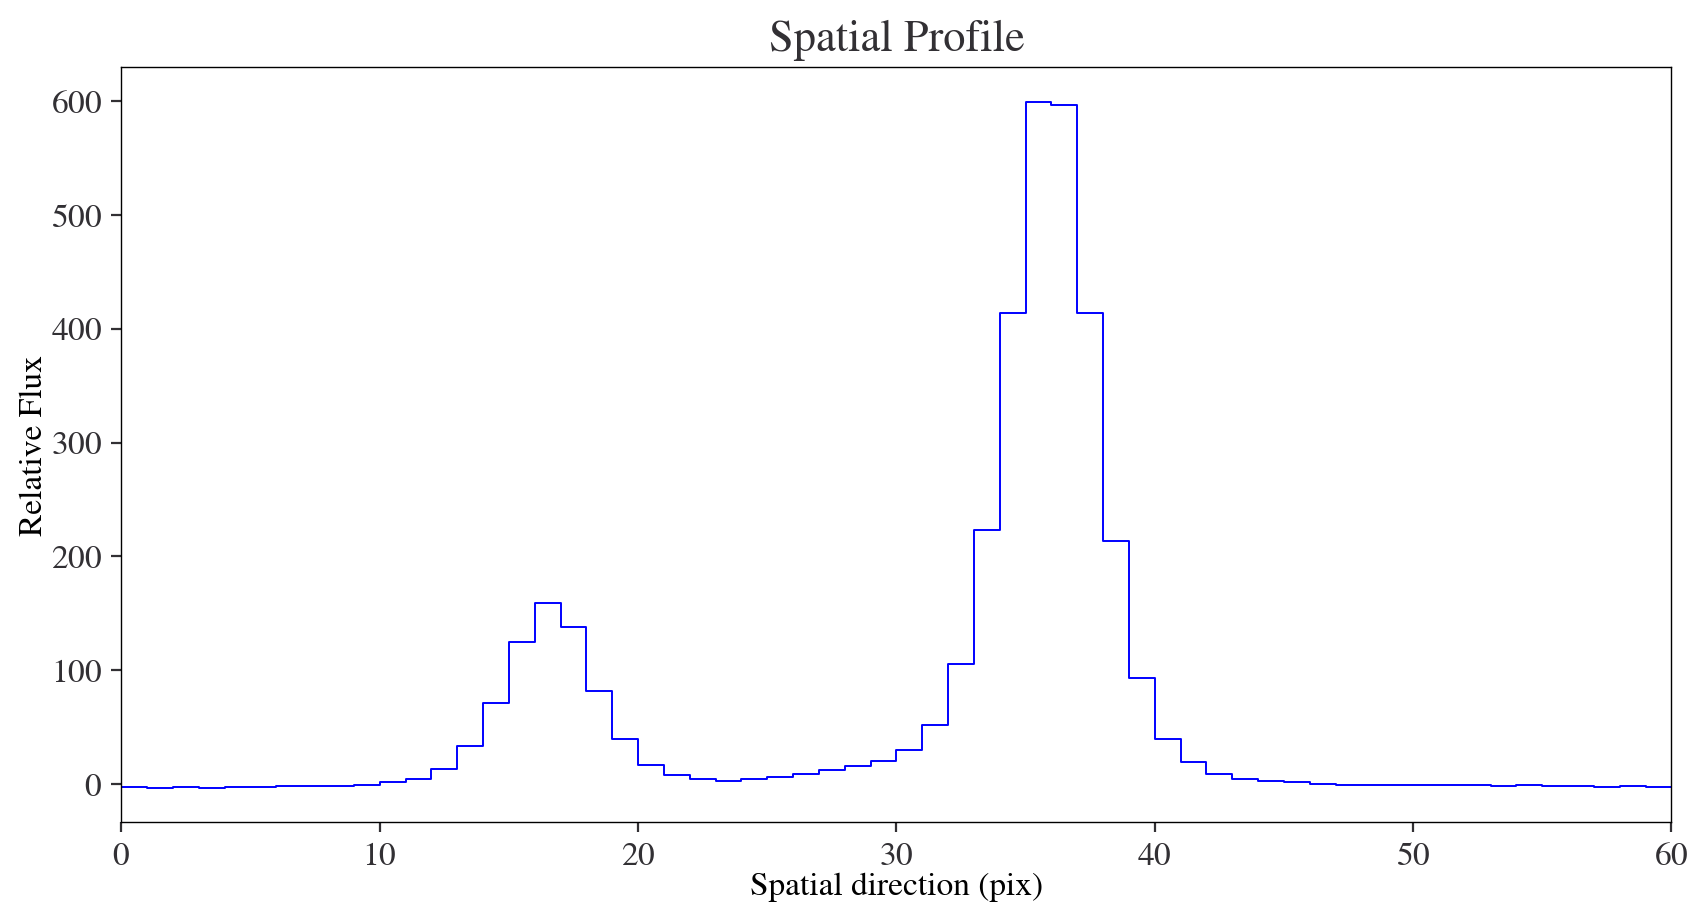


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 3

Now enter constants of the background polynomial upto degree 0
c0 : -2

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 335, 37, 3, 4

amplitude=335.000000, x_0=37.000000, gamma=3.000000, alpha=4.000000

Parameters of Moffat profile 2 : 15, 29, 2, 3

amplitude=15.000000, x_0=29.000000, gamma=2.000000, alpha=3.000000

Parameters of Moffat profile 3 : 95, 17, 3, 4

amplitude=95.000000, x_0=17.000000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=19.28763256)>

    [1]: <Moffat1D(amplitude=629.

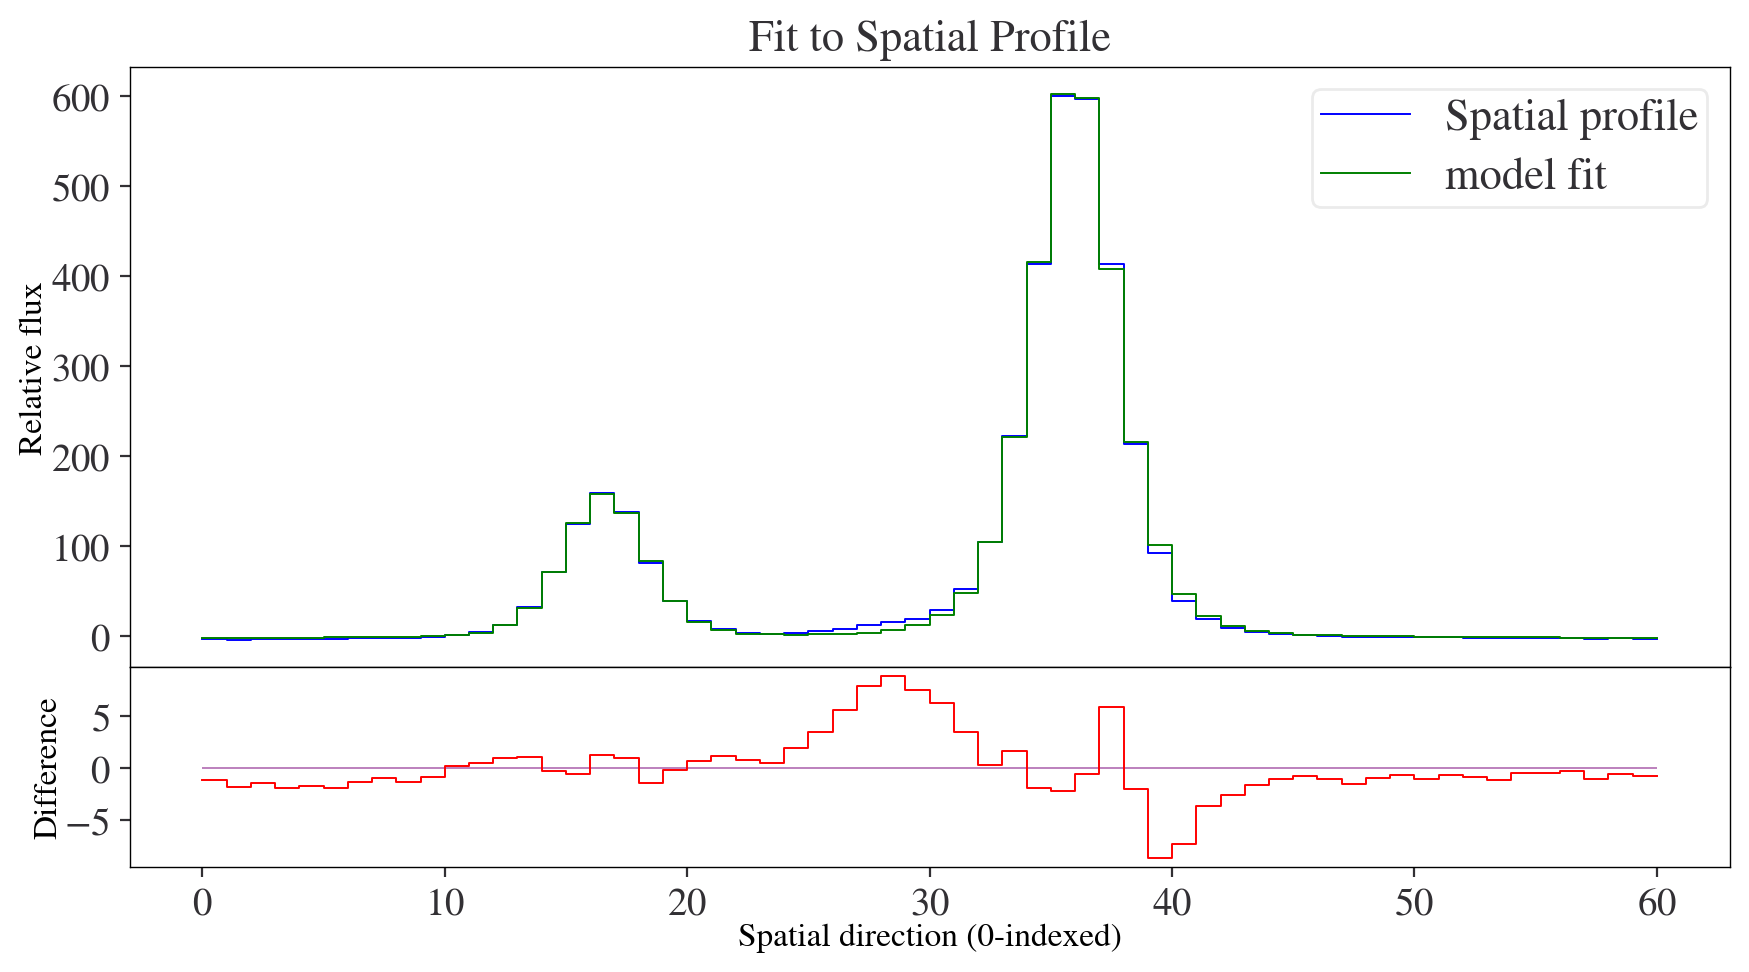

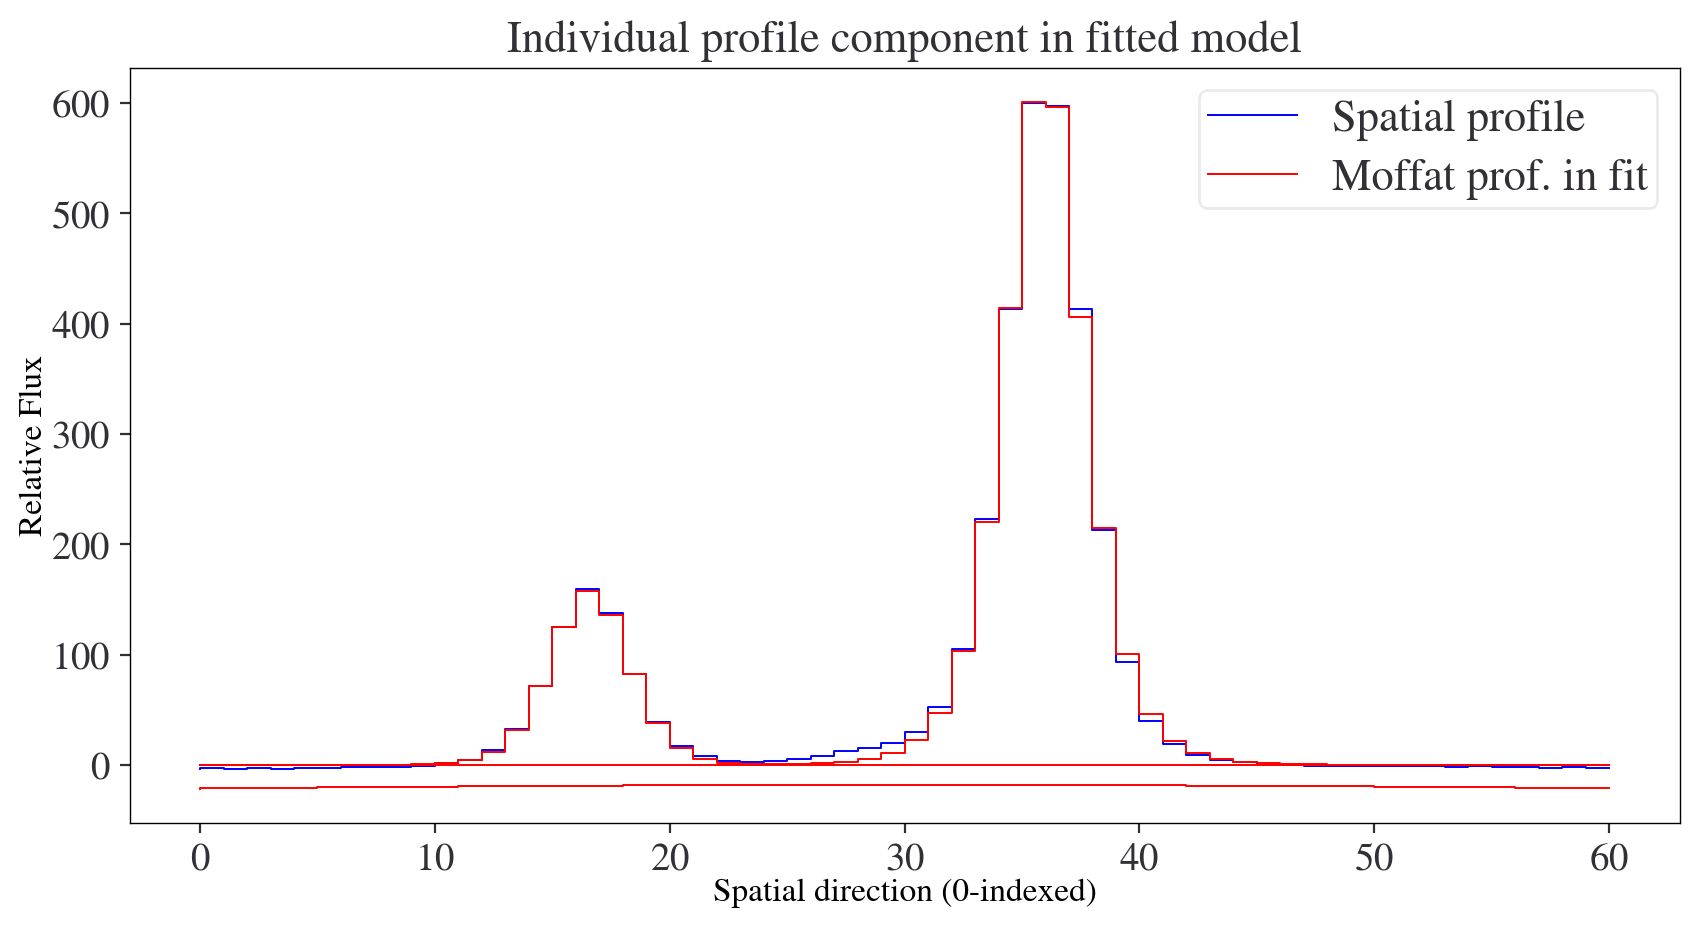


Do you want to start over ? : type yes/no
no


<CompoundModel(c0_0=19.28763256, amplitude_1=629.59713282, x_0_1=36.48197294, gamma_1=3.8228763, alpha_1=2.98899074, amplitude_2=-17.99416594, x_0_2=30.87711317, gamma_2=48.85966337, alpha_2=-0.51925046, amplitude_3=157.85576283, x_0_3=17.11073283, gamma_3=5.43884793, alpha_3=5.67304377)>

In [40]:
#J0659
spec4 = spec2d.Spec2d(inspec=file_list[3], invar=var_file_list[3])
spec4.spatial_profile(pixrange=[1800, 2301])
plt.show()
spec4.initial_model()


Initial model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=19.28763256)>

    [1]: <Moffat1D(amplitude=629.59713282, x_0=36.48197294, gamma=3.8228763, alpha=2.98899074)>

    [2]: <Moffat1D(amplitude=-17.99416594, x_0=30.87711317, gamma=48.85966337, alpha=-0.51925046)>

    [3]: <Moffat1D(amplitude=157.85576283, x_0=17.11073283, gamma=5.43884793, alpha=5.67304377)>
Parameters:
           c0_0           amplitude_1    ...      gamma_3            alpha_3      
    ------------------ ----------------- ... ------------------ ------------------
    19.287632558250085 629.5971328248527 ... 5.4388479259568765 5.6730437744971205

-------------------------------------------


Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=-1.85223567)>

    [1]: <Moffat1D(a

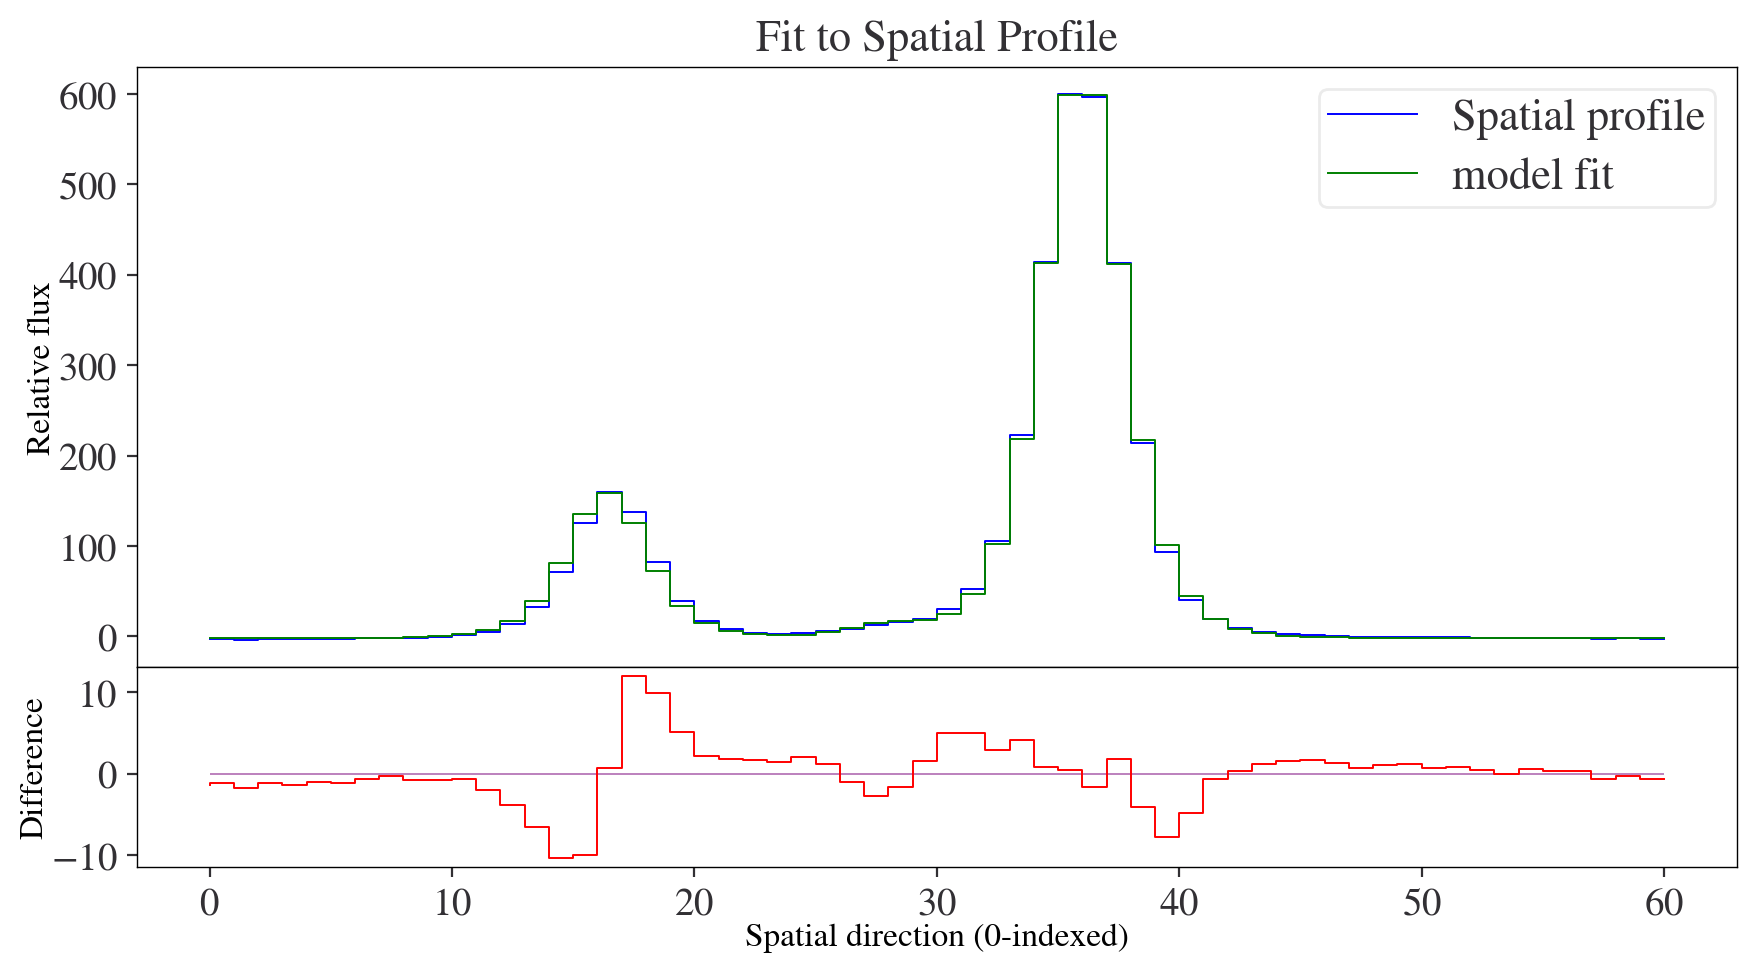

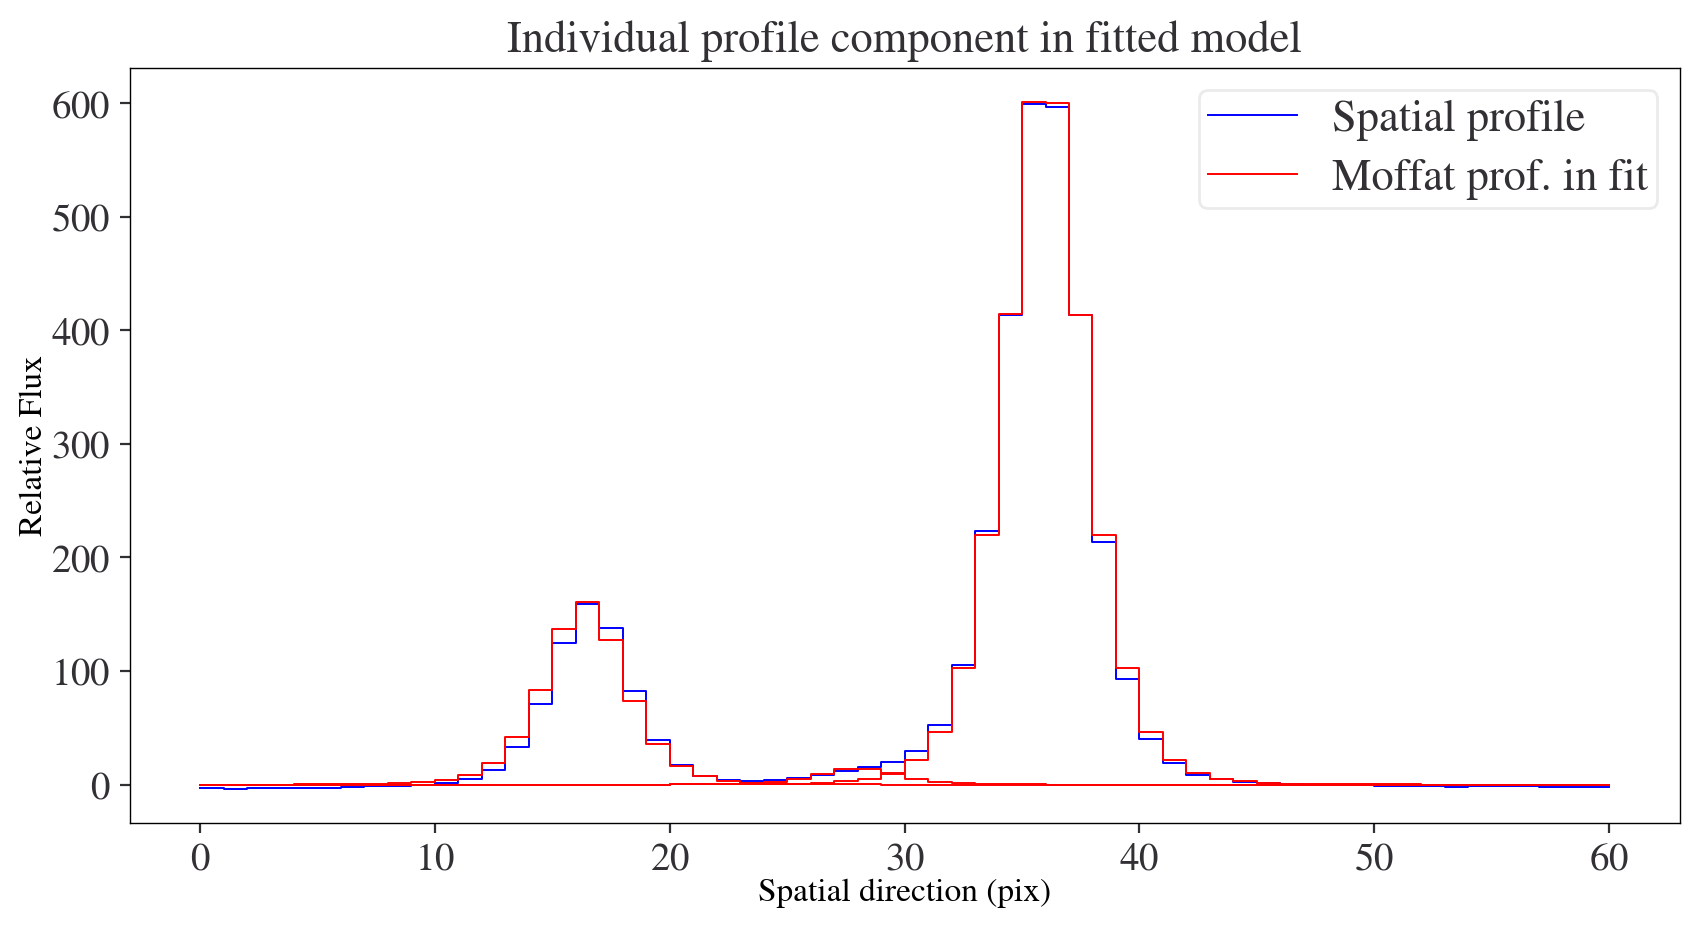

In [41]:
def tie_pos1_moffat(model):
    return model.x_0_1 - (2.16 / 0.270)

def tie_pos2_moffat(model):
    return model.x_0_1 - (5.29 / 0.270) 

def tie_gamma_moffat(model):
    return model.gamma_1

def tie_alpha_moffat(model):
    return model.alpha_1 

spec4.mod0[2].x_0.tied = tie_pos1_moffat
spec4.mod0[3].x_0.tied = tie_pos2_moffat
spec4.mod0[2].gamma.tied = tie_gamma_moffat
spec4.mod0[2].alpha.tied = tie_alpha_moffat
spec4.mod0[3].gamma.tied = tie_gamma_moffat
spec4.mod0[3].alpha.tied = tie_alpha_moffat
mod4 = spec4.refined_model(spec4.mod0)

In [42]:
## get noise data in median pixel
d, v = spec4.data[:, 1800:2301], spec4.vardata[:, 1800:2301]
l = d.shape[1]
median_array, median_indx, J0659_var = [], [], []

In [43]:
for i in range(d.shape[0]):
    s = np.argsort(d[i])[l//2]
    #print(s)
    median_array.append(d[i][s])
    median_indx.append(s)
    J0659_var.append(v[i][s])

In [44]:
print(np.sum(spec4.profile['flux'] - np.array(median_array)))
print(np.sum(np.array(J0659_var)<0))

0.0
0


In [45]:
J0659_mad = stats.median_abs_deviation(d, axis=1)
J0659_mad

array([  3.11861245,   3.01775748,   3.09944267,   3.27592926,
         2.99350091,   2.79014009,   2.82264516,   2.74915028,
         2.44064073,   2.5990069 ,   2.3571427 ,   2.40948774,
         2.70354233,   3.34506669,   6.05810692,  12.6384326 ,
        21.82008237,  28.35310362,  22.6835622 ,  13.62598655,
         6.57392743,   3.8123886 ,   2.95176774,   2.58780738,
         2.61653749,   2.43589112,   2.55241249,   2.57420705,
         2.6421694 ,   2.80393725,   3.29028543,   5.18879186,
        10.04418638,  20.50970943,  42.49949549,  78.26685836,
       105.94213537, 103.23692314,  71.57410816,  36.57693366,
        16.50929141,   7.16823435,   3.76220501,   2.84613448,
         2.57557558,   2.48807584,   2.56940389,   2.30205159,
         2.35327569,   2.29997492,   2.42355669,   2.76961152,
         2.38753261,   2.78971542,   3.27008924,   3.0762666 ,
         3.1226884 ,   3.49354456,   2.88076763,   3.34740954,
         3.72182152])


Loading file ../spectra_extraction/J0818_ESI_spectra/J0818_coadd2d_sp_order_9.fits
-----------------------------------------------

Loading file ../spectra_extraction/J0818_ESI_spectra/J0818_coadd2d_var_order_9.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/J0818_ESI_spectra/J0818_coadd2d_sp_order_9.fits (HDU=0)
Final data dimensions (x y): 4096 x 116

Dispersion axis:              x
N_pixels along dispersion axis: 4096

Profile max value (before normalization) 916.892696


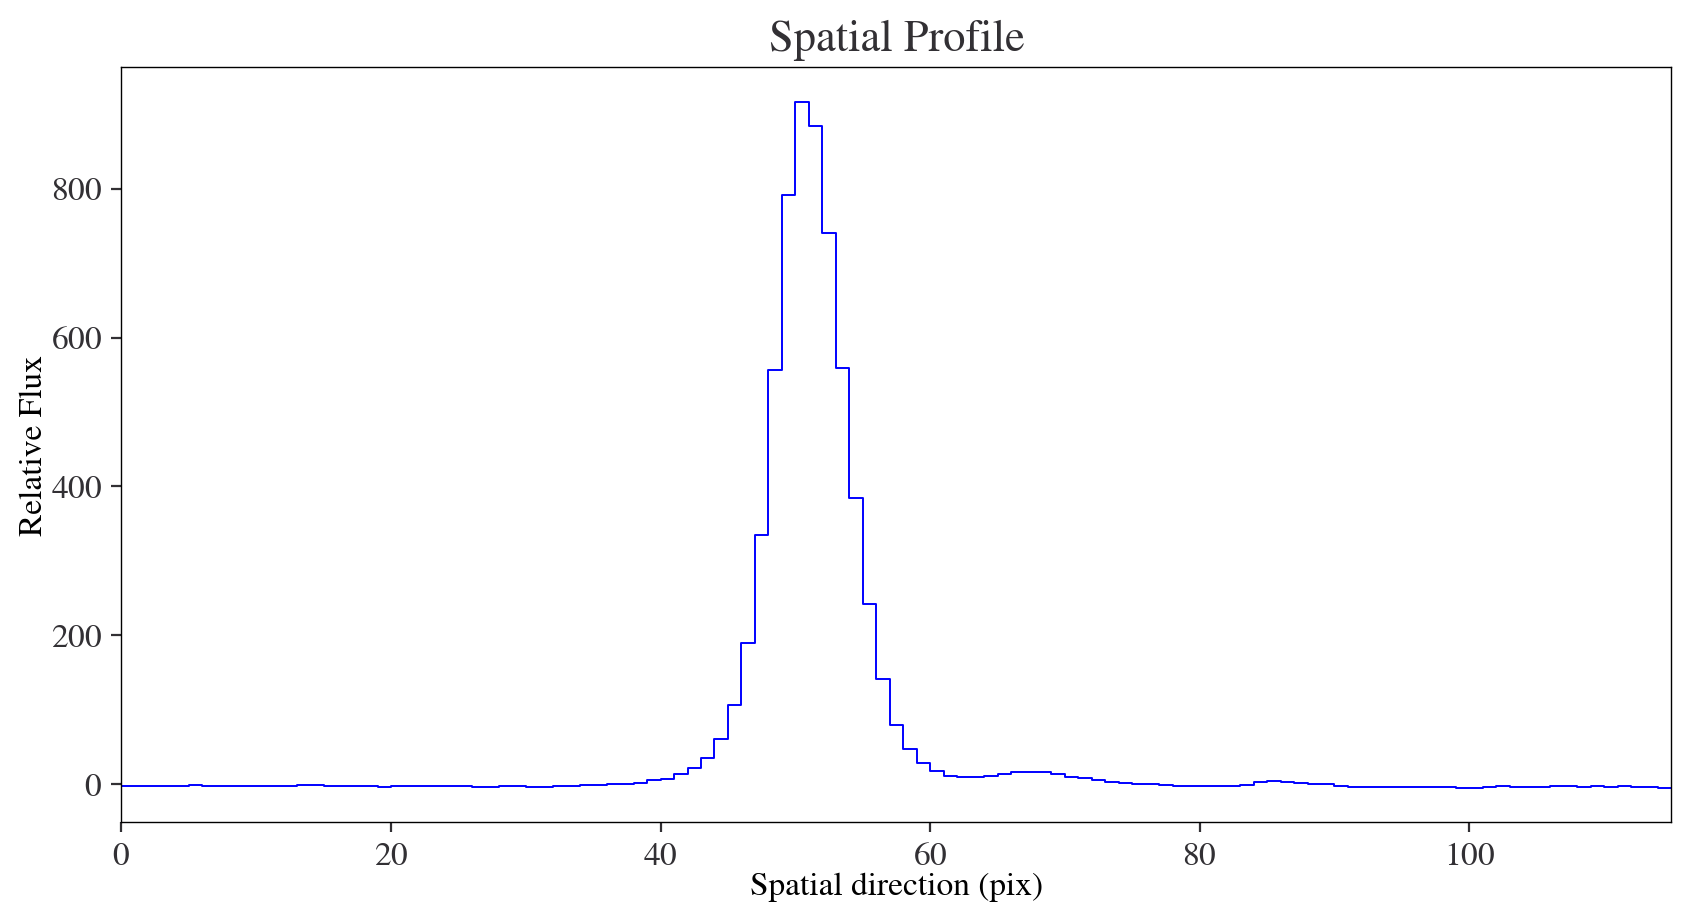


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 2

Now enter constants of the background polynomial upto degree 0
c0 : -1

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 900, 50.5, 3, 4

amplitude=900.000000, x_0=50.500000, gamma=3.000000, alpha=4.000000

Parameters of Moffat profile 2 : 30, 67.7, 2, 3

amplitude=30.000000, x_0=67.700000, gamma=2.000000, alpha=3.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Polynomial1D(0, c0=-6.02714997)>

    [1]: <Moffat1D(amplitude=927.82743909, x_0=51.51490373, gamma=5.94184879, alpha=3.1805997)>

    [2]: <Moffat1D(amplitude=18.04275501, x_0=67.5277

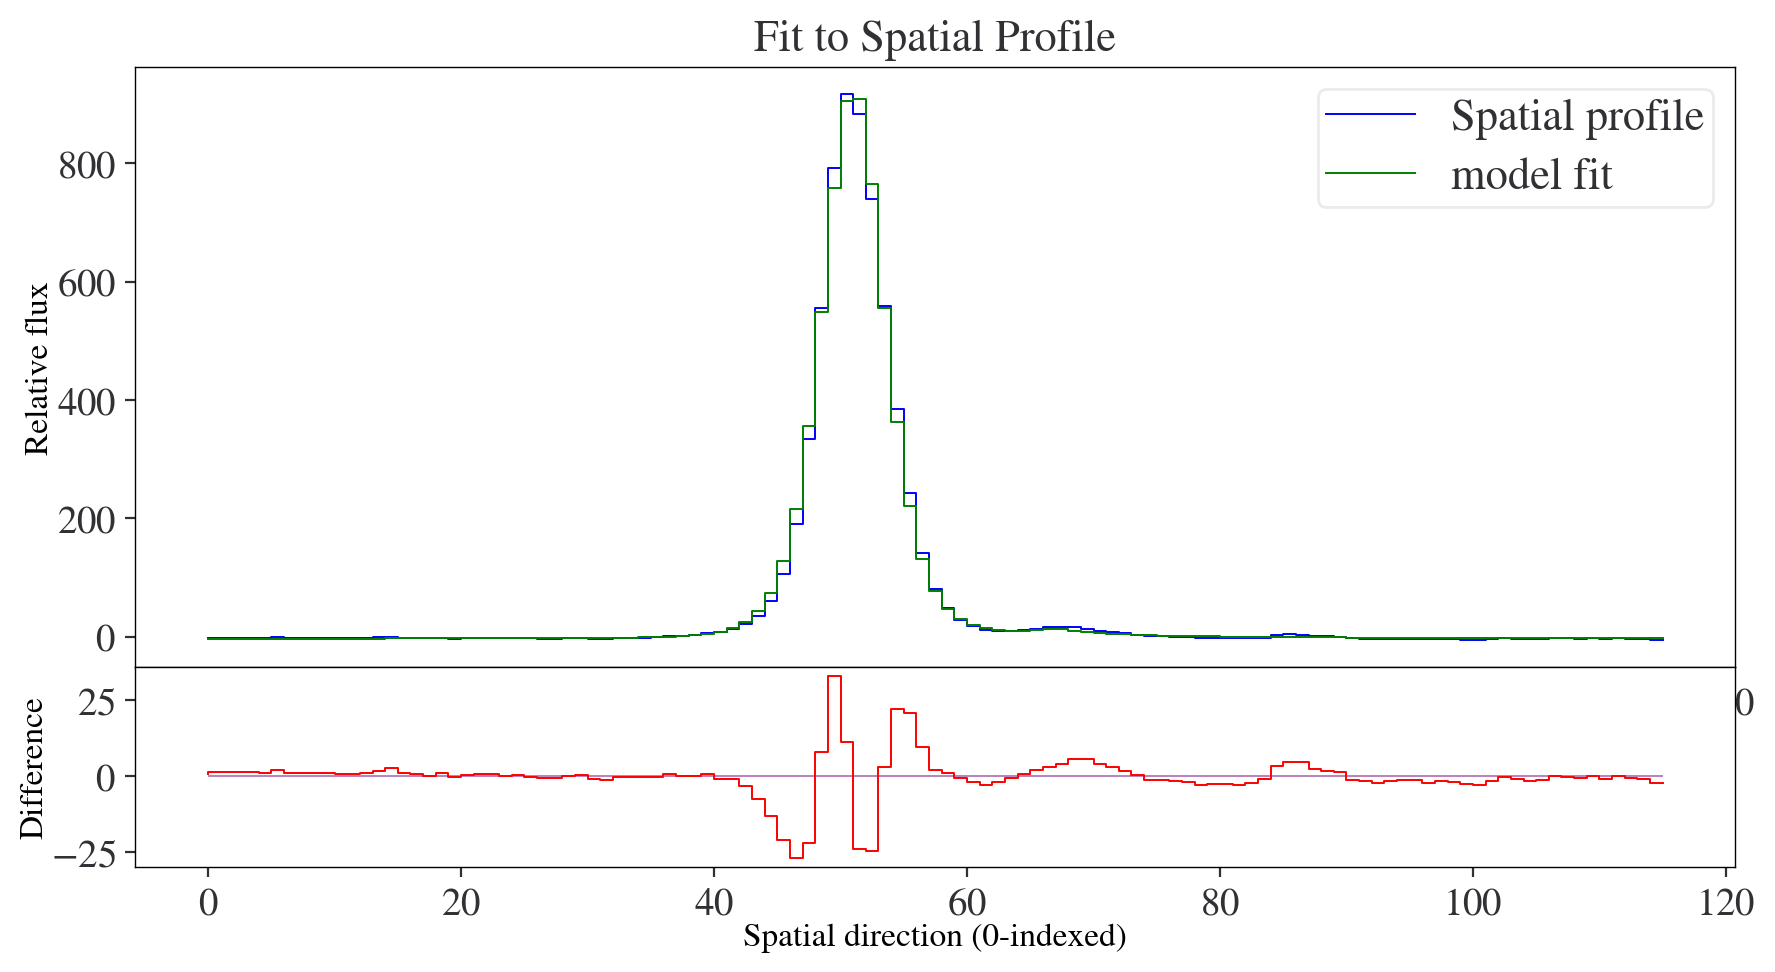

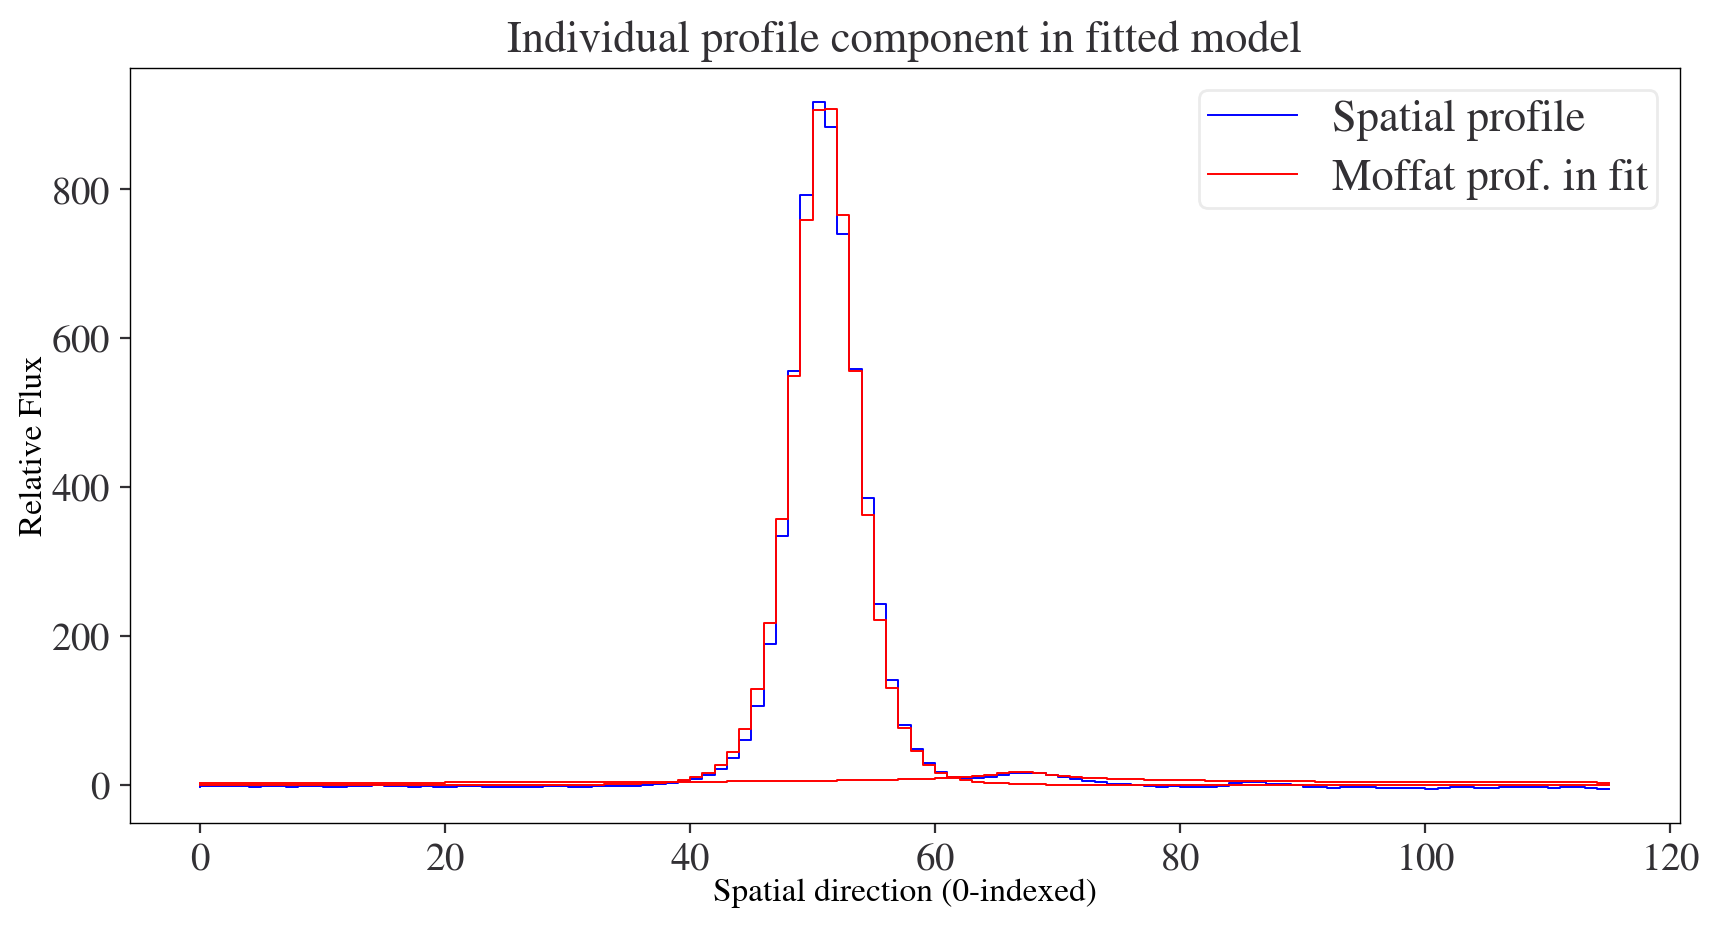


Do you want to start over ? : type yes/no
no


<CompoundModel(c0_0=-6.02714997, amplitude_1=927.82743909, x_0_1=51.51490373, gamma_1=5.94184879, alpha_1=3.1805997, amplitude_2=18.04275501, x_0_2=67.52774133, gamma_2=1.78952685, alpha_2=0.26376319)>

In [46]:
#J0818
spec5 = spec2d.Spec2d(inspec=file_list[4], invar=var_file_list[4])
spec5.spatial_profile(pixrange=[1600, 2301])
plt.show()
spec5.initial_model()


Initial model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Polynomial1D(0, c0=-6.02714997)>

    [1]: <Moffat1D(amplitude=927.82743909, x_0=51.51490373, gamma=5.94184879, alpha=3.1805997)>

    [2]: <Moffat1D(amplitude=18.04275501, x_0=67.52774133, gamma=1.78952685, alpha=0.26376319)>
Parameters:
           c0_0           amplitude_1    ...      gamma_2             alpha_2      
    ------------------ ----------------- ... ------------------ -------------------
    -6.027149972699993 927.8274390945328 ... 1.7895268506547524 0.26376318784617325

-------------------------------------------


Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Polynomial1D(0, c0=-1.81166813)>

    [1]: <Moffat1D(amplitude=925.12471921, x_0=51.5238831, gamma=6.41320166, alpha=3.58695259)>

    [2]: <Moffat1D(amplitude=22.7

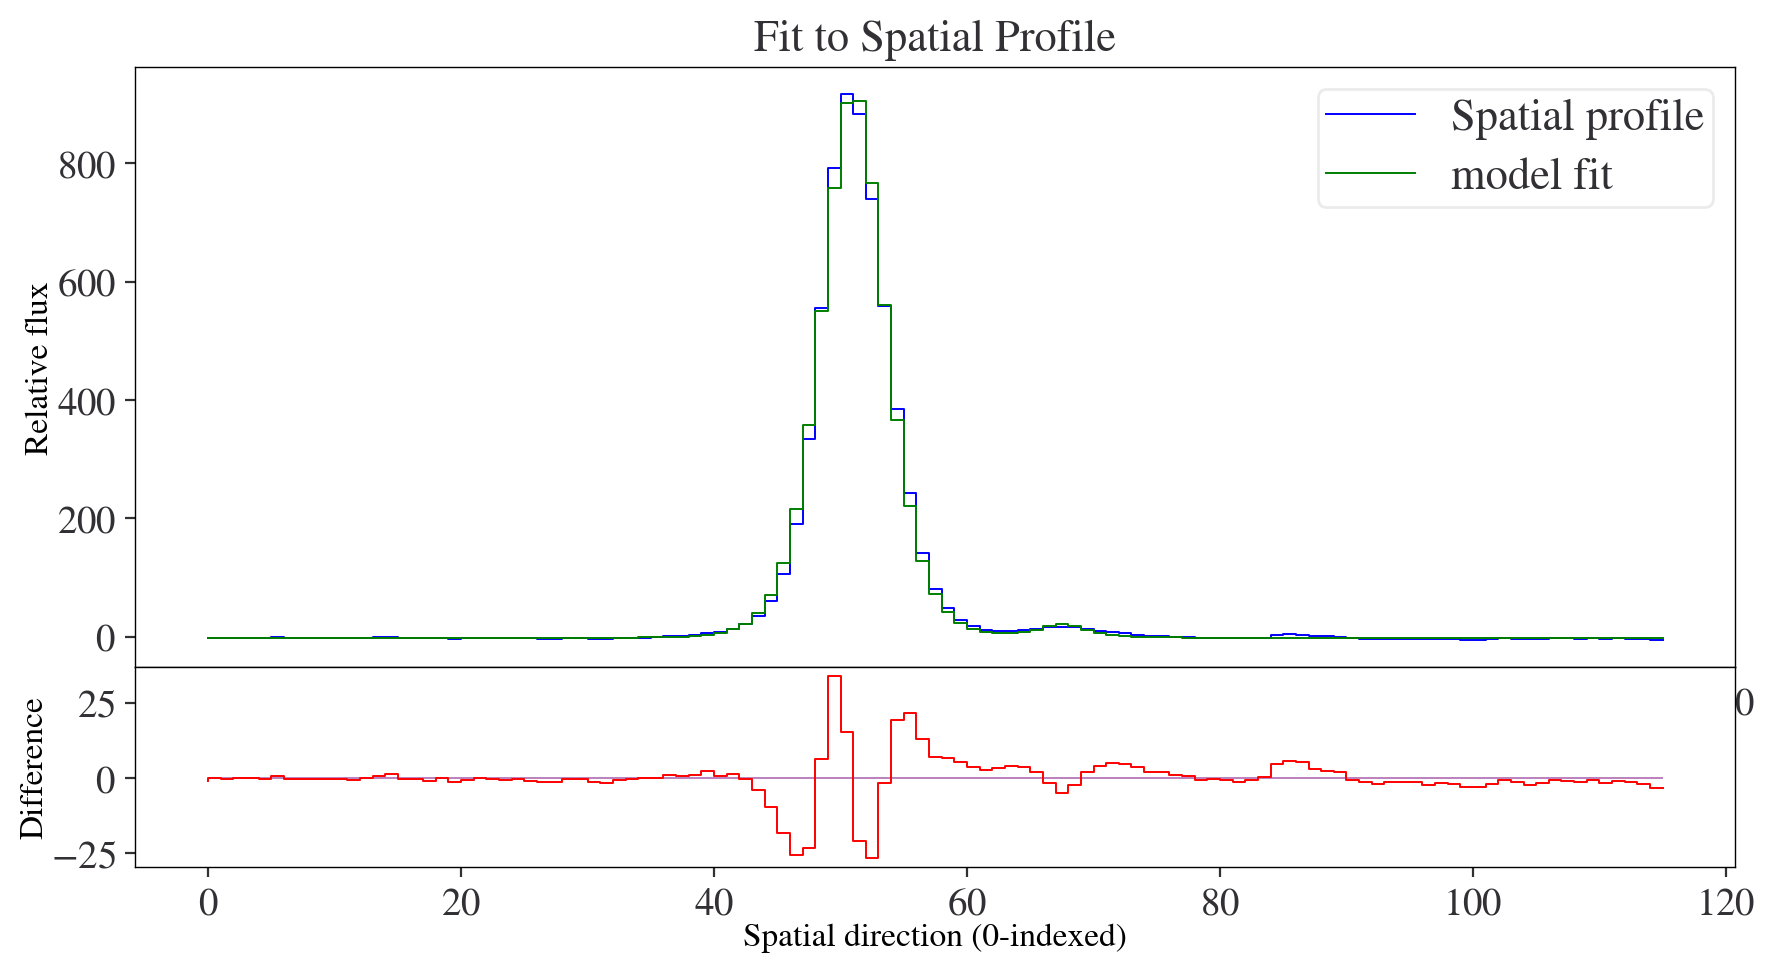

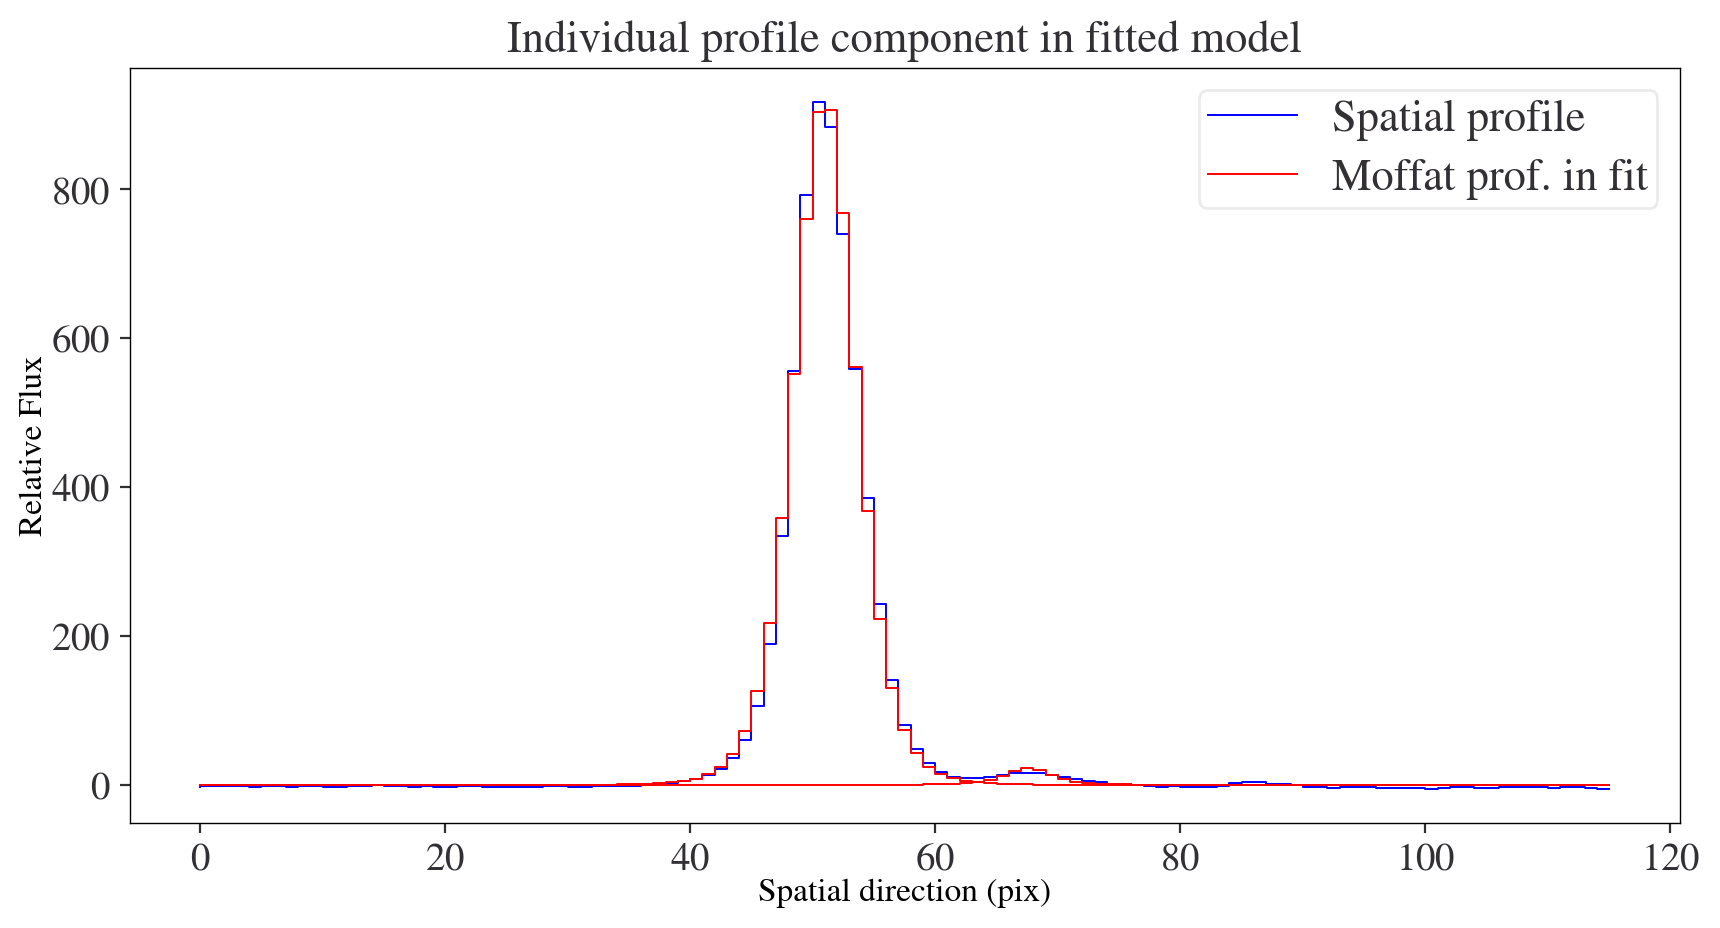

In [47]:
def tie_pos1_moffat_9(model):
    return model.x_0_1 + (2.7  /  pixscale[0])  

def tie_gamma_moffat1(model):
    return model.gamma_1 * 0.5

def tie_alpha_moffat1(model):
    return model.alpha_1 * 0.5

func_dict = {'9_1' : tie_pos1_moffat_9}

pixscale = [0.163]
ord_list = [9]

spec5.mod0[2].x_0.tied = func_dict['%d_%d' %(ord_list[0], 1)] #tie_pos1_moffat
#spec3.mod0[3].x_0.tied = func_dict['%d_%d' %(ord_list[0], 2)] #tie_pos2_moffat
#spec3.mod0[1].gamma.tied = tie_gamma_moffat
#spec3.mod0[1].alpha.tied = tie_alpha_moffat
spec5.mod0[2].gamma.tied = tie_gamma_moffat1
spec5.mod0[2].alpha.tied = tie_alpha_moffat1
mod5 = spec5.refined_model(spec5.mod0)

In [48]:
## get noise data in median pixel
d, v = spec5.data[:, 1600:2301], spec5.vardata[:, 1600:2301]
l = d.shape[1]
median_array, median_indx, J0818_var = [], [], []

In [49]:
for i in range(d.shape[0]):
    s = np.argsort(d[i])[l//2]
    #print(s)
    median_array.append(d[i][s])
    median_indx.append(s)
    J0818_var.append(v[i][s])

In [50]:
print(np.sum(spec5.profile['flux'] - np.array(median_array)))
print(np.sum(np.array(J0818_var)<0))

0.0
0


In [51]:
J0818_mad = stats.median_abs_deviation(d, axis=1)
J0818_mad

array([ 4.34279399,  3.84645203,  4.28859681,  3.95288573,  4.37707748,
        4.15845494,  4.28642865,  4.16307661,  3.94230108,  4.47768743,
        4.22203257,  4.14213033,  4.49868829,  4.11743305,  4.34404365,
        4.43691615,  4.37821786,  4.42571916,  4.09625169,  4.11378696,
        4.41717566,  4.06017936,  4.41746921,  4.28399904,  4.45956045,
        4.31613733,  4.13096415,  4.11713169,  4.52193623,  4.22850798,
        4.31296208,  4.04494149,  4.17301423,  4.27184138,  3.87094245,
        4.22653502,  4.11223206,  4.12194222,  4.43118452,  4.51374086,
        4.96068227,  4.91250572,  4.70431761,  5.05190037,  6.12097435,
        7.04118427,  9.11866179, 12.58727737, 19.58080571, 30.59218963,
       51.56142969, 71.66469673, 76.01402807, 66.14456447, 53.87036659,
       40.32536726, 26.01549878, 17.10040424, 10.23875351,  7.48901555,
        6.0206714 ,  5.77886658,  5.28446255,  4.71819211,  4.43954028,
        4.84397321,  4.56283293,  5.13775219,  4.7101197 ,  4.93


Loading file ../spectra_extraction/J0924_ESI_spectra/J0924_coadd2d_sp_order_4.fits
-----------------------------------------------

Loading file ../spectra_extraction/J0924_ESI_spectra/J0924_coadd2d_var_order_4.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/J0924_ESI_spectra/J0924_coadd2d_sp_order_4.fits (HDU=0)
Final data dimensions (x y): 4096 x 141

Dispersion axis:              x
N_pixels along dispersion axis: 4096

Profile max value (before normalization) 255.576814


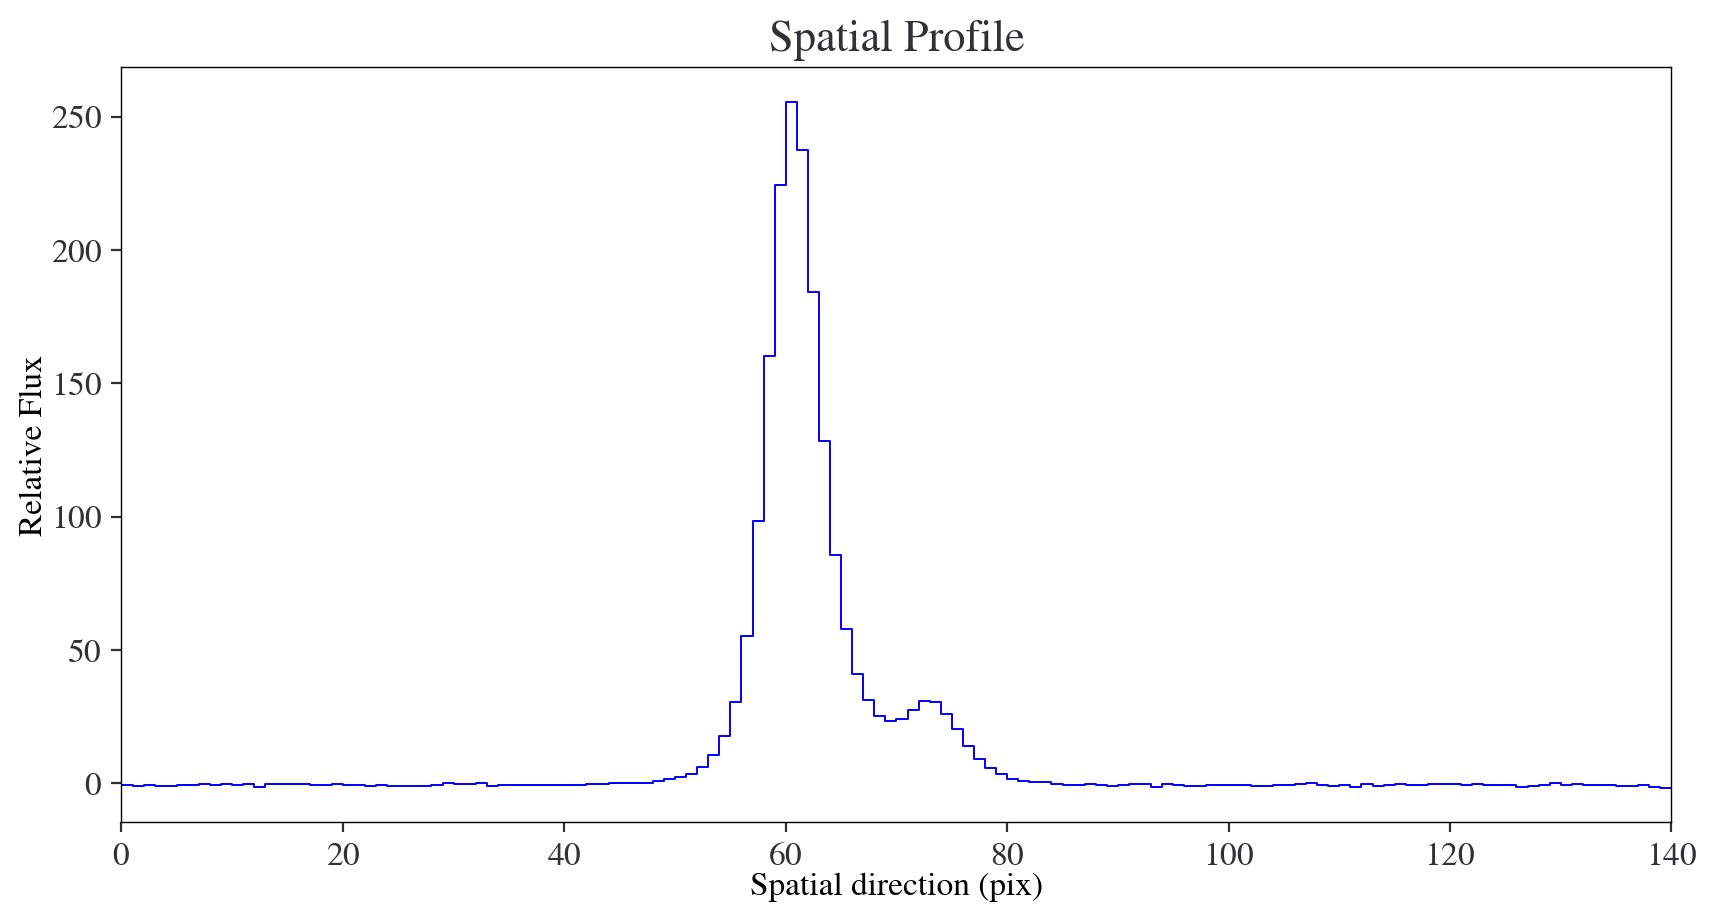


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 3

Now enter constants of the background polynomial upto degree 0
c0 : -2

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 260, 61, 3, 4

amplitude=260.000000, x_0=61.000000, gamma=3.000000, alpha=4.000000

Parameters of Moffat profile 2 : 25, 67.5, 2,3

amplitude=25.000000, x_0=67.500000, gamma=2.000000, alpha=3.000000

Parameters of Moffat profile 3 : 40, 74, 3, 4

amplitude=40.000000, x_0=74.000000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=-1.61739138)>

    [1]: <Moffat1D(amplitude=253

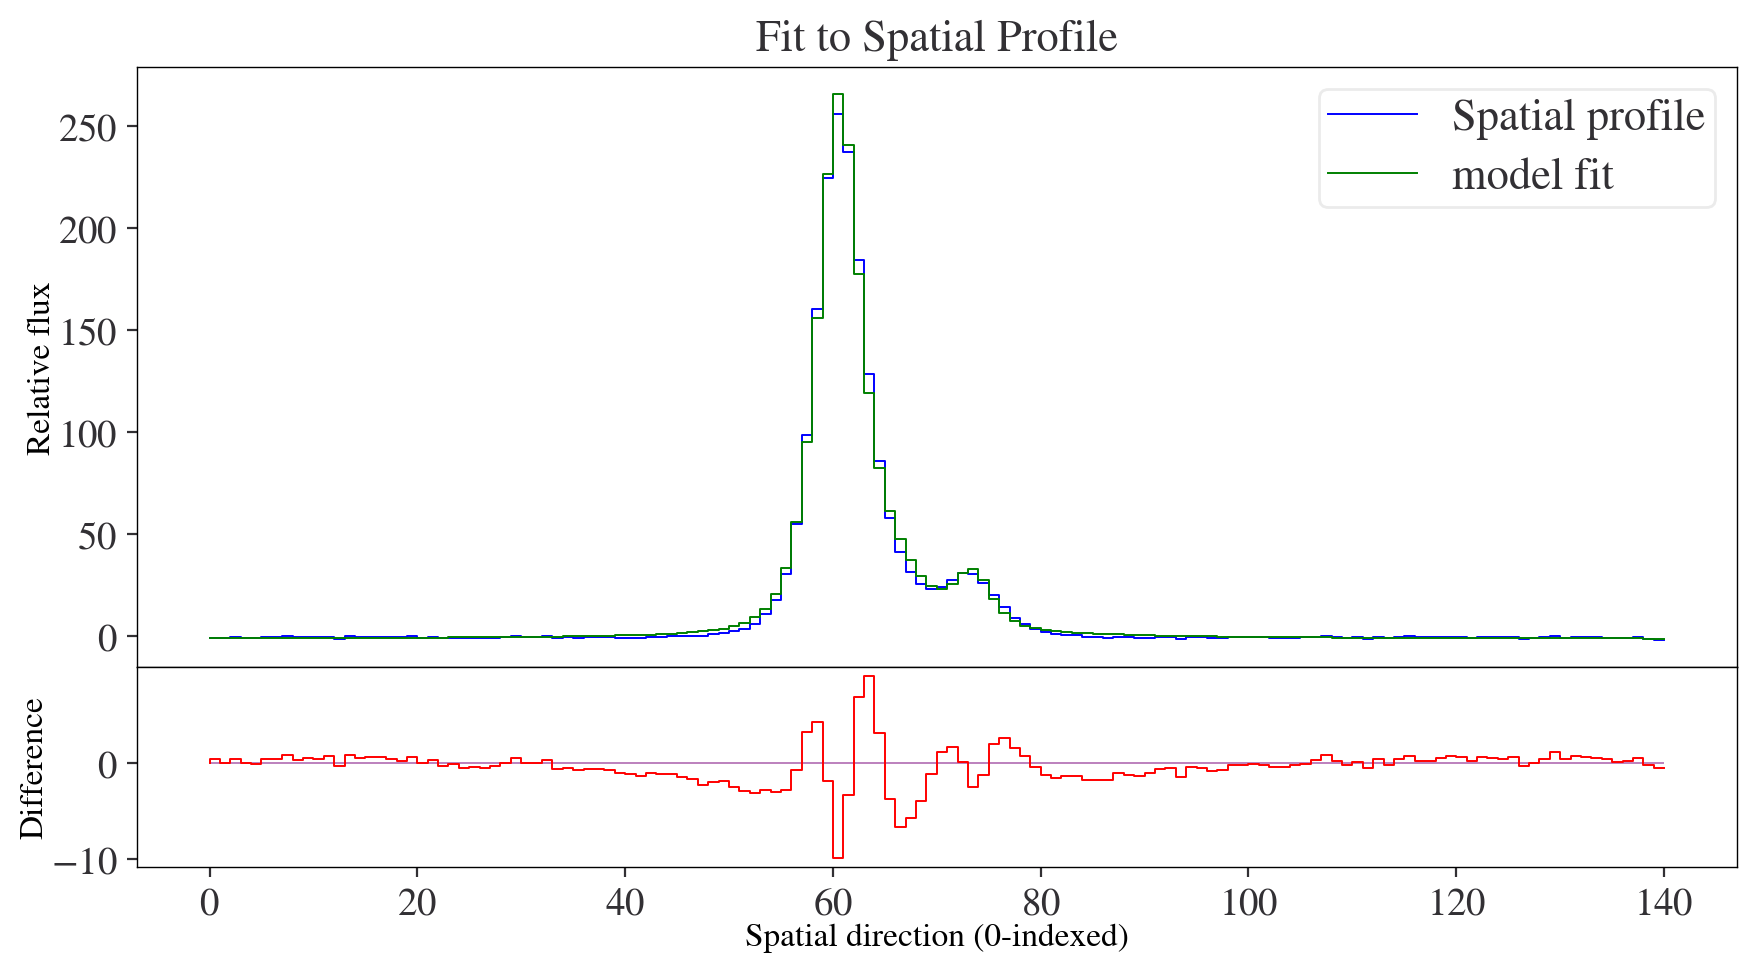

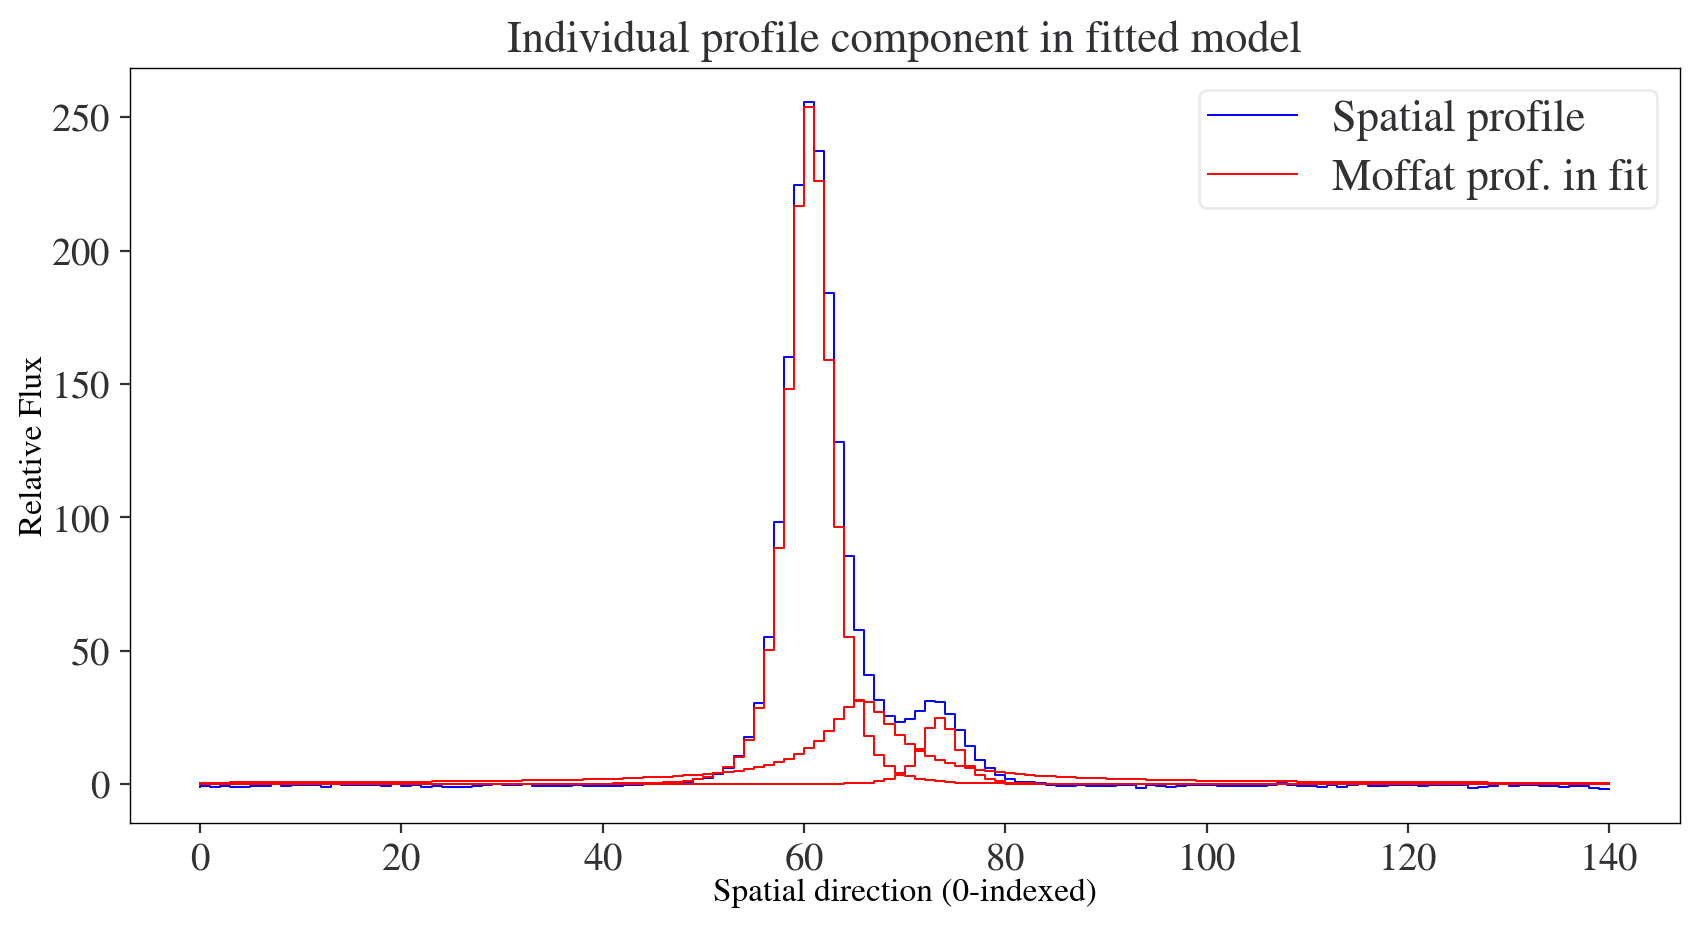


Do you want to start over ? : type yes/no
no


<CompoundModel(c0_0=-1.61739138, amplitude_1=253.85351191, x_0_1=61.07843742, gamma_1=4.04588018, alpha_1=2.30654887, amplitude_2=31.65328675, x_0_2=66.28547654, gamma_2=3.38125613, alpha_2=0.69331413, amplitude_3=24.79891851, x_0_3=73.98360168, gamma_3=3.64305784, alpha_3=2.49633049)>

In [52]:
#J0924
spec6 = spec2d.Spec2d(inspec=file_list[5], invar=var_file_list[5])
spec6.spatial_profile(pixrange=[2400, 2801])
plt.show()
spec6.initial_model()


Initial model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=-1.61739138)>

    [1]: <Moffat1D(amplitude=253.85351191, x_0=61.07843742, gamma=4.04588018, alpha=2.30654887)>

    [2]: <Moffat1D(amplitude=31.65328675, x_0=66.28547654, gamma=3.38125613, alpha=0.69331413)>

    [3]: <Moffat1D(amplitude=24.79891851, x_0=73.98360168, gamma=3.64305784, alpha=2.49633049)>
Parameters:
            c0_0           amplitude_1     ...      gamma_3            alpha_3      
    ------------------- ------------------ ... ------------------ ------------------
    -1.6173913811356022 253.85351190594542 ... 3.6430578391739816 2.4963304932990416

-------------------------------------------


Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=-0.56014955)>

    [1]: <Moffat1

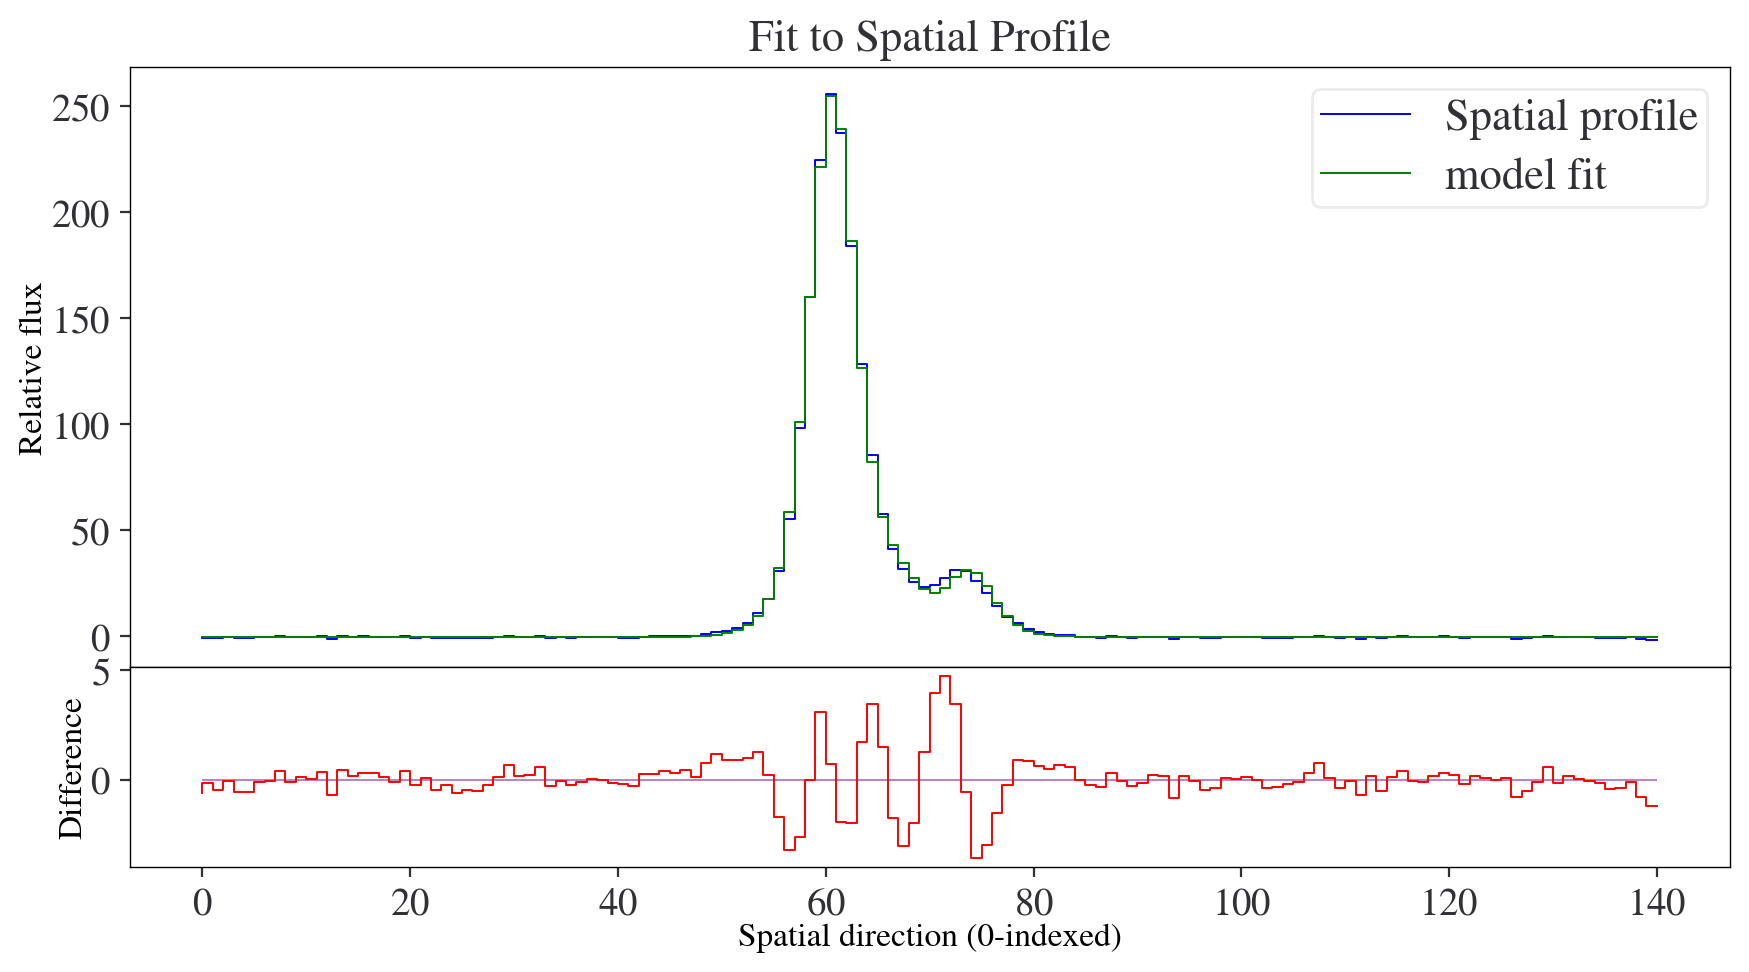

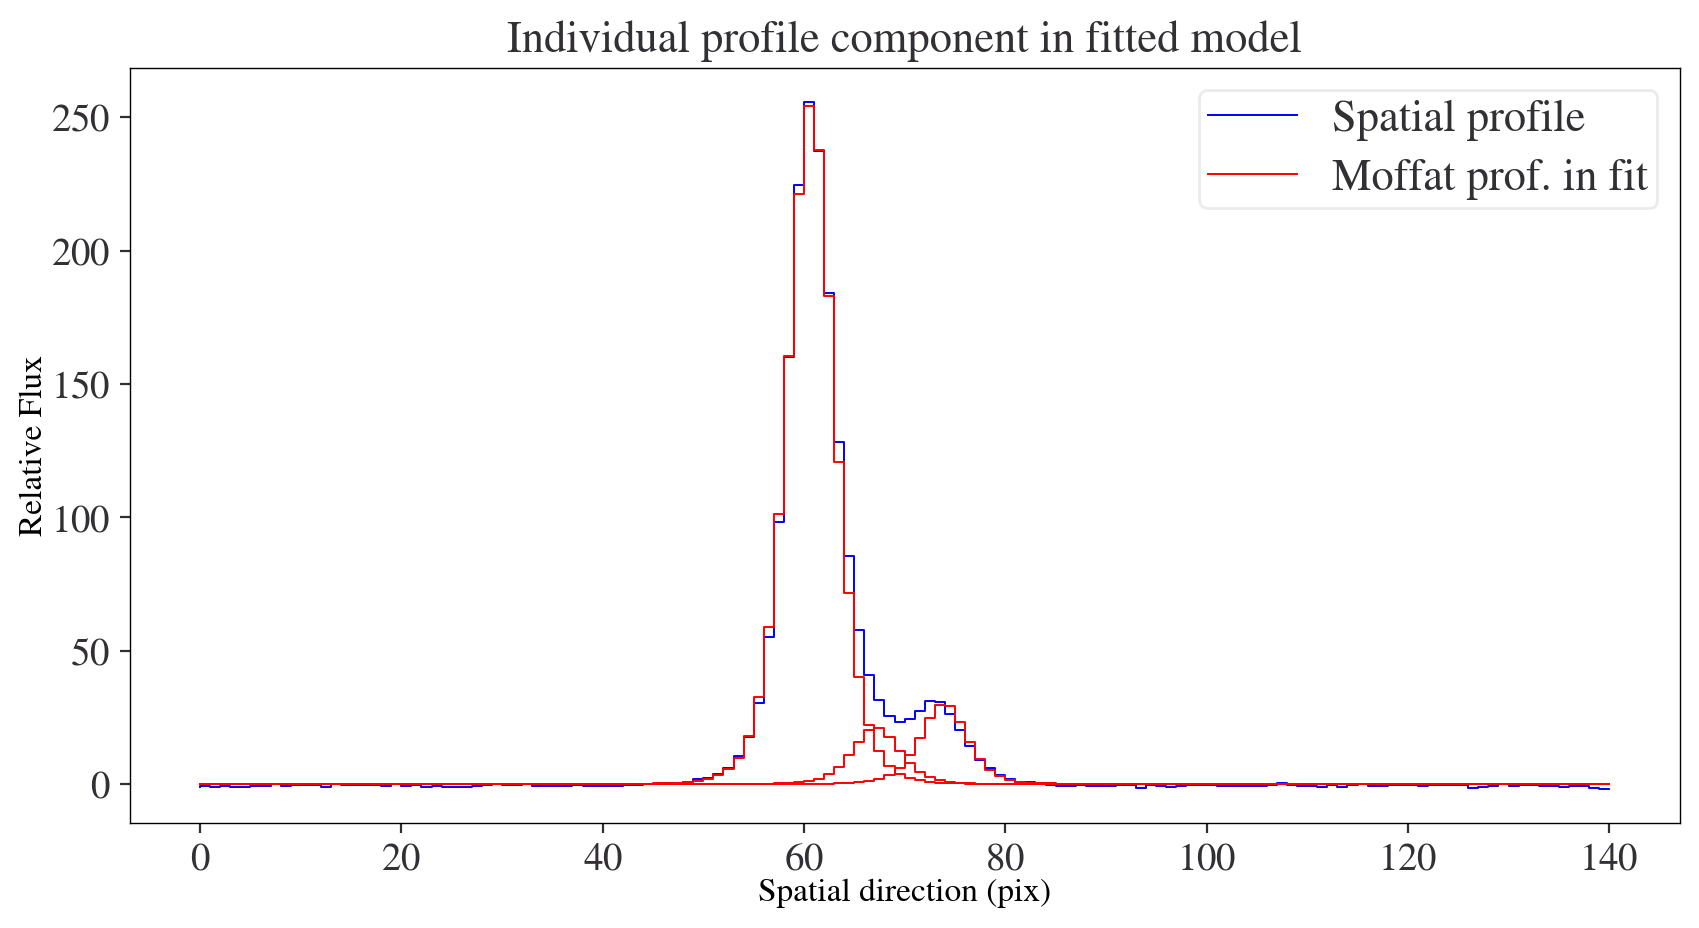

In [53]:
def tie_pos1_moffat_4(model):
    return model.x_0_1 + (0.89 / pixscale[0]) #(0.896 / pixscale) 

def tie_pos2_moffat_4(model):
    return model.x_0_1 + (1.81 / pixscale[0])  #(1.87 / pixscale) 

def tie_gamma_moffat(model):
    return model.gamma_1

def tie_alpha_moffat(model):
    return model.alpha_1

func_dict = {'4_1' : tie_pos1_moffat_4, '4_2' : tie_pos2_moffat_4}

pixscale = [0.137]
order_list = [4]


spec6.mod0[2].x_0.tied = func_dict['%d_%d' %(order_list[0], 1)] #tie_pos1_moffat
spec6.mod0[3].x_0.tied = func_dict['%d_%d' %(order_list[0], 2)] #tie_pos2_moffat
spec6.mod0[2].gamma.tied = tie_gamma_moffat
spec6.mod0[2].alpha.tied = tie_alpha_moffat
spec6.mod0[3].gamma.tied = tie_gamma_moffat
spec6.mod0[3].alpha.tied = tie_alpha_moffat
mod6 = spec6.refined_model(spec6.mod0)

In [54]:
## get noise data in median pixel
d, v = spec6.data[:, 2400:2801], spec6.vardata[:, 2400:2801]
l = d.shape[1]
median_array, median_indx, J0924_var = [], [], []

In [55]:
for i in range(d.shape[0]):
    s = np.argsort(d[i])[l//2]
    #print(s)
    median_array.append(d[i][s])
    median_indx.append(s)
    J0924_var.append(v[i][s])

In [56]:
print(np.sum(spec6.profile['flux'] - np.array(median_array)))
print(np.sum(np.array(J0924_var)<0))

0.0
0


In [57]:
J0924_mad = stats.median_abs_deviation(d, axis=1)
J0924_mad

array([3.38906396, 3.39976541, 3.40320492, 3.11171773, 3.40686339,
       3.48088949, 3.70598717, 3.26115772, 3.53238031, 3.61064891,
       3.71964039, 3.80640192, 3.77785842, 3.69325201, 3.49710769,
       3.40524596, 3.26945822, 3.55983482, 3.4435571 , 3.63245021,
       3.23197016, 3.44779887, 3.07996811, 3.55482282, 3.71112538,
       3.73639431, 3.69571317, 3.48631378, 3.41432536, 3.6108212 ,
       3.39387521, 3.17732858, 3.03985064, 3.4065195 , 3.48208832,
       3.61953176, 2.82607687, 3.03450834, 2.94733103, 3.09909625,
       2.7653224 , 2.88922351, 2.90236275, 2.90031734, 3.00053476,
       2.88033873, 2.83338309, 2.90230073, 2.90149566, 2.86680505,
       2.9308773 , 2.91800874, 2.89007623, 3.14526242, 3.32904137,
       3.68976527, 3.52270715, 3.65553065, 4.691281  , 5.37187808,
       6.91531527, 7.33870766, 7.80433694, 8.28883215, 5.94951869,
       5.07803042, 3.937791  , 3.80993354, 3.6877896 , 3.47474693,
       3.26839346, 3.61384162, 3.77751821, 3.21187927, 3.46982


Loading file ../spectra_extraction/J1433_ESI_spectra/J1433_coadd2d_sp_order_6.fits
-----------------------------------------------

Loading file ../spectra_extraction/J1433_ESI_spectra/J1433_coadd2d_var_order_6.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/J1433_ESI_spectra/J1433_coadd2d_sp_order_6.fits (HDU=0)
Final data dimensions (x y): 4096 x 128

Dispersion axis:              x
N_pixels along dispersion axis: 4096

Profile max value (before normalization) 42.189769


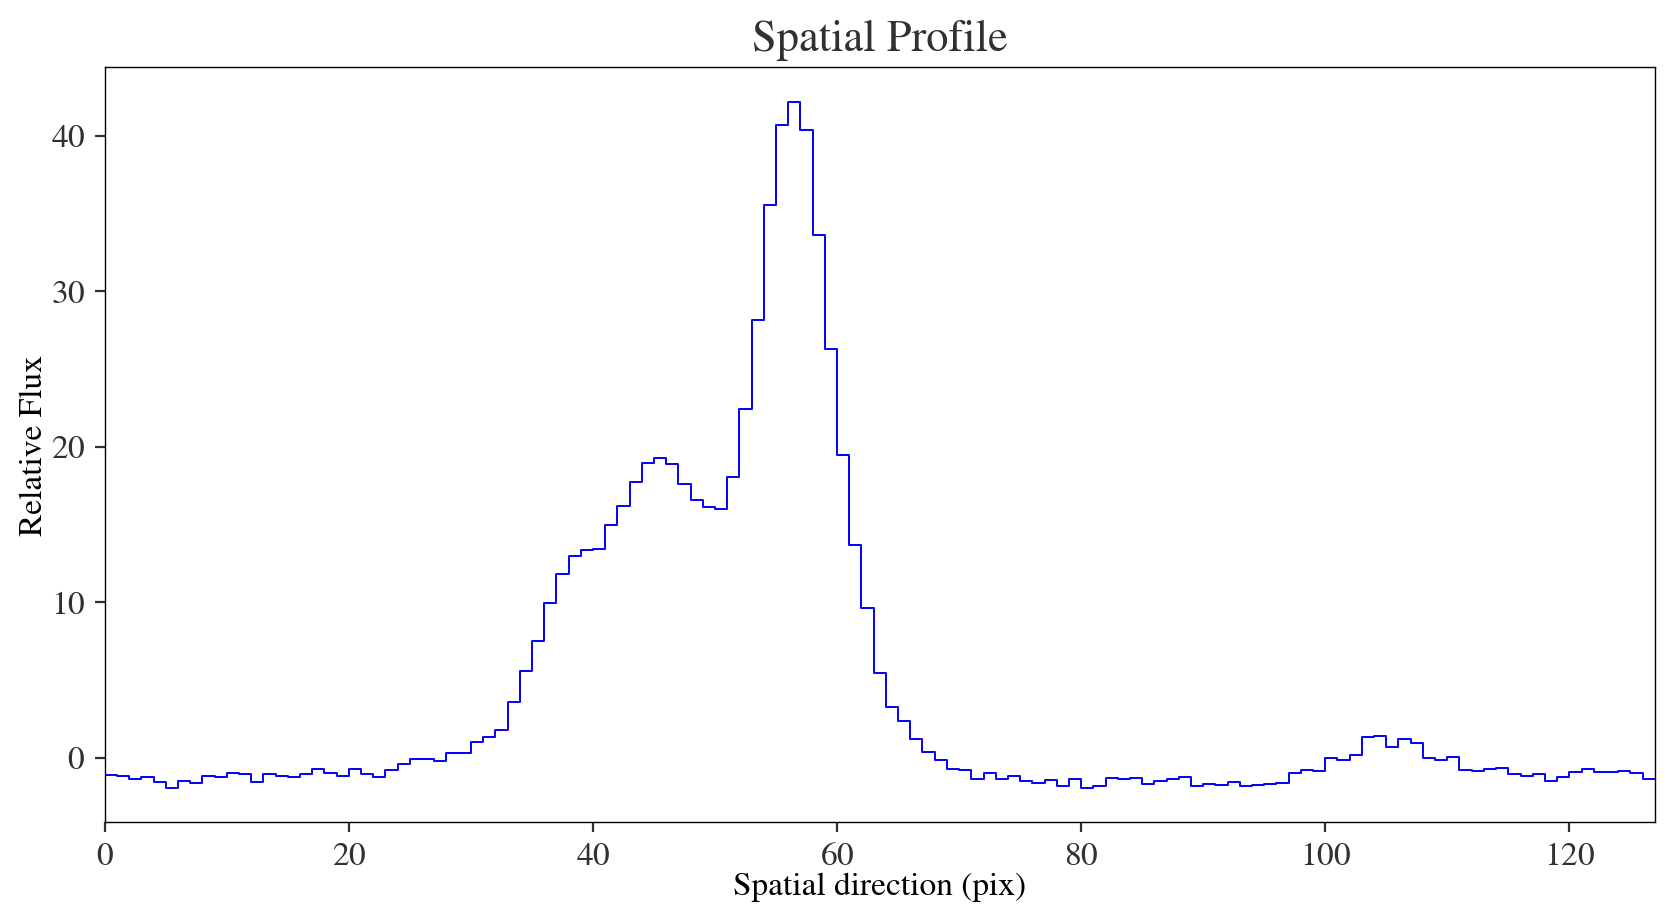


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 3

Now enter constants of the background polynomial upto degree 0
c0 : -2

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 42, 57, 3, 4

amplitude=42.000000, x_0=57.000000, gamma=3.000000, alpha=4.000000

Parameters of Moffat profile 2 : 20, 46, 2, 3

amplitude=20.000000, x_0=46.000000, gamma=2.000000, alpha=3.000000

Parameters of Moffat profile 3 : 13, 38.2, 3, 4

amplitude=13.000000, x_0=38.200000, gamma=3.000000, alpha=4.000000

Fitted model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Polynomial1D(0, c0=-1.03075348)>

    [1]: <Moffat1D(amplitude=42.5

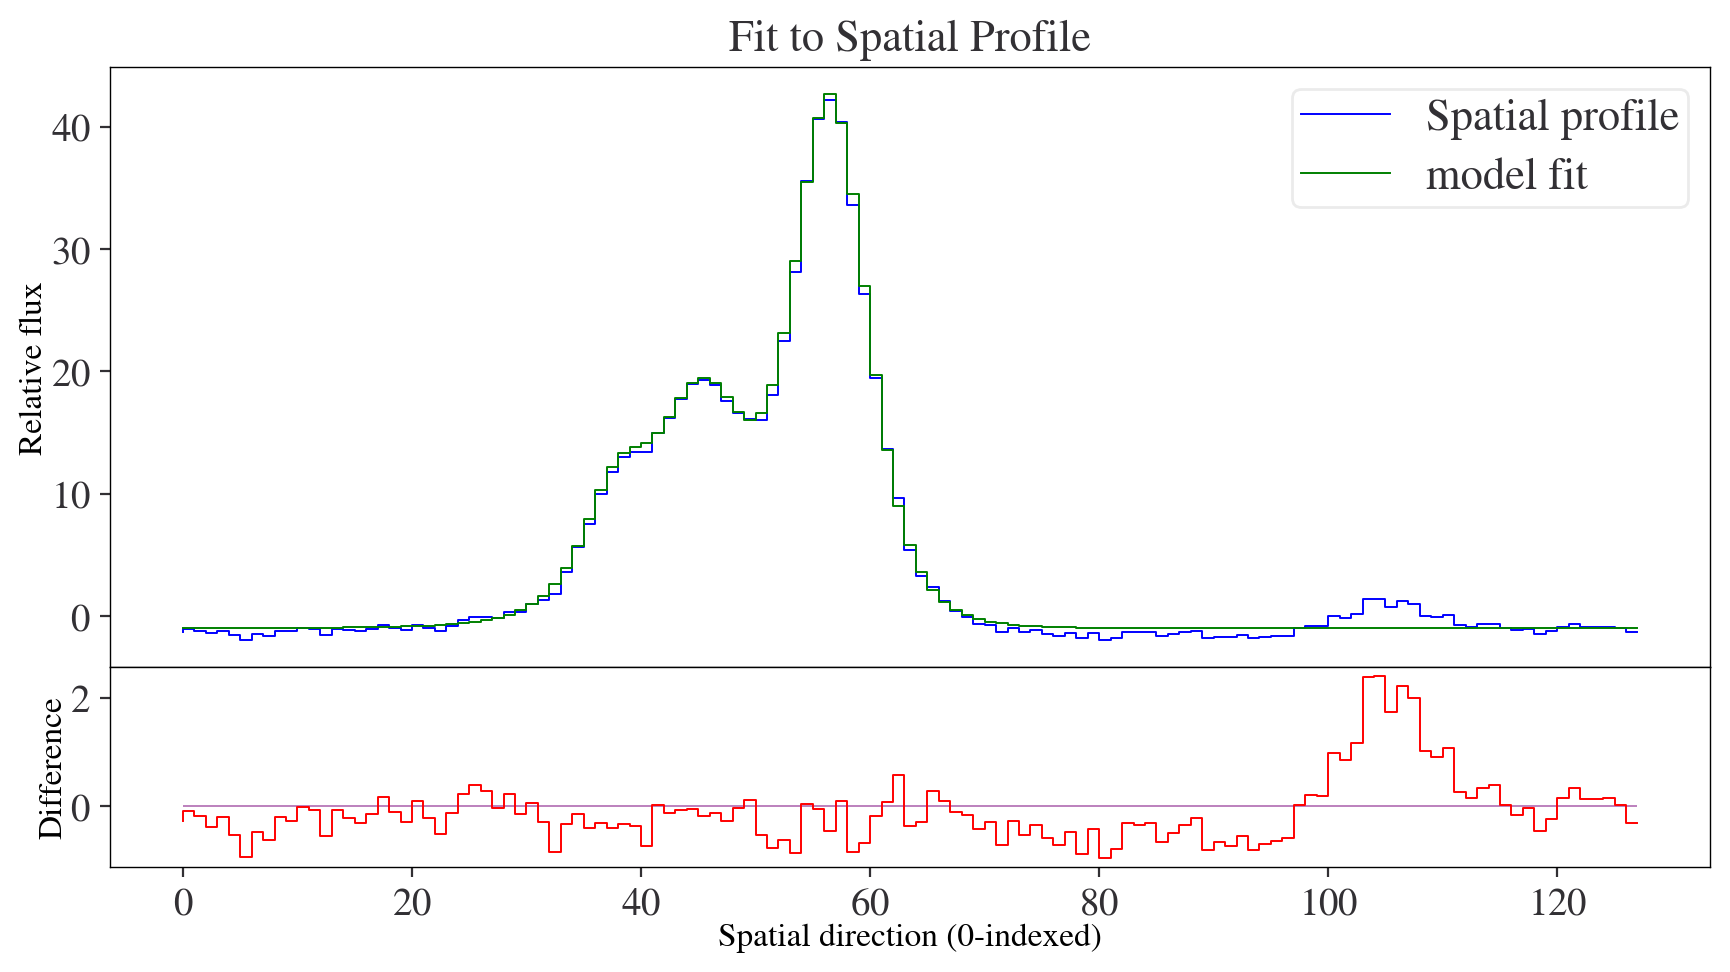

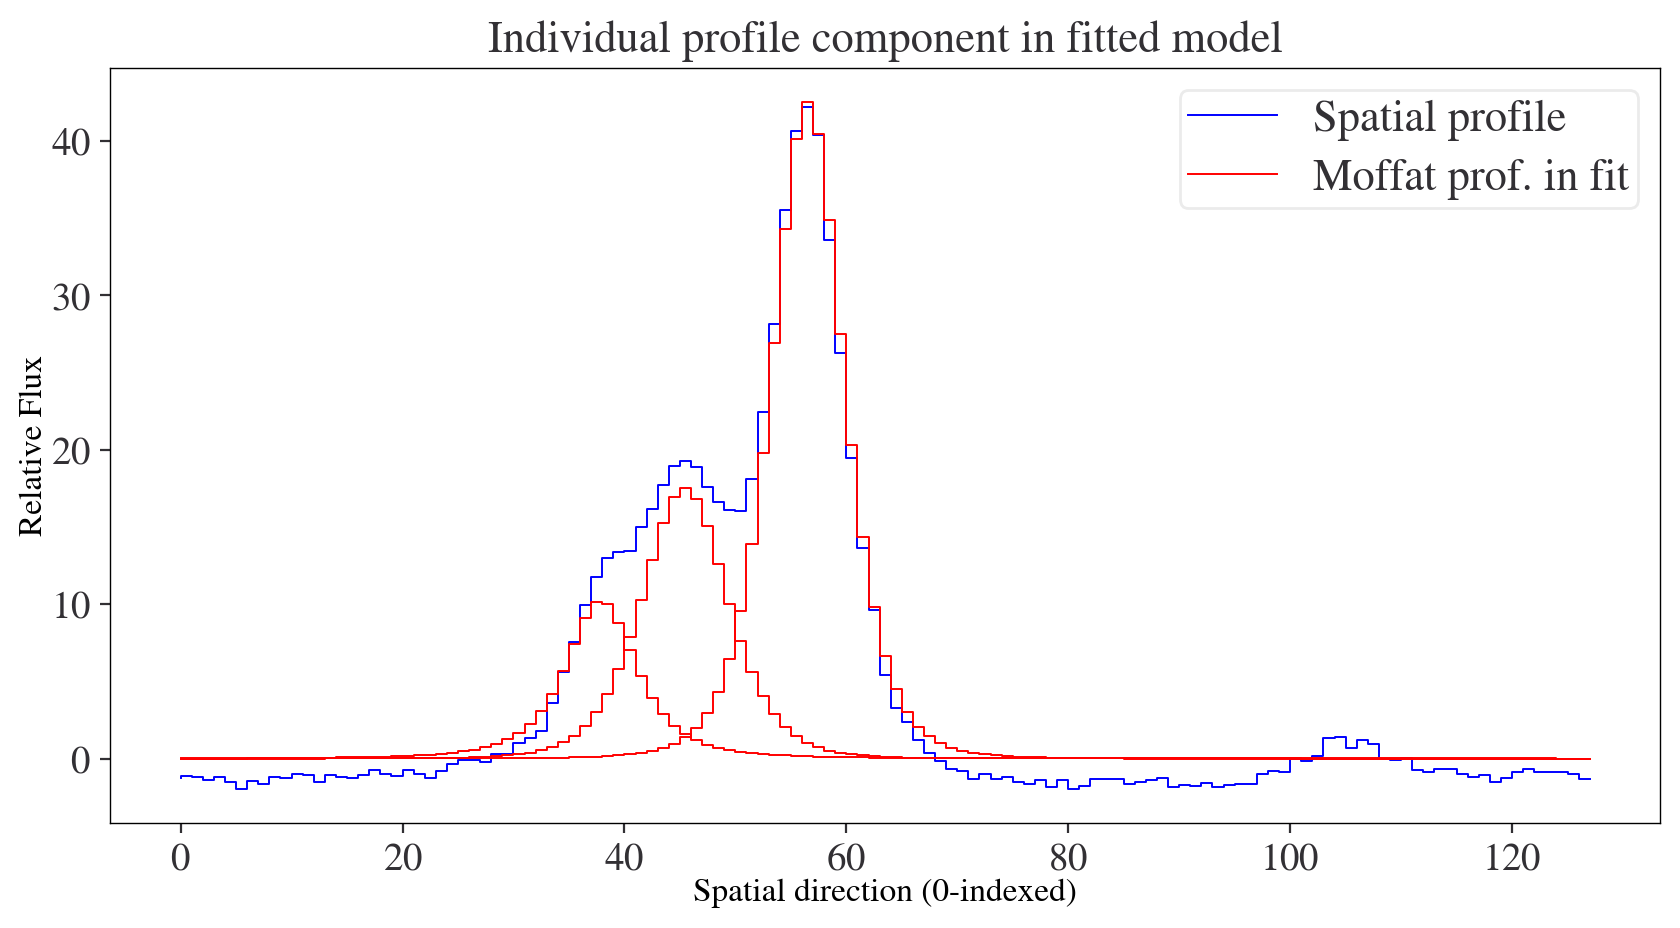


Do you want to start over ? : type yes/no
no


In [58]:
#J1433
spec7 = spec2d.Spec2d(inspec=file_list[6], invar=var_file_list[6])
spec7.spatial_profile(pixrange=[2100, 2501])
plt.show()
mod7 = spec7.initial_model()

In [59]:
## get noise data in median pixel
d, v = spec7.data[:, 2100:2501], spec7.vardata[:, 2100:2501]
l = d.shape[1]
median_array, median_indx, J1433_var = [], [], []

In [60]:
for i in range(d.shape[0]):
    s = np.argsort(d[i])[l//2]
    #print(s)
    median_array.append(d[i][s])
    median_indx.append(s)
    J1433_var.append(v[i][s])

In [61]:
print(np.sum(spec7.profile['flux'] - np.array(median_array)))
print(np.sum(np.array(J1433_var)<0))

0.0
0


In [62]:
J1433_mad = stats.median_abs_deviation(d, axis=1)
J1433_mad

array([3.11315437, 2.66884836, 2.69158149, 2.7870165 , 2.82421775,
       3.01146244, 2.94331757, 2.75107437, 2.50059097, 2.96985062,
       2.58993423, 2.73275098, 2.94825331, 2.59702281, 2.5079797 ,
       2.71267397, 2.73406734, 2.7864206 , 2.70883597, 2.74423671,
       2.71673392, 2.55640069, 2.57234283, 2.7765699 , 2.53873652,
       2.55405458, 2.71478575, 3.10848986, 2.61521717, 2.90160814,
       2.61977459, 3.02264331, 2.39208064, 2.29631182, 2.60201985,
       2.3793766 , 2.23361426, 2.38198329, 2.69822427, 3.02778184,
       2.70082169, 3.05084592, 3.04876684, 2.72278794, 2.87037013,
       3.01294005, 2.70826188, 2.91373416, 2.92550759, 2.80559795,
       2.64223292, 2.69595107, 3.08099327, 2.93001012, 3.16662015,
       3.36701746, 3.35535329, 3.28899221, 3.44857463, 2.9928511 ,
       2.86564691, 2.56153871, 2.92998935, 2.57746823, 2.42829553,
       2.41418333, 2.37205172, 2.24538591, 2.31726613, 2.33844032,
       2.43857224, 2.25204002, 2.30787737, 2.2420771 , 2.16278


Loading file ../spectra_extraction/J1817_ESI_spectra/J1817_coadd2d_sp_order_6.fits
-----------------------------------------------

Loading file ../spectra_extraction/J1817_ESI_spectra/J1817_coadd2d_var_order_6.fits
-----------------------------------------------
Read in 2-dimensional spectrum from ../spectra_extraction/J1817_ESI_spectra/J1817_coadd2d_sp_order_6.fits (HDU=0)
Final data dimensions (x y): 4096 x 128

Dispersion axis:              x
N_pixels along dispersion axis: 4096

Profile max value (before normalization) 215.761382


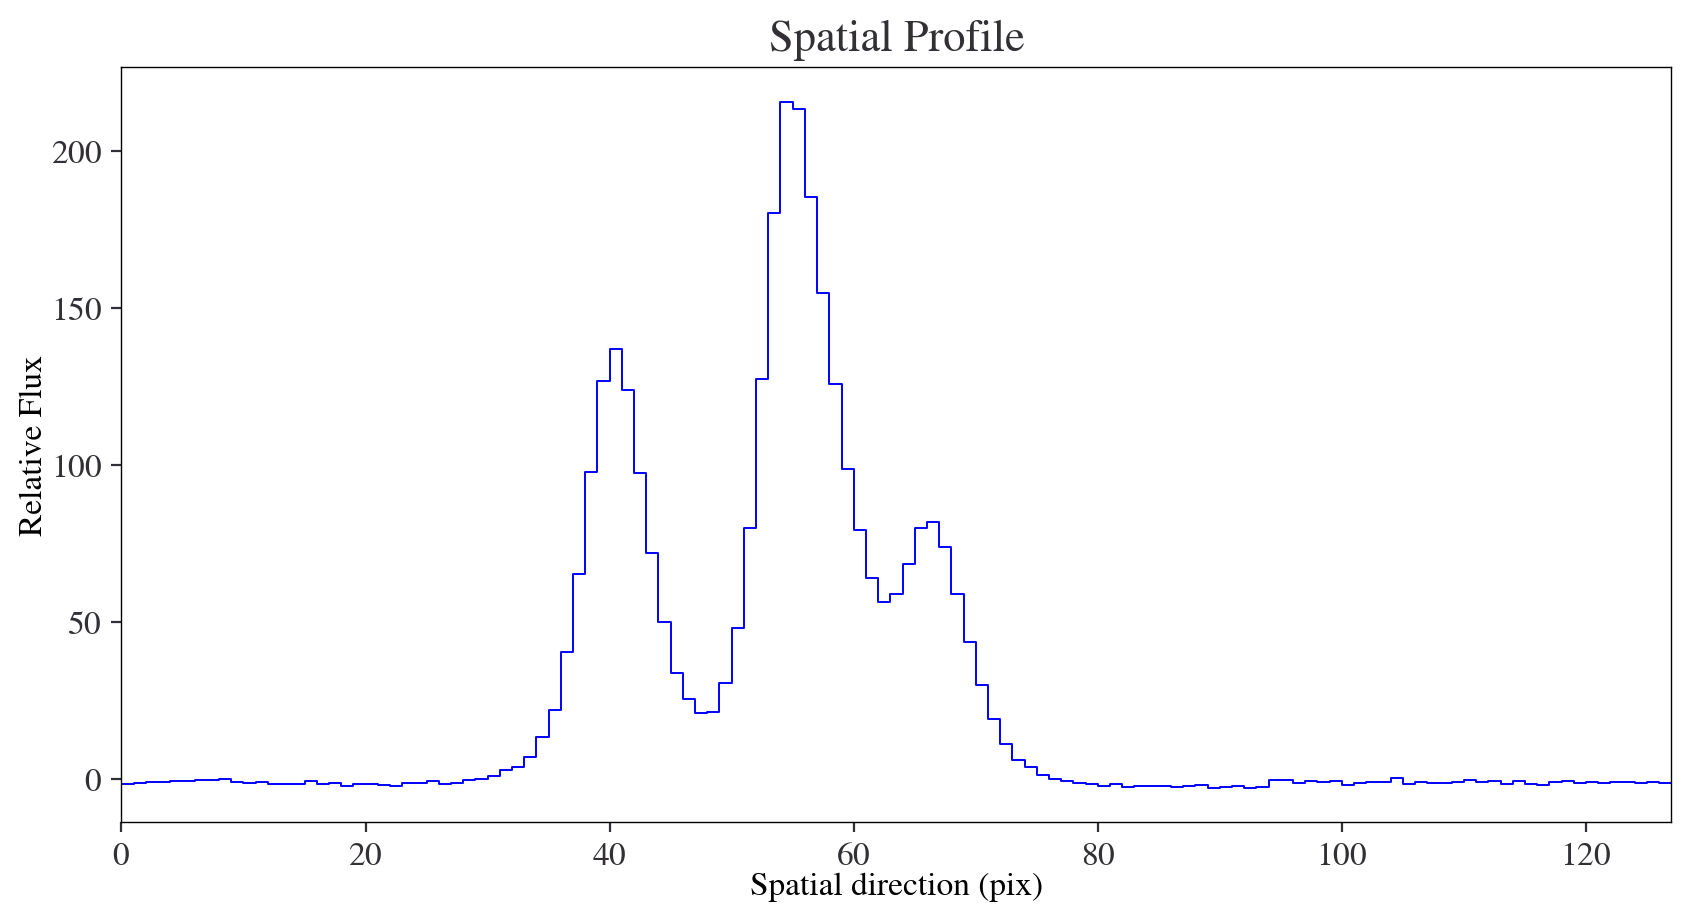


To create an initial model you first need to enter degree of background polynomial(<3) and number of Gaussian and Moffat profile as integers.
Order of background polynomial : 0
Number of Gaussian profile : 0
Number of Moffat profile : 5

Now enter constants of the background polynomial upto degree 0
c0 : -1

Enter parameter values for a Moffat profile in following format...
amplitude_value, x_0_value, gamma_value, alpha_value

Parameters of Moffat profile 1 : 140, 40, 3, 4

amplitude=140.000000, x_0=40.000000, gamma=3.000000, alpha=4.000000

Parameters of Moffat profile 2 : 210, 55, 3, 4

amplitude=210.000000, x_0=55.000000, gamma=3.000000, alpha=4.000000

Parameters of Moffat profile 3 : 28, 59, 2, 3

amplitude=28.000000, x_0=59.000000, gamma=2.000000, alpha=3.000000

Parameters of Moffat profile 4 : 15, 61.5, 2, 3

amplitude=15.000000, x_0=61.500000, gamma=2.000000, alpha=3.000000

Parameters of Moffat profile 5 :  78, 67, 3, 4

amplitude=78.000000, x_0=67.000000, gamma=3.000000, al

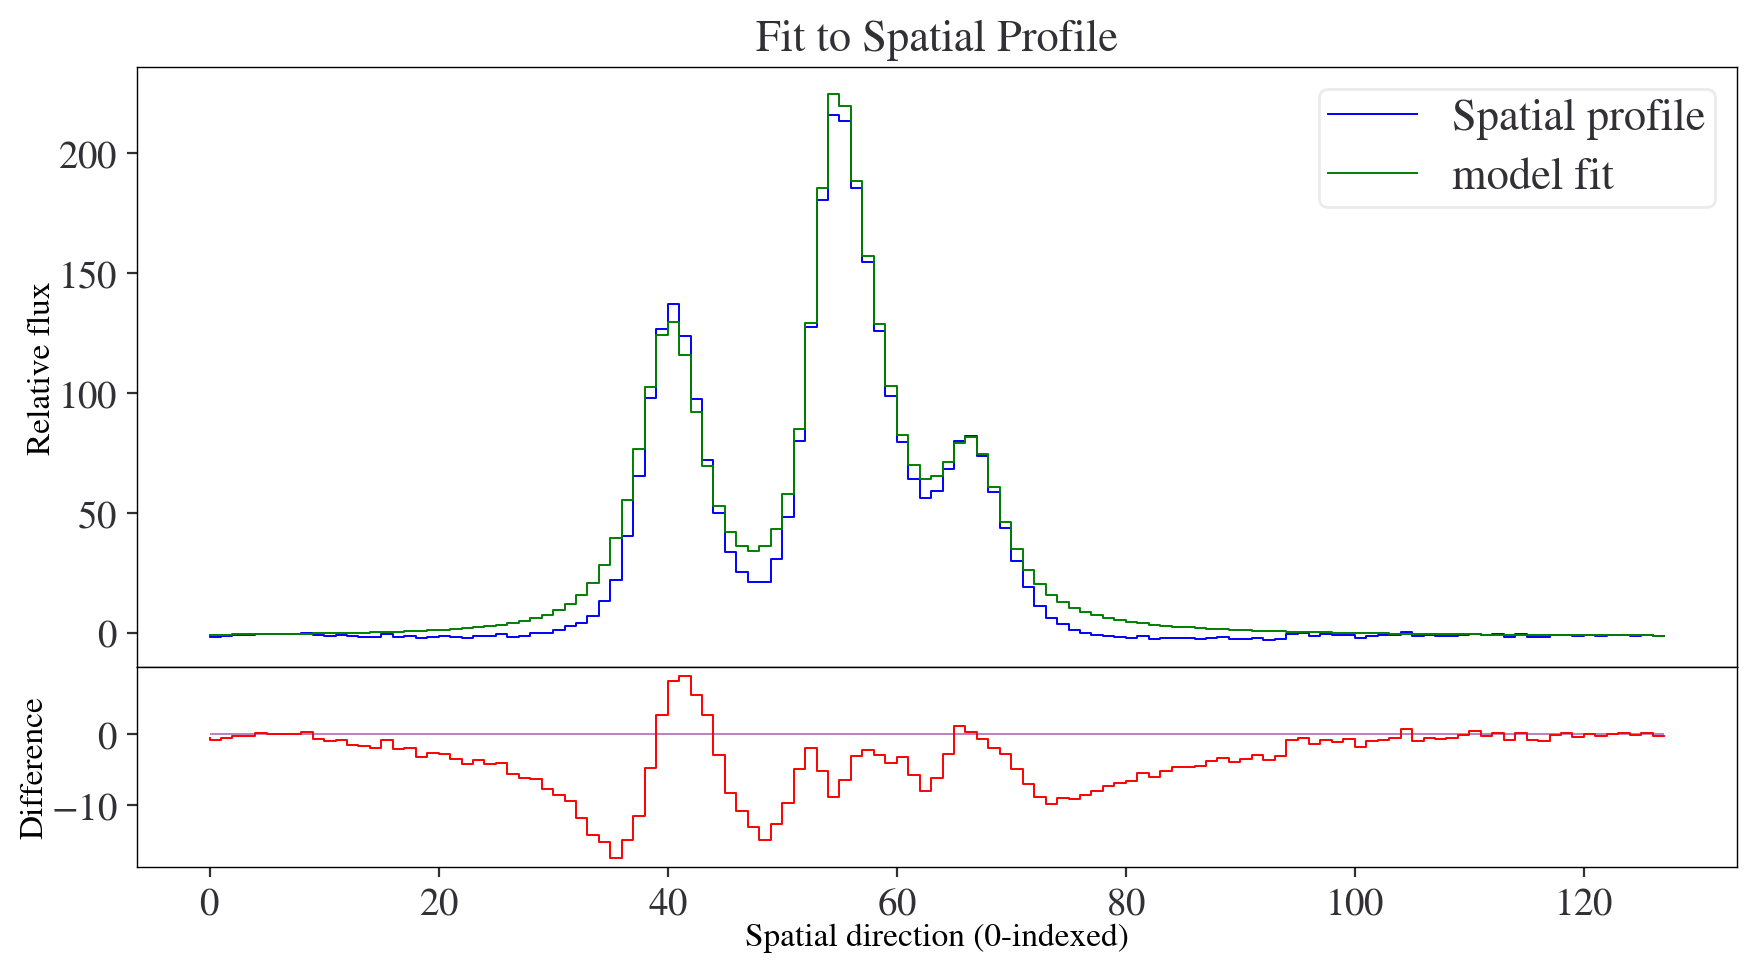

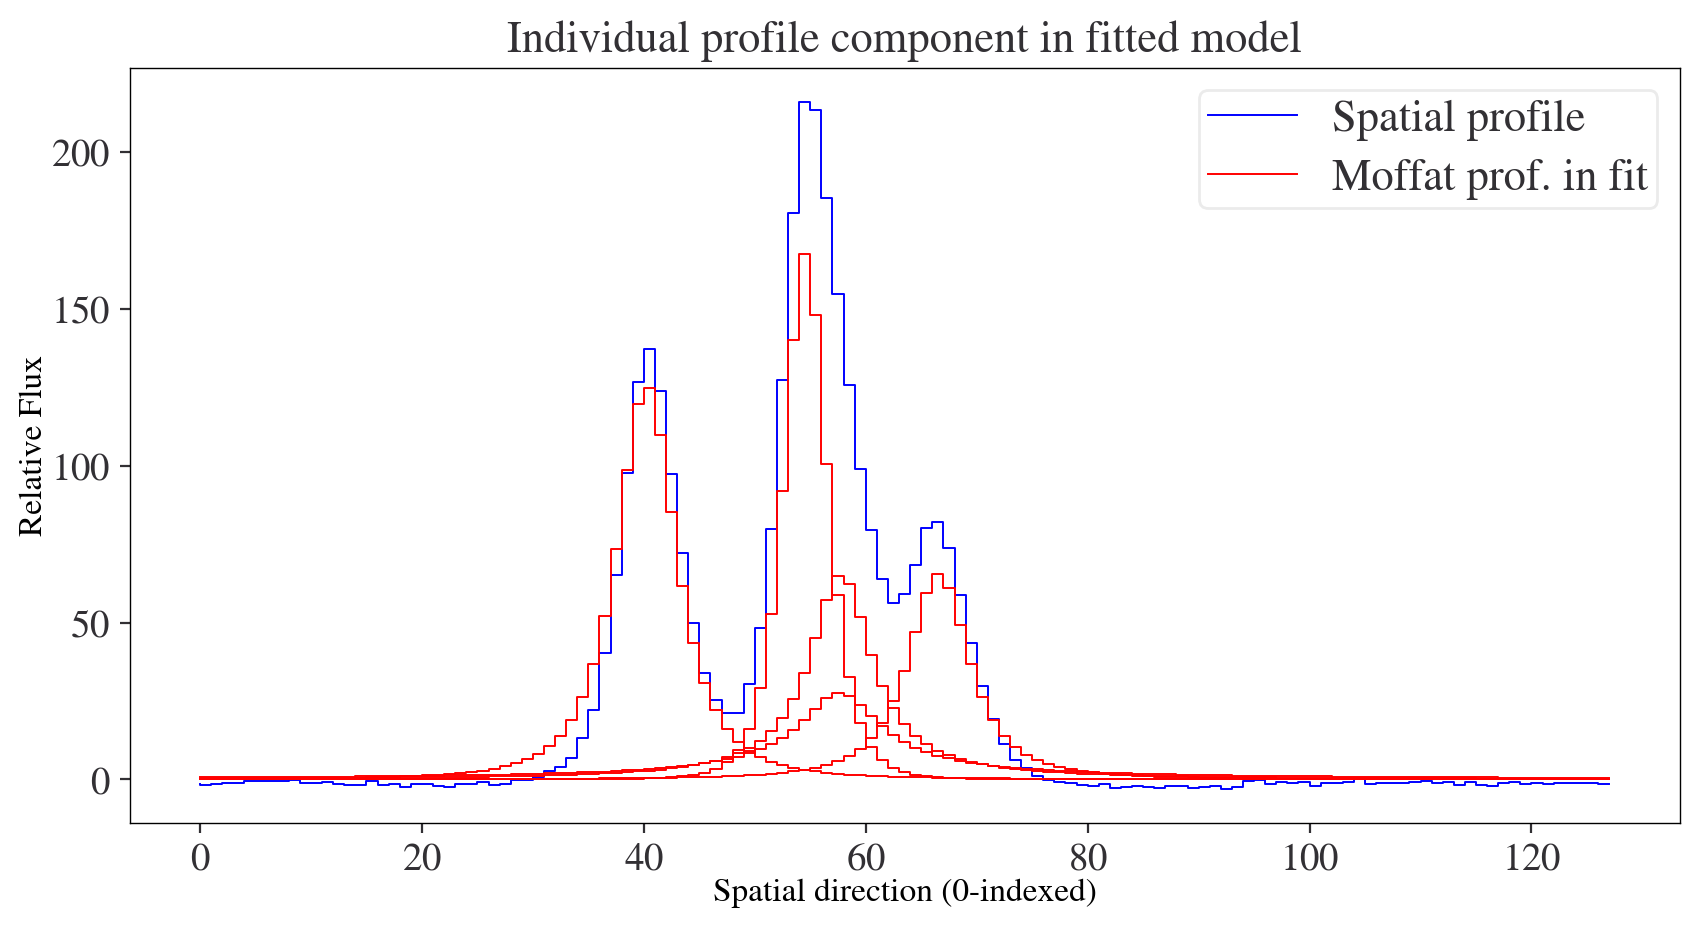


Do you want to start over ? : type yes/no
no


In [63]:
#J1817
spec8 = spec2d.Spec2d(inspec=file_list[7], invar=var_file_list[7])
spec8.spatial_profile(pixrange=[2700, 3101])
plt.show()
mod8 = spec8.initial_model()


Initial model
-------------
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <Polynomial1D(0, c0=-2.01130222)>

    [1]: <Moffat1D(amplitude=125.3437104, x_0=40.73659713, gamma=4.07367828, alpha=1.43418586)>

    [2]: <Moffat1D(amplitude=167.69977321, x_0=55.0936728, gamma=3.7923547, alpha=2.26643069)>

    [3]: <Moffat1D(amplitude=65.30728307, x_0=58.27139883, gamma=3.2304484, alpha=0.92497479)>

    [4]: <Moffat1D(amplitude=27.57815865, x_0=58.18839987, gamma=3.71839211, alpha=0.67958734)>

    [5]: <Moffat1D(amplitude=65.44893228, x_0=67.08987737, gamma=3.82729333, alpha=1.27136029)>
Parameters:
           c0_0           amplitude_1     ...      gamma_5           alpha_5      
    ------------------ ------------------ ... ----------------- ------------------
    -2.011302222698364 125.34371039609094 ... 3.827293334863393 1.2713602880712946

-------------------------------------------


Fitted m

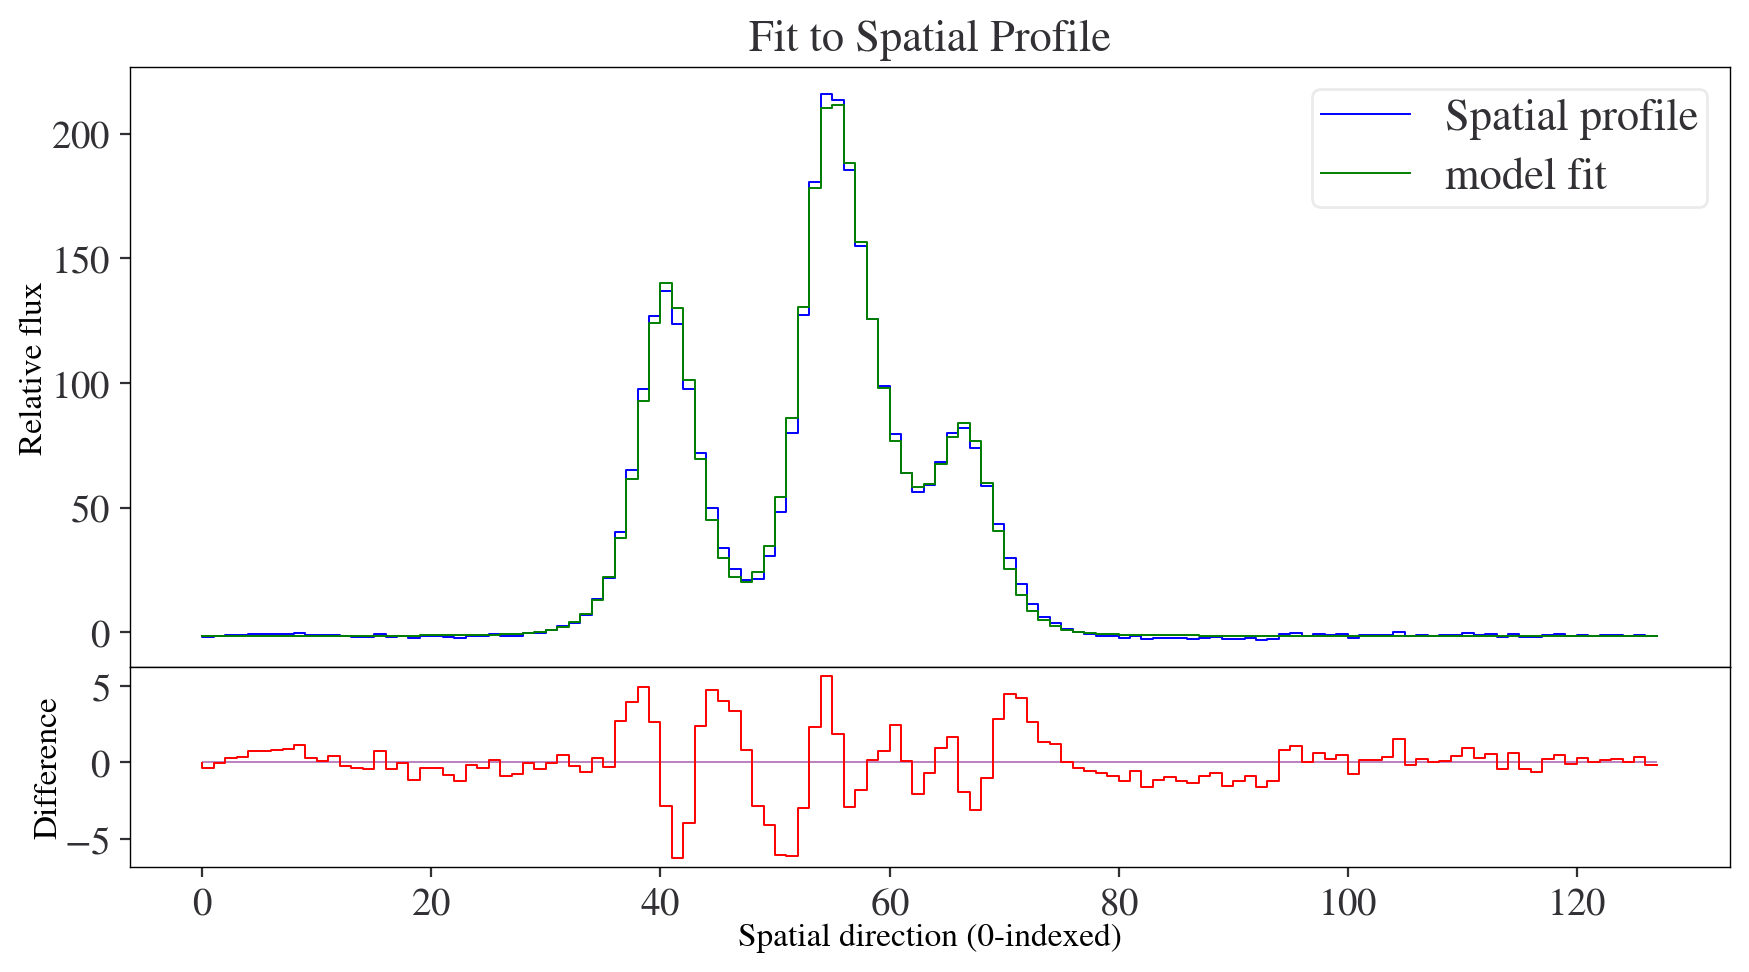

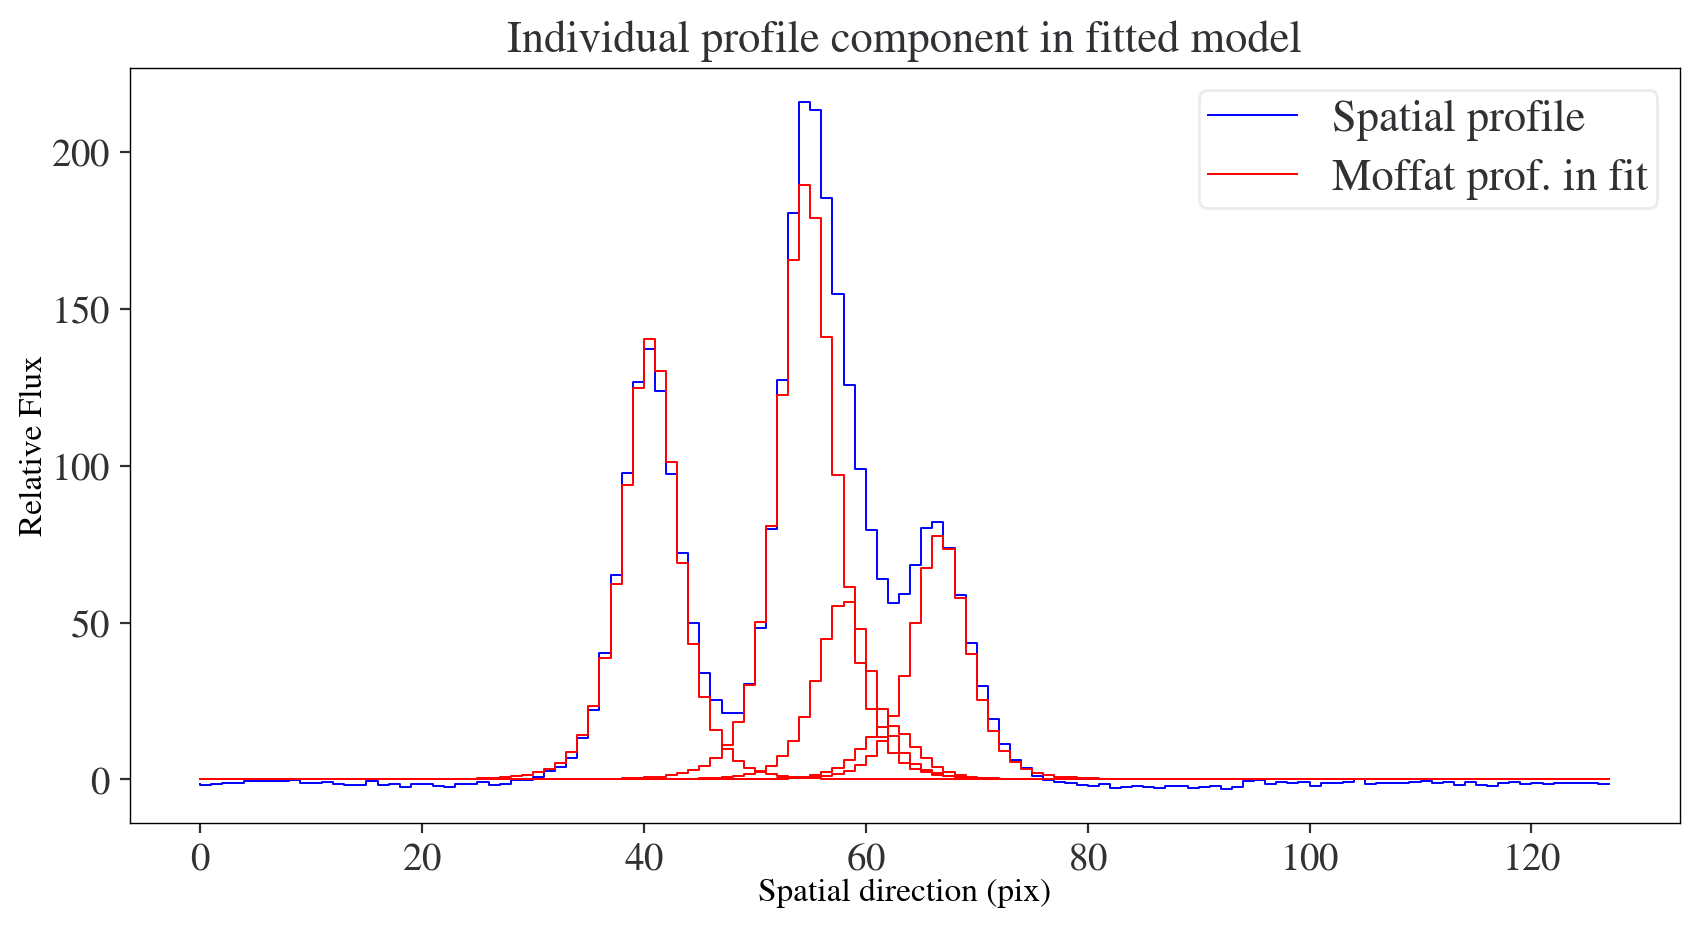

In [64]:
def tie_pos1_moffat_6(model):
    return model.x_0_2 - (2.10 / pixscale[0])  

def tie_pos2_moffat_6(model):
    return model.x_0_2 + (1.1 / pixscale[0])

def tie_pos3_moffat_6(model):
    return model.x_0_2 + (1.79 / pixscale[0])

def tie_pos4_moffat_6(model):
    return model.x_0_2 + (0.51 / pixscale[0])

def tie_gamma_moffat(model):
    return model.gamma_2

def tie_alpha_moffat(model):
    return model.alpha_2 

func_dict = {
'6_1' : tie_pos1_moffat_6, '6_2' : tie_pos2_moffat_6, '6_3' : tie_pos3_moffat_6, '6_4' : tie_pos4_moffat_6}

pixscale = [0.149]
ord_list = [ 6]

spec8.mod0[1].x_0.tied = func_dict['%d_%d' %(ord_list[0], 1)] #tie_pos1_moffat
#spec8.mod0[1].mean.tied = func_dict['%d_%d' %(ord_list[i], 2)] #tie_pos1_moffat
spec8.mod0[3].x_0.tied = func_dict['%d_%d' %(ord_list[0], 4)] #tie_pos2_moffat
spec8.mod0[4].x_0.tied = func_dict['%d_%d' %(ord_list[0], 2)]
spec8.mod0[5].x_0.tied = func_dict['%d_%d' %(ord_list[0], 3)]
spec8.mod0[1].gamma.tied = tie_gamma_moffat
spec8.mod0[1].alpha.tied = tie_alpha_moffat
spec8.mod0[3].gamma.tied = tie_gamma_moffat
spec8.mod0[3].alpha.tied = tie_alpha_moffat
spec8.mod0[4].gamma.tied = tie_gamma_moffat
spec8.mod0[4].alpha.tied = tie_alpha_moffat
spec8.mod0[5].gamma.tied = tie_gamma_moffat
spec8.mod0[5].alpha.tied = tie_alpha_moffat
mod8 = spec8.refined_model(spec8.mod0)

In [65]:
## get noise data in median pixel
d, v = spec8.data[:, 2700:3101], spec8.vardata[:, 2700:3101]
l = d.shape[1]
median_array, median_indx, J1817_var = [], [], []

In [66]:
for i in range(d.shape[0]):
    s = np.argsort(d[i])[l//2]
    #print(s)
    median_array.append(d[i][s])
    median_indx.append(s)
    J1817_var.append(v[i][s])

In [67]:
print(np.sum(spec8.profile['flux'] - np.array(median_array)))
print(np.sum(np.array(J1817_var)<0))

0.0
0


In [68]:
J1817_mad = stats.median_abs_deviation(d, axis=1)
J1817_mad

array([ 3.50890209,  3.24457209,  3.69886328,  3.63540775,  3.68302006,
        3.51089036,  3.36700585,  3.41901952,  3.33760448,  3.43890974,
        3.61336119,  3.4440909 ,  3.25354977,  3.59120599,  3.00222066,
        3.30125463,  3.24834549,  3.41261424,  3.13287516,  3.86155425,
        3.49689267,  3.29843596,  3.47198861,  4.17665904,  3.22331313,
        3.63991382,  2.86178574,  3.62040496,  3.48364003,  3.30751143,
        3.35786906,  3.62144384,  3.59469887,  4.04811657,  3.54291253,
        4.04539804,  4.39553192,  4.96398879,  6.00565278,  7.17713089,
        7.45714047,  7.53848281,  6.82326889,  6.13871632,  5.45567029,
        4.97257237,  4.47815809,  4.595112  ,  4.50829094,  4.88901168,
        6.72100465,  8.59148358, 11.31430911, 15.90543628, 25.22191842,
       30.94781463, 34.02327045, 32.90303255, 26.94216579, 21.17873084,
       15.84397182, 12.70793652, 11.06339857, 11.10570044, 10.26184848,
       11.19065074, 12.71767874, 14.2204568 , 12.34626362, 11.30

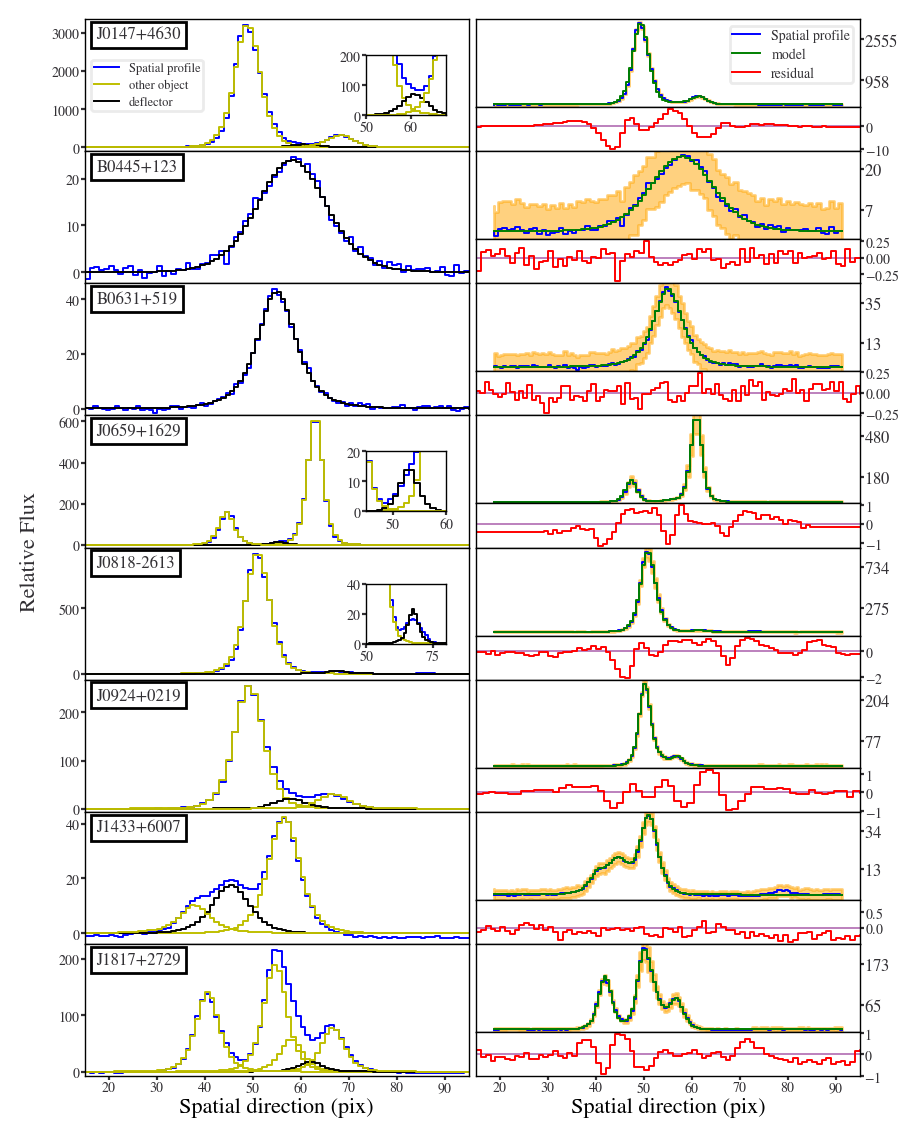

In [77]:
spec_list = [spec1, spec2, spec3, spec4, spec5, spec6, spec7, spec8]
#var_median_list = [J0147_var, B0445_var, B0631_var, J0659_var, J0818_var, J0924_var, J1433_var,
#                   J1817_var]
mad_list = [J0147_mad, B0445_mad, B0631_mad, J0659_mad, J0818_mad, J0924_mad, J1433_mad, J1817_mad]
columns = 2
rows = len(spec_list)
lens_name = np.array(['J0147+4630', 'B0445+123', 'B0631+519', 'J0659+1629', 'J0818-2613', 'J0924+0219',
                      'J1433+6007', 'J1817+2729'])
deflector_comp = [2, 1, 1, 2, 2, 2, 2, 4]
fig = plt.figure(figsize=(5, 7))
                 
gs = gridspec.GridSpec(rows, columns, figure=fig)

x_lim = [[15, 95], [0, 80], [10, 100], [10, 95], [15, 95], [35, 95], [15, 95], [15, 95]]
y_lim_offset = [-101, -1, -1, -10, -41, -5, -2, -5]

for i, spec in enumerate(spec_list):
    profile = spec.profile
    #print(profile['flux'].shape)
    ax1 = fig.add_subplot(gs[i, 0])
    if i==3:
        profile.x, profile.y = np.arange(len(spec4.profile['flux'])), spec4.profile['flux']
        profile.y = np.array([profile['flux'][0]]*25 + profile.y.tolist() + [profile['flux'][-1]]*20)
        profile.x = np.arange(len(profile.y))
    #print(profile.x.shape)
    ax1.plot(profile.x, profile.y, color='b', linestyle='solid',
                        drawstyle='steps', label='Spatial profile')
    #print(profile.x.shape)
    label_m = True
    for j, md in enumerate(spec.mod0):
        mod_y = md(np.arange(len(profile['flux'])))#md(profile.x)
        if i==3:
            mod_y = np.array([mod_y[0]]*25 + mod_y.tolist() + [mod_y[-1]]*20)
            
        if j==deflector_comp[i]:
            plt.plot(profile.x, mod_y, color='k',
                            drawstyle='steps', label='deflector')
            #plt.plot(profile.x, np.zeros(len(profile.x))-200.0, color='y', label='other object')

        elif isinstance(md, models.Moffat1D):
            if label_m:
                plt.plot(profile.x, mod_y, color='y', drawstyle='steps',
                                                   label='other object')
                label_m = False
            else:
                plt.plot(profile.x, mod_y, color='y', drawstyle='steps')

    if i==0 or i==3 or i==4:
        axins = inset_axes(ax1, width=.4,height=0.3, loc=7)
    
        plt.plot(profile.x, profile.y, color='b', linestyle='solid',
                            drawstyle='steps')
        for j, md in enumerate(spec.mod0):
            mod_y = md(np.arange(len(profile['flux'])))#md(profile.x)
            if i==3:
                mod_y = np.array([mod_y[0]]*25 + mod_y.tolist() + [mod_y[-1]]*20)
            if j==deflector_comp[i]:
                plt.plot(profile.x, mod_y, color='k', drawstyle='steps')
            elif isinstance(md, models.Moffat1D):
                    plt.plot(profile.x, mod_y, color='y', drawstyle='steps')
        if i==0:
            plt.xlim(50, 68)
            plt.ylim(0,  200)

        if i==3:
            plt.xlim(45, 60)
            plt.ylim(0,  20)

        if i==4:
            plt.xlim(50, 80)
            plt.ylim(0,  40)
            
        axins.tick_params(axis='both', labelsize=5, length=1.5, pad=0.05)
        
    #ax1.set_yticks([])
    ax1.set_ylim(y_lim_offset[i]+np.min(profile.y), 1.05*np.max(profile.y))
    ax1.set_xlim(x_lim[i])
    ax1.annotate(lens_name[i], (0.03, 0.85), xycoords='axes fraction',
                 fontsize=6, bbox=dict(boxstyle='square', fc='white'))
    
    #ax1.set_ylabel('Relative Flux', fontsize=10)
    
    gs_sub = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[i, 1],
                                       hspace=0, height_ratios=[3, 1.5])
    mod_y = spec.mod0(np.arange(len(profile['flux'])))#md(profile.x)
    if i==3:
        mod_y = np.array([mod_y[0]]*25 + mod_y.tolist() + [mod_y[-1]]*20)
        #var_median_list[i] = [var_median_list[i][0]]*25 + var_median_list[i]+[var_median_list[i][-1]]*20
        mad_list[i] = [mad_list[i][0]]*25 + mad_list[i].tolist() + [mad_list[i][-1]]*20
    #mod_y = spec.mod0(profile.x)
    diff = profile.y - mod_y

    ax2 = fig.add_subplot(gs_sub[0, 0])
    ax2.set_xticks([])
    ax2.plot(profile.x, profile.y, color='b', linestyle='solid',
                           drawstyle='steps', label='Spatial profile')
    #ax2.errorbar(profile.x, profile.y, yerr=np.sqrt(var_median_list[i]),
    #             color="#444")
    #ax2.fill_between(profile.x, profile.y+np.sqrt(var_median_list[i]), 
    #                 profile.y - np.sqrt(var_median_list[i]), color='k', alpha=0.2, step='pre')
    ax2.fill_between(profile.x, profile.y+mad_list[i], profile.y - mad_list[i],
                     color='orange', alpha=0.5, step='pre')
    
    ax2.plot(profile.x, mod_y, color='g', drawstyle='steps', label='model')
    ax2.plot(profile.x, np.zeros(len(profile.x))-200, color='r', label='residual')
    
    ax2.yaxis.set_ticks_position('right')
    ax2.set_ylim(np.min(profile.y)+y_lim_offset[i], 1.05*np.max(profile.y))
    #ax2.set_xlim(x_lim[i])
    ax2.tick_params(axis='both', labelsize=6, length=1.5, pad=0.05)
    ax2.set_yticks([ round(np.max(profile.y)*0.3), round(np.max(profile.y)*0.8)])
    
    ax3 = fig.add_subplot(gs_sub[1, 0]) 
    #ax3.plot(profile.x, diff/np.sqrt(var_median_list[i]), 'r', drawstyle='steps', label='residual')
    ax3.plot(profile.x, diff/mad_list[i], 'r', drawstyle='steps', label='residual')

    ax3.hlines(y=0, xmin=min(profile.x), xmax=max(profile.x))
    
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.set_ticks_position('right')
    #ax3.set_ylim(np.min(diff[15:95])-1.0, np.max(diff[15:95])+1.0)
    ax3.set_xlim(x_lim[i])
    
    if i==0:
        ax1.legend(loc='center left', fontsize=4.5)
        ax2.legend(fontsize=5)
        #ax3.legend(fontsize=4)
    
    if i==len(deflector_comp)-1:
        ax1.set_xlabel('Spatial direction (pix)', fontsize=8)
        ax1.tick_params(axis='both', labelsize=5, length=1.5, pad=0.05)
        ax1.set_xlabel('Spatial direction (pix)', fontsize=8)
        ax1.tick_params(axis='both', labelsize=5, length=1.5, pad=0.05)
        ax3.set_xlabel('Spatial direction (pix)', fontsize=8)
        ax3.tick_params(axis='both', labelsize=5, length=1.5, pad=0.05)
    else:
        ax1.set_xticks([])
        ax1.tick_params(axis='both', labelsize=5, length=1.5, pad=0.05)
        ax1.set_xticks([])
        ax1.tick_params(axis='both', labelsize=5, length=1.5, pad=0.05)
        ax3.set_xticks([])
        ax3.tick_params(axis='both', labelsize=5, length=1.5, pad=0.2)
        
    plt.subplots_adjust(wspace=0.02, hspace=0.0)
    
fig.text(0.07, 0.5, 'Relative Flux', ha='center', va='center', rotation='vertical', fontsize=8)
#plt.show()
plt.savefig('paper_plots/model_fit3.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [1]:
spec_list = [spec3, spec4, spec5, spec6, spec7]
columns = 3
rows = len(spec_list)
lens_name = np.array(['B0445+123', 'B0631+519', 'J0147+4630', 'J0818-2613', 'J0924+0219',
                      'J1433+6007', 'J1817+2729'])
deflector_comp = [2, 2, 2, 2, 4]
fig = plt.figure(figsize=(15, 18))
gs = gridspec.GridSpec(rows, columns, figure=fig)

x_lim = [[15, 95], [15, 95], [35, 95], [15, 95], [15, 95]]
y_lim_offset = [-101, -41, -5, -2, -5]

for i, spec in enumerate(spec_list):
    
    profile = spec.profile
    ax1 = fig.add_subplot(gs[i, 0])
    
    ax1.plot(profile.x, profile.y, color='b', linestyle='solid',
                           drawstyle='steps', label='Spatial profile')
    
    ax1.annotate(lens_name[i+2], (0.05, 0.9), xycoords='axes fraction',
                 fontsize=16, bbox=dict(boxstyle='square', fc='white'))
    
    ax1.set_ylabel('Relative Flux', fontsize=14)
    ax1.set_ylim(y_lim_offset[i]+np.min(profile.y), 1.05*np.max(profile.y))
    ax1.set_xlim(x_lim[i])
    
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.plot(profile.x, profile.y, color='b', linestyle='solid',
                            drawstyle='steps', label='Spatial profile')
    label_m = True
    for j, md in enumerate(spec.mod0):
        mod_y = md(profile.x)
        if j==deflector_comp[i]:
            plt.plot(profile.x, mod_y, color='k',
                            drawstyle='steps', label='deflector')
            
        elif isinstance(md, models.Moffat1D):
            if label_m:
                plt.plot(profile.x, mod_y, color='y', drawstyle='steps',
                                                   label='other object')
                label_m = False
            else:
                plt.plot(profile.x, mod_y, color='y', drawstyle='steps')

    if i==0 or i==1:
        axins = inset_axes(ax2, width=1.1, height=0.9, loc=7)
        plt.plot(profile.x, profile.y, color='b', linestyle='solid',
                            drawstyle='steps')
        for j, md in enumerate(spec.mod0):
            mod_y = md(profile.x)
            if j==deflector_comp[i]:
                plt.plot(profile.x, mod_y, color='k', drawstyle='steps')
            elif isinstance(md, models.Moffat1D):
                    plt.plot(profile.x, mod_y, color='y', drawstyle='steps')
        if i==0:
            plt.xlim(50, 70)
            plt.ylim(0,  200)
        if i==1:
            plt.xlim(50, 80)
            plt.ylim(0,  40)
            
    ax2.set_yticks([])
    ax2.set_ylim(y_lim_offset[i]+np.min(profile.y), 1.05*np.max(profile.y))
    ax2.set_xlim(x_lim[i])
    
    gs_sub = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[i, 2],
                                       hspace=0, height_ratios=[3, 1])
    mod_y = spec.mod0(profile.x)
    diff = profile.y - mod_y

    ax3 = fig.add_subplot(gs_sub[0, 0])
    ax3.set_xticks([])
    ax3.plot(profile.x, profile.y, color='b', linestyle='solid',
                           drawstyle='steps', label='Spatial profile')
    ax3.plot(profile.x, mod_y, color='g', drawstyle='steps',
                                                    label='model')
    
    ax3.yaxis.set_ticks_position('right')
    ax3.set_ylim(np.min(profile.y)+y_lim_offset[i], 1.05*np.max(profile.y))
    ax3.set_xlim(x_lim[i])
    
    ax4 = fig.add_subplot(gs_sub[1, 0]) 
    ax4.plot(profile.x, diff, 'r', drawstyle='steps', label='error')
    ax4.hlines(y=0, xmin=min(profile.x), xmax=max(profile.x))
    
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.set_ticks_position('right')
    ax4.set_ylim(np.min(diff[15:95])-1.0, np.max(diff[15:95])+1.0)
    ax4.set_xlim(x_lim[i])
    
    if i==0:
        ax1.legend()
        ax2.legend(loc='upper left')
        ax3.legend()
        ax4.legend()
    
    if i==len(deflector_comp)-1:
        ax1.set_xlabel('Spatial direction (pix)', fontsize=16)
        ax2.set_xlabel('Spatial direction (pix)', fontsize=16)
        ax4.set_xlabel('Spatial direction (pix)', fontsize=16)
    else:
        ax1.set_xticks([])
        ax2.set_xticks([])
        ax4.set_xticks([])
        
    plt.subplots_adjust(wspace=0.02, hspace=0.0)
    
#plt.show()
#plt.savefig('paper_plots/model_fit.pdf', format='pdf', dpi=200, bbox_inches='tight')

NameError: name 'spec3' is not defined

In [ ]:
sort flux, take 16-68 percentile, divide by sqrt(n), gives upper bound and lowerbound